# Прогноз выполнения элементов спортсменами (фигурное катание)

Сервис  *Мой Чемпион* помогает спортивным школам фигурного катания и тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель:** Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании.  Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

**Описание данных**

`units`

Юнит – спортивная единица. Мы работаем с одиночным катанием, в одном юните только один спортсмен. Если бы были пары/команды, то было б несколько спортсменов в юните.
- **id** - идентификатор юнита
- **color** - категория
- **school_id** - идентификатор школы

`tournaments`

Турнир состоит из нескольких категорий, оценки по категориям расписаны в *total_scores*

- **id** - идентификатор турнира
- **date_start** - дата начала
- **date_end** - дата завершения
- **origin_id** - место проведения

`total_scores`

Оценки за выступления по категориям и общие за турнир

- **id** - идентификатор выступления, джойнится с tournament_scores.total_score_id
- **unit_id** - идентификатор юнита, ключ к units.id
- **tournament_id** - идентификатор турнира, tournaments.id
- **components_score** - артистизм (мастерство, композиция, хореография)
- **base_score** - базовая оценка за элементы в выступлении (идеал)
- **elements_score** - реальная оценка всех выполненных элементов, base_score+goe
- **decreasings_score** - снижения оценок за ошибки
- **total_score** - components_score+elements_score+decreasings_score за выступление
- **starting_place**
- **place** - занятое место в категории category_name+segment_name
- **segment_name** - название сегмента
- **info** - комментарии и пояснения к оценке
- **overall_place** - итоговое место в турнире
- **overall_total_score** - итоговая оценка за весь турнир
- **overall_place_str** - комментарии, пояснения

`tournament_scores`

Таблица с оценками поэлементно

- **id** - идентификатор оценки за конкретный элемент/комбинацию
- **total_score_id** - идентикатор выступления, ключ total_scores.id
- **title** - запись элемента или комбинации элементов с отметками об ошибках
- **decrease** - за что снижена оценка
- **base_score** - базовая оценка (идеал, цена данного элемента/комбинации, сложность)
- **goe** - Grade of Execute, качество исполнения, судейские надбавки/убавки
- **avg_score** - оценка за элемент/комбинацию (усредненная по судьям)

**План реализации:**

- загрузка и ознакомление с данными;
- предварительная обработка и отбор полезных признаков;
- полноценный разведочный анализ (EDA);
- разработка новых признаков;
- отбор финального набора обучающих признаков;
- выбор и обучение моделей;
- итоговая оценка качества предсказания лучшей модели;
- анализ важности ее признаков;
- подготовка отчета по исследованию.


## Загрузка данных

In [1]:
# !pip install catboost
# !pip install phik
# !pip install category_encoders
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import phik
from phik.report import plot_correlation_matrix
from phik import report

import shap

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from category_encoders import MEstimateEncoder

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, TimeSeriesSplit

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, \
accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, f1_score, make_scorer

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 22052024

In [3]:
# импорты для скачивания файлов
import requests
from urllib.parse import urlencode
import zipfile

In [4]:
# скачиваем файлы в нашу директорию
# dataDir = '/Data_Science/Masterskaya/Go_Protect/content'

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/3F3RtGPp_tYDww' #ссылка на диск с данными

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']

# download_response = requests.get(download_url)
# with open('/Data_Science/Masterskaya/Go_Protect/content/data.zip', 'wb') as f:
#     f.write(download_response.content)

# zip_path = ('/Data_Science/Masterskaya/Go_Protect/content/data.zip')

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall()

### Считаем данные из csv-файлов и сохраним в переменные.

In [5]:
total_scores = pd.read_csv('total_scores.csv')
tournament_scores = pd.read_csv('tournament_scores.csv')
tournaments = pd.read_csv('tournaments.csv')
units = pd.read_csv('units.csv')

### Выведем общую информацию датафреймов на экран.

In [6]:
# Базовая информация о датасете
def get_info(data):
    """
    Function displays basic information about the dataset

    """

    display(data.head())
    print('')
    display(data.info())
    print('')
    print('-----')
    print('Количество дубликатов:', data.duplicated().sum())
    print('')
    print('-----')
    print('Пропущенные значения в столбцах, %:')
    display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))
    print('-----')

In [7]:
# Информация по total_scores
get_info(total_scores)

id  unit_id  tournament_id  base_score  components_score  total_score  \
0  442027      304           4785        47.2             43.47       102.70   
1  442028      604           4785        45.4             46.71       101.19   
2  442029      409           4785        44.0             46.82        99.20   
3  442030      524           4785        46.2             44.86        91.84   
4  442031      412           4785        44.2             42.59        89.73   

   elements_score  decreasings_score  starting_place  place  \
0           59.23                0.0              17      1   
1           54.48                0.0              18      2   
2           52.38                0.0               6      3   
3           47.98               -1.0               3      4   
4           48.14               -1.0              15      5   

         segment_name                                               info  \
0  Короткая программа  x Надбавка за прыжки во второй половине програ...   
1  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
2  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
3  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
4  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   

   overall_place  overall_total_score overall_place_str  
0              2               293.74                 2  
1              1               294.75                 1  
2              4               285.57                 4  
3              3               292.42                 3  
4              6               265.34                 6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)


None


-----
Количество дубликатов: 0

-----
Пропущенные значения в столбцах, %:


-----


In [8]:
# Информация по tournament_scores
get_info(tournament_scores)

id  total_score_id   title decrease  base_score   goe  avg_score
0   1               1      2A      NaN         3.3  0.66       3.96
1   2               1  3F+3Lo      NaN        10.2 -0.11      10.09
2   3               1     3Lz      NaN         0.0 -1.30       5.19
3   4               1  CCoSp4      NaN         3.5  0.56       4.06
4   5               1   FCSp4      NaN         3.2  0.64       3.84


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


None


-----
Количество дубликатов: 0

-----
Пропущенные значения в столбцах, %:


-----


In [9]:
# Информация по tournaments
get_info(tournaments)

id  date_start    date_end  origin_id
0   1  2090-11-29  2090-12-01        2.0
1   2  2091-03-06  2091-03-10        1.0
2   3  2090-10-05  2090-10-08        2.0
3   4  2090-10-18  2090-10-21        2.0
4   5  2090-10-21  2090-10-24        2.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


None


-----
Количество дубликатов: 0

-----
Пропущенные значения в столбцах, %:


-----


In [10]:
# Информация по units
get_info(units)

id  color  school_id
0  9474  green      244.0
1   733  green      203.0
2   734  green      235.0
3   735  green      168.0
4   736  green      168.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


None


-----
Количество дубликатов: 0

-----
Пропущенные значения в столбцах, %:


-----


**Используем еще одну таблицу с кодами элементов и их оценкой**

In [11]:
title_code = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQqDa6y-IrPQYwXvQnlNTpTvTPSaVvm1KMIW6BxT_CHfrUOrceanEaiGBbs_fggKQ/pub?output=csv')

In [12]:
title_code.head()

title     -5     -4     -3     -2     -1 base_score     1     2     3     4  \
0    1T  -0,20  -0,16  -0,12  -0,08  -0,04       0,40  0,04  0,08  0,12  0,16   
1    1S  -0,20  -0,16  -0,12  -0,08  -0,04       0,40  0,04  0,08  0,12  0,16   
2   1Lo  -0,25  -0,20  -0,15  -0,10  -0,05       0,50  0,05  0,10  0,15  0,20   
3   1Eu  -0,25  -0,20  -0,15  -0,10  -0,05       0,50  0,05  0,10  0,15  0,20   
4    1F  -0,25  -0,20  -0,15  -0,10  -0,05       0,50  0,05  0,10  0,15  0,20   

      5  
0  0,20  
1  0,20  
2  0,25  
3  0,25  
4  0,25

**Данные загружены, в некоторых таблицах имеются пропуски - проверим, есть ли возможность и необходимость их заполнить и если нет, то удалим. Таблица *title_code* взята из открытых источников, в ней описаны коды элементов и базовая стоимость данных элементов.**

### Проведем анализ данных таблицы *tournament_scores*

In [13]:
print('Число уникальных значений столбца title:', tournament_scores['title'].nunique())
tournament_scores['title'].unique()

Число уникальных значений столбца title: 3425


array(['2A', '3F+3Lo', '3Lz', ..., '2Lz!q+1Lo*', '2Lz!q+2T<<',
       '2S*+1A*+SЕQ'], dtype=object)

**Видим, что имеются строки, где с помощью знака "+" собраны несколько элементов. Разделим все такие строки на отдельные элементы.**

In [14]:
new_tournament_scores = tournament_scores['title'].str.split('+',expand=True)
new_tournament_scores.head()

0     1     2     3     4
0      2A  None  None  None  None
1      3F   3Lo  None  None  None
2     3Lz  None  None  None  None
3  CCoSp4  None  None  None  None
4   FCSp4  None  None  None  None

In [15]:
new_tournament_scores.columns=['element_1','element_2','element_3','element_4','element_5']
new_tournament_scores.head()

element_1 element_2 element_3 element_4 element_5
0        2A      None      None      None      None
1        3F       3Lo      None      None      None
2       3Lz      None      None      None      None
3    CCoSp4      None      None      None      None
4     FCSp4      None      None      None      None

**Получилось, что максимально в столбце *title* было записано 5 элементов через знак "+". Добавим полученнные элементы в нашу таблицу *final_tournament_scores*.**

In [16]:
final_tournament_scores = pd.concat([tournament_scores, new_tournament_scores],axis=1)
final_tournament_scores

id  total_score_id   title decrease  base_score   goe  avg_score  \
0            1               1      2A      NaN         3.3  0.66       3.96   
1            2               1  3F+3Lo      NaN        10.2 -0.11      10.09   
2            3               1     3Lz      NaN         0.0 -1.30       5.19   
3            4               1  CCoSp4      NaN         3.5  0.56       4.06   
4            5               1   FCSp4      NaN         3.2  0.64       3.84   
...        ...             ...     ...      ...         ...   ...        ...   
172153  352008          463407  CCoSp3      NaN         3.0  0.60       3.60   
172154  352009          463407     2Lz      NaN         2.1  0.00       2.10   
172155  352010          463407     2Lo      NaN         1.7  0.23       1.93   
172156  352011          463407   StSq2      NaN         2.6  0.52       3.12   
172157  352012          463407   FSSp3      NaN         2.6  0.26       2.86   

       element_1 element_2 element_3 element_4 element_5  
0             2A      None      None      None      None  
1             3F       3Lo      None      None      None  
2            3Lz      None      None      None      None  
3         CCoSp4      None      None      None      None  
4          FCSp4      None      None      None      None  
...          ...       ...       ...       ...       ...  
172153    CCoSp3      None      None      None      None  
172154       2Lz      None      None      None      None  
172155       2Lo      None      None      None      None  
172156     StSq2      None      None      None      None  
172157     FSSp3      None      None      None      None  

[172158 rows x 12 columns]

In [17]:
get_info(final_tournament_scores)

id  total_score_id   title decrease  base_score   goe  avg_score element_1  \
0   1               1      2A      NaN         3.3  0.66       3.96        2A   
1   2               1  3F+3Lo      NaN        10.2 -0.11      10.09        3F   
2   3               1     3Lz      NaN         0.0 -1.30       5.19       3Lz   
3   4               1  CCoSp4      NaN         3.5  0.56       4.06    CCoSp4   
4   5               1   FCSp4      NaN         3.2  0.64       3.84     FCSp4   

  element_2 element_3 element_4 element_5  
0      None      None      None      None  
1       3Lo      None      None      None  
2      None      None      None      None  
3      None      None      None      None  
4      None      None      None      None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
 7   element_1       172158 non-null  object 
 8   element_2       37229 non-null   object 
 9   element_3       11482 non-null   object 
 10  element_4       2292 non-null    object 
 11  element_5       8 non-null       object 
dtypes: float64(3), int64(2), object(7)
memory usage: 15.8+ MB


None


-----
Количество дубликатов: 0

-----
Пропущенные значения в столбцах, %:


-----


Если элемент состоит лишь из одного элемента, то в столбцах *element_2...element_5* поставим заглушку **No**. Если из двух элементов, то в столбцах *element_3...element_5* и т.д.

In [18]:
final_tournament_scores['element_2'] = final_tournament_scores['element_2'].fillna('No')
final_tournament_scores['element_3'] = final_tournament_scores['element_3'].fillna('No')
final_tournament_scores['element_4'] = final_tournament_scores['element_4'].fillna('No')
final_tournament_scores['element_5'] = final_tournament_scores['element_5'].fillna('No')

In [19]:
final_tournament_scores.head()

id  total_score_id   title decrease  base_score   goe  avg_score element_1  \
0   1               1      2A      NaN         3.3  0.66       3.96        2A   
1   2               1  3F+3Lo      NaN        10.2 -0.11      10.09        3F   
2   3               1     3Lz      NaN         0.0 -1.30       5.19       3Lz   
3   4               1  CCoSp4      NaN         3.5  0.56       4.06    CCoSp4   
4   5               1   FCSp4      NaN         3.2  0.64       3.84     FCSp4   

  element_2 element_3 element_4 element_5  
0        No        No        No        No  
1       3Lo        No        No        No  
2        No        No        No        No  
3        No        No        No        No  
4        No        No        No        No

In [20]:
final_tournament_scores['element_1'].unique()

array(['2A', '3F', '3Lz', 'CCoSp4', 'FCSp4', 'LSp4', 'StSq2', '3Fq',
       '3Lz<', '3Lzq', '3S', 'ChSq1', '3Lo', 'StSq3', 'FCCoSp4', 'CCoSp3',
       'FSSp4', '3F!<<', '3S<', '3T<<', '3T', 'CCoSp3V', 'CSSp2', 'FCSp2',
       '3Lo<<', 'CSSp3', 'FCCoSp3', 'LSp3', '2T', '3A', '2Lo', '1F',
       'CSp4', '3Lz<<', '3T<', 'FCSp3', '3F!', '3Loq', '2A<', '3S<<',
       'FSSp3', 'StSq1', '2A<<', '2F', '2Lz!', '2Lz', 'FUSp1', '1Lo*',
       '1A<<', '2Fq', 'CCoSp2', 'CCSp1', 'FSSp1', '2Lz<<', 'CCSp2', '2Aq',
       'CSSp4', 'FCCoSp2V', '2F!', 'FCSp', '1Lz', 'CSp3', '2Fe', 'CCSp3',
       'FSSp2', 'StSqB', '1F!', '2S', 'S', '3Lo<', '3Sq', '3Tq', '2Lze',
       'LSp1', '2Lz<', 'LSp2', 'CCSp2V', 'FCSSp2', '3Lz!q', 'CCoSp4V',
       '1A', 'FCSp1', 'CSp1', 'FCCoSp2', '1S', '2F*', 'CCoSp1V', 'ChSq',
       '3F<<', '1Lo', 'A*', 'CCoSp2V', 'CSSp1', 'FCCoSp3V', 'SSp4', '1A*',
       '2T<<', 'ChSpl', '3F<', 'CSp', 'CCoSp1', 'LSpB', '3T*', 'FCSSp3',
       '2Lo<', '2S<', '2T<', 'CSSp2V', '2Tq', 'SSp2', 'Ch

**Коды ошибок:**
- q – недокрут прыжка в четверть оборота. Базовая стоимость при такой ошибке остается неизменной, но судьи обязательно снизят за это GOE
- < – спортсмен провращался в воздухе на 90°-180 ° меньше, чем положено, "недокрутил". Стоимость прыжка за такую ошибку не сильно, но снижают.
- << – спортсмен недокрутил более 180°. Стоимость прыжка становится, как если бы прыгнул на один оборот меньше
- e – Этот знак ставится, когда фигурист отталкивается от льда с неправильного ребра. Правильные ребра: на лутце – наружное, на флипе – внутреннее. На базовую стоимость влияет ровно на то же количество баллов, что и <
- ! – Этот знак так же ставится только у флипа и лутца в случае, если технический специалист посчитал, что отрыв происходит с "нечеткого ребра". На базовую стоимость прыжка эта ошибка не влияет, но судьи обязательно её учтут при выставлении GOE
- COMBO – Не выполнен обязательный каскад в короткой программе. Этот знак после прыжка, например: 3Lz+COMBO, говорит о том, что спортсмен должен был исполнить каскад прыжков, но, по какой-то причине (чаще всего падение), не смог. На оценку не влияет, но оставляет плохое впечатление у судейской бригады.
- REP – Обозначает ошибку, похожую на COMBO, но в произвольной программе. По правилам, в произвольной программе фигурного катания один и тот же прыжок второй раз можно исполнить только в составе каскада или комбинации. Если по каким то причинам спортсмен оба раза прыгнул прыжок сольно, то ко второй попытке добавляют этот знак и базовую стоимость уменьшают на 30%.
- SEQ – Комбинация прыжков. Фигурист сразу после любого прыжка делает аксель. В этом случае SEQ означает, что была исполнена комбинация прыжков. Раньше базовая стоимость прыжков, исполненных в комбинации, умножалась на коэффицент 0.8, с сезона 2022 стоимость комбинации приравнивается к каскаду
- \* - прыжок не засчитан

**Напишем регулярное выражение, чтобы выделить все коды ошибок в отдельный столбец**

In [21]:
pattern = r'(\W|q|e|REP|COMBO|\*)(?<!StSq|ChSq)'
#Все "не числа" и "не слова (буквы)" или q или е или REP или COMBO или * кроме StSq и ChSq (так как здесь q входит в название, не ошибка)

In [22]:
def find_pattern(string, pattern):

    """
    аргументы: string - текстовая строка для поиска
    pattern - шаблон регулярного выражения

    функция осуществляет поиск шаблона "pattern" в строке "string" используя правила регулярных выражений.
    Если шаблон найден - возвращает значение, иначе - возвращает None
    """
    if re.compile(pattern).findall(string):
        return re.compile(pattern).findall(string)

In [23]:
final_tournament_scores['decrease_new_1'] = final_tournament_scores['element_1'].apply(lambda x: find_pattern(x,pattern))
final_tournament_scores['decrease_new_2'] = final_tournament_scores['element_2'].apply(lambda x: find_pattern(x,pattern))
final_tournament_scores['decrease_new_3'] = final_tournament_scores['element_3'].apply(lambda x: find_pattern(x,pattern))
final_tournament_scores['decrease_new_4'] = final_tournament_scores['element_4'].apply(lambda x: find_pattern(x,pattern))
final_tournament_scores['decrease_new_5'] = final_tournament_scores['element_5'].apply(lambda x: find_pattern(x,pattern))

In [24]:
final_tournament_scores.head(15)

id  total_score_id        title decrease  base_score   goe  avg_score  \
0    1               1           2A      NaN        3.30  0.66       3.96   
1    2               1       3F+3Lo      NaN       10.20 -0.11      10.09   
2    3               1          3Lz      NaN        0.00 -1.30       5.19   
3    4               1       CCoSp4      NaN        3.50  0.56       4.06   
4    5               1        FCSp4      NaN        3.20  0.64       3.84   
5    6               1         LSp4      NaN        2.70  0.49       3.19   
6    7               1        StSq2      NaN        2.60  0.26       2.86   
7    8               8           2A      NaN        3.30  0.53       3.83   
8    9               8           3F      NaN        0.00  0.42       6.25   
9   10               8     3Fq+3Loq        q       10.20 -1.91       8.29   
10  11               8  3Lz<+1Eu+2F        <        7.02 -0.85       6.17   
11  12               8      3Lzq+2T        q        0.00 -0.47       7.45   
12  13               8           3S      NaN        0.00  0.43       5.16   
13  14               8       CCoSp4      NaN        3.50  0.35       3.85   
14  15               8        ChSq1      NaN        3.00  0.60       3.60   

   element_1 element_2 element_3 element_4 element_5 decrease_new_1  \
0         2A        No        No        No        No           None   
1         3F       3Lo        No        No        No           None   
2        3Lz        No        No        No        No           None   
3     CCoSp4        No        No        No        No           None   
4      FCSp4        No        No        No        No           None   
5       LSp4        No        No        No        No           None   
6      StSq2        No        No        No        No           None   
7         2A        No        No        No        No           None   
8         3F        No        No        No        No           None   
9        3Fq      3Loq        No        No        No            [q]   
10      3Lz<       1Eu        2F        No        No            [<]   
11      3Lzq        2T        No        No        No            [q]   
12        3S        No        No        No        No           None   
13    CCoSp4        No        No        No        No           None   
14     ChSq1        No        No        No        No           None   

   decrease_new_2 decrease_new_3 decrease_new_4 decrease_new_5  
0            None           None           None           None  
1            None           None           None           None  
2            None           None           None           None  
3            None           None           None           None  
4            None           None           None           None  
5            None           None           None           None  
6            None           None           None           None  
7            None           None           None           None  
8            None           None           None           None  
9             [q]           None           None           None  
10           None           None           None           None  
11           None           None           None           None  
12           None           None           None           None  
13           None           None           None           None  
14           None           None           None           None

**Заполним пропуски заглушкой "0"**

In [25]:
final_tournament_scores['decrease_new_1'] = final_tournament_scores['decrease_new_1'].fillna("0")
final_tournament_scores['decrease_new_2'] = final_tournament_scores['decrease_new_2'].fillna("0")
final_tournament_scores['decrease_new_3'] = final_tournament_scores['decrease_new_3'].fillna("0")
final_tournament_scores['decrease_new_4'] = final_tournament_scores['decrease_new_4'].fillna("0")
final_tournament_scores['decrease_new_5'] = final_tournament_scores['decrease_new_5'].fillna("0")

**Преобразуем список *[...]* в столбцах *decrease_new_1...decrease_new_5* в строковое значение.**

In [26]:
def joining(x):
    """
    Все элементы списка j в строке x преобразуем в строкое значение str и преобразуем их в object
    """
    string=''
    for j in x:
        string += str(j)+ ''
    return string

In [27]:
final_tournament_scores['decrease_new_1'] = final_tournament_scores['decrease_new_1'].apply(joining)
final_tournament_scores['decrease_new_2'] = final_tournament_scores['decrease_new_2'].apply(joining)
final_tournament_scores['decrease_new_3'] = final_tournament_scores['decrease_new_3'].apply(joining)
final_tournament_scores['decrease_new_4'] = final_tournament_scores['decrease_new_4'].apply(joining)
final_tournament_scores['decrease_new_5'] = final_tournament_scores['decrease_new_5'].apply(joining)

In [28]:
final_tournament_scores.head(15)

id  total_score_id        title decrease  base_score   goe  avg_score  \
0    1               1           2A      NaN        3.30  0.66       3.96   
1    2               1       3F+3Lo      NaN       10.20 -0.11      10.09   
2    3               1          3Lz      NaN        0.00 -1.30       5.19   
3    4               1       CCoSp4      NaN        3.50  0.56       4.06   
4    5               1        FCSp4      NaN        3.20  0.64       3.84   
5    6               1         LSp4      NaN        2.70  0.49       3.19   
6    7               1        StSq2      NaN        2.60  0.26       2.86   
7    8               8           2A      NaN        3.30  0.53       3.83   
8    9               8           3F      NaN        0.00  0.42       6.25   
9   10               8     3Fq+3Loq        q       10.20 -1.91       8.29   
10  11               8  3Lz<+1Eu+2F        <        7.02 -0.85       6.17   
11  12               8      3Lzq+2T        q        0.00 -0.47       7.45   
12  13               8           3S      NaN        0.00  0.43       5.16   
13  14               8       CCoSp4      NaN        3.50  0.35       3.85   
14  15               8        ChSq1      NaN        3.00  0.60       3.60   

   element_1 element_2 element_3 element_4 element_5 decrease_new_1  \
0         2A        No        No        No        No              0   
1         3F       3Lo        No        No        No              0   
2        3Lz        No        No        No        No              0   
3     CCoSp4        No        No        No        No              0   
4      FCSp4        No        No        No        No              0   
5       LSp4        No        No        No        No              0   
6      StSq2        No        No        No        No              0   
7         2A        No        No        No        No              0   
8         3F        No        No        No        No              0   
9        3Fq      3Loq        No        No        No              q   
10      3Lz<       1Eu        2F        No        No              <   
11      3Lzq        2T        No        No        No              q   
12        3S        No        No        No        No              0   
13    CCoSp4        No        No        No        No              0   
14     ChSq1        No        No        No        No              0   

   decrease_new_2 decrease_new_3 decrease_new_4 decrease_new_5  
0               0              0              0              0  
1               0              0              0              0  
2               0              0              0              0  
3               0              0              0              0  
4               0              0              0              0  
5               0              0              0              0  
6               0              0              0              0  
7               0              0              0              0  
8               0              0              0              0  
9               q              0              0              0  
10              0              0              0              0  
11              0              0              0              0  
12              0              0              0              0  
13              0              0              0              0  
14              0              0              0              0

**Собрали все ошибки в отдельных столбцах.**

In [29]:
print(final_tournament_scores['decrease_new_1'].unique())
print('---'*20)
print(final_tournament_scores['decrease_new_2'].unique())
print('---'*20)
print(final_tournament_scores['decrease_new_3'].unique())
print('---'*20)
print(final_tournament_scores['decrease_new_4'].unique())
print('---'*20)
print(final_tournament_scores['decrease_new_5'].unique())
print('---'*20)

['0' 'q' '<' '!<<' '<<' '!' '*' 'e' '!q' '!<' 'eq' 'e<<' '<<*' '<*' 'e<'
 'q*' '!*' 'e*' '!q*' '!<*' '!<<*' 'e<*' '*<']
------------------------------------------------------------
['0' 'q' '<' 'COMBO' 'REP' '<<' '*' '<*' '<<*' 'q*' 'COMBO*']
------------------------------------------------------------
['0' '*' '<<' 'COMBO' 'q' '<*' '<' 'REP' '!q' '<<*' 'e' 'q*' '!' 'e<' '!<'
 '!q*']
------------------------------------------------------------
['0' '*' 'REP' '<<*' '<*' 'q*']
------------------------------------------------------------
['0' 'REP']
------------------------------------------------------------


**Проставим метки - если в строке стоит "0", значит прыжок получился, ошибки не было - ставим 0. Если в строке имеется какой то из кодов ошибок - ставим 1.**

In [30]:
def dec_point(string):
    if string == "0":
        return 0 # Не уменьшилось
    else:
        return 1 # Была ошибка

In [31]:
final_tournament_scores['decrease_point_1'] = final_tournament_scores['decrease_new_1'].apply(dec_point)
final_tournament_scores['decrease_point_2'] = final_tournament_scores['decrease_new_2'].apply(dec_point)
final_tournament_scores['decrease_point_3'] = final_tournament_scores['decrease_new_3'].apply(dec_point)
final_tournament_scores['decrease_point_4'] = final_tournament_scores['decrease_new_4'].apply(dec_point)
final_tournament_scores['decrease_point_5'] = final_tournament_scores['decrease_new_5'].apply(dec_point)
final_tournament_scores.head(10)

id  total_score_id     title decrease  base_score   goe  avg_score  \
0   1               1        2A      NaN         3.3  0.66       3.96   
1   2               1    3F+3Lo      NaN        10.2 -0.11      10.09   
2   3               1       3Lz      NaN         0.0 -1.30       5.19   
3   4               1    CCoSp4      NaN         3.5  0.56       4.06   
4   5               1     FCSp4      NaN         3.2  0.64       3.84   
5   6               1      LSp4      NaN         2.7  0.49       3.19   
6   7               1     StSq2      NaN         2.6  0.26       2.86   
7   8               8        2A      NaN         3.3  0.53       3.83   
8   9               8        3F      NaN         0.0  0.42       6.25   
9  10               8  3Fq+3Loq        q        10.2 -1.91       8.29   

  element_1 element_2 element_3  ... decrease_new_1 decrease_new_2  \
0        2A        No        No  ...              0              0   
1        3F       3Lo        No  ...              0              0   
2       3Lz        No        No  ...              0              0   
3    CCoSp4        No        No  ...              0              0   
4     FCSp4        No        No  ...              0              0   
5      LSp4        No        No  ...              0              0   
6     StSq2        No        No  ...              0              0   
7        2A        No        No  ...              0              0   
8        3F        No        No  ...              0              0   
9       3Fq      3Loq        No  ...              q              q   

  decrease_new_3 decrease_new_4 decrease_new_5 decrease_point_1  \
0              0              0              0                0   
1              0              0              0                0   
2              0              0              0                0   
3              0              0              0                0   
4              0              0              0                0   
5              0              0              0                0   
6              0              0              0                0   
7              0              0              0                0   
8              0              0              0                0   
9              0              0              0                1   

  decrease_point_2  decrease_point_3  decrease_point_4  decrease_point_5  
0                0                 0                 0                 0  
1                0                 0                 0                 0  
2                0                 0                 0                 0  
3                0                 0                 0                 0  
4                0                 0                 0                 0  
5                0                 0                 0                 0  
6                0                 0                 0                 0  
7                0                 0                 0                 0  
8                0                 0                 0                 0  
9                1                 0                 0                 0  

[10 rows x 22 columns]

**Посчитаем в каком количестве элементов фигурист сделал ошибки.**

In [32]:
final_tournament_scores['error'] = (
    final_tournament_scores['decrease_point_1'] +
    final_tournament_scores['decrease_point_2'] +
    final_tournament_scores['decrease_point_3'] +
    final_tournament_scores['decrease_point_4'] +
    final_tournament_scores['decrease_point_5']
)

final_tournament_scores.head(10)

id  total_score_id     title decrease  base_score   goe  avg_score  \
0   1               1        2A      NaN         3.3  0.66       3.96   
1   2               1    3F+3Lo      NaN        10.2 -0.11      10.09   
2   3               1       3Lz      NaN         0.0 -1.30       5.19   
3   4               1    CCoSp4      NaN         3.5  0.56       4.06   
4   5               1     FCSp4      NaN         3.2  0.64       3.84   
5   6               1      LSp4      NaN         2.7  0.49       3.19   
6   7               1     StSq2      NaN         2.6  0.26       2.86   
7   8               8        2A      NaN         3.3  0.53       3.83   
8   9               8        3F      NaN         0.0  0.42       6.25   
9  10               8  3Fq+3Loq        q        10.2 -1.91       8.29   

  element_1 element_2 element_3  ... decrease_new_2 decrease_new_3  \
0        2A        No        No  ...              0              0   
1        3F       3Lo        No  ...              0              0   
2       3Lz        No        No  ...              0              0   
3    CCoSp4        No        No  ...              0              0   
4     FCSp4        No        No  ...              0              0   
5      LSp4        No        No  ...              0              0   
6     StSq2        No        No  ...              0              0   
7        2A        No        No  ...              0              0   
8        3F        No        No  ...              0              0   
9       3Fq      3Loq        No  ...              q              0   

  decrease_new_4 decrease_new_5 decrease_point_1 decrease_point_2  \
0              0              0                0                0   
1              0              0                0                0   
2              0              0                0                0   
3              0              0                0                0   
4              0              0                0                0   
5              0              0                0                0   
6              0              0                0                0   
7              0              0                0                0   
8              0              0                0                0   
9              0              0                1                1   

  decrease_point_3  decrease_point_4  decrease_point_5  error  
0                0                 0                 0      0  
1                0                 0                 0      0  
2                0                 0                 0      0  
3                0                 0                 0      0  
4                0                 0                 0      0  
5                0                 0                 0      0  
6                0                 0                 0      0  
7                0                 0                 0      0  
8                0                 0                 0      0  
9                0                 0                 0      2  

[10 rows x 23 columns]

**А теперь выделим целевой признак, который покажет следующее - если в одном из 5 возможных элементов была ошибка (значение в строке отличное от 0) - значит ставим 1. Если равно 0, значит ошибок не было - ставим 0.**

In [33]:
def error_point(string):
    if string == 0:
        return 0 # Нет ошибок
    else:
        return 1 # Есть ошибки

In [34]:
final_tournament_scores['error_point'] = final_tournament_scores['error'].apply(error_point)
final_tournament_scores.head(10)

id  total_score_id     title decrease  base_score   goe  avg_score  \
0   1               1        2A      NaN         3.3  0.66       3.96   
1   2               1    3F+3Lo      NaN        10.2 -0.11      10.09   
2   3               1       3Lz      NaN         0.0 -1.30       5.19   
3   4               1    CCoSp4      NaN         3.5  0.56       4.06   
4   5               1     FCSp4      NaN         3.2  0.64       3.84   
5   6               1      LSp4      NaN         2.7  0.49       3.19   
6   7               1     StSq2      NaN         2.6  0.26       2.86   
7   8               8        2A      NaN         3.3  0.53       3.83   
8   9               8        3F      NaN         0.0  0.42       6.25   
9  10               8  3Fq+3Loq        q        10.2 -1.91       8.29   

  element_1 element_2 element_3  ... decrease_new_3 decrease_new_4  \
0        2A        No        No  ...              0              0   
1        3F       3Lo        No  ...              0              0   
2       3Lz        No        No  ...              0              0   
3    CCoSp4        No        No  ...              0              0   
4     FCSp4        No        No  ...              0              0   
5      LSp4        No        No  ...              0              0   
6     StSq2        No        No  ...              0              0   
7        2A        No        No  ...              0              0   
8        3F        No        No  ...              0              0   
9       3Fq      3Loq        No  ...              0              0   

  decrease_new_5 decrease_point_1 decrease_point_2 decrease_point_3  \
0              0                0                0                0   
1              0                0                0                0   
2              0                0                0                0   
3              0                0                0                0   
4              0                0                0                0   
5              0                0                0                0   
6              0                0                0                0   
7              0                0                0                0   
8              0                0                0                0   
9              0                1                1                0   

  decrease_point_4  decrease_point_5  error  error_point  
0                0                 0      0            0  
1                0                 0      0            0  
2                0                 0      0            0  
3                0                 0      0            0  
4                0                 0      0            0  
5                0                 0      0            0  
6                0                 0      0            0  
7                0                 0      0            0  
8                0                 0      0            0  
9                0                 0      2            1  

[10 rows x 24 columns]

**Удалим вспомогательные столбцы, которые мы создали. Также удалим столбец decrease, так как в нем много пропусков и мы по сути создали свой целевой столбец на основании этих данных и будет сильная корреляция, которая будет перетягивать и переобучать модель.**

In [35]:
# Удалим лишние столбцы
final_tournament_scores = final_tournament_scores.drop(
    ['decrease_new_1',
     'decrease_new_2',
     'decrease_new_3',
     'decrease_new_4',
     'decrease_new_5',
     'decrease_point_1',
     'decrease_point_2',
     'decrease_point_3',
     'decrease_point_4',
     'decrease_point_5',
     'error',
     'decrease'], axis=1)

final_tournament_scores.head(10)

id  total_score_id     title  base_score   goe  avg_score element_1  \
0   1               1        2A         3.3  0.66       3.96        2A   
1   2               1    3F+3Lo        10.2 -0.11      10.09        3F   
2   3               1       3Lz         0.0 -1.30       5.19       3Lz   
3   4               1    CCoSp4         3.5  0.56       4.06    CCoSp4   
4   5               1     FCSp4         3.2  0.64       3.84     FCSp4   
5   6               1      LSp4         2.7  0.49       3.19      LSp4   
6   7               1     StSq2         2.6  0.26       2.86     StSq2   
7   8               8        2A         3.3  0.53       3.83        2A   
8   9               8        3F         0.0  0.42       6.25        3F   
9  10               8  3Fq+3Loq        10.2 -1.91       8.29       3Fq   

  element_2 element_3 element_4 element_5  error_point  
0        No        No        No        No            0  
1       3Lo        No        No        No            0  
2        No        No        No        No            0  
3        No        No        No        No            0  
4        No        No        No        No            0  
5        No        No        No        No            0  
6        No        No        No        No            0  
7        No        No        No        No            0  
8        No        No        No        No            0  
9      3Loq        No        No        No            1

**Почистим наши значения элементов от * и значений REP, SEQ, COMBO. Оставим написание элементов как в таблице *title_code***

In [36]:
final_tournament_scores['element_1'] = final_tournament_scores['element_1'].replace(r'COMBO|SEQ|REP|SЕQ|\*', '', regex=True)
final_tournament_scores['element_2'] = final_tournament_scores['element_2'].replace(r'COMBO|SEQ|REP|SЕQ|\*', '', regex=True)
final_tournament_scores['element_3'] = final_tournament_scores['element_3'].replace(r'COMBO|SEQ|REP|SЕQ|\*', '', regex=True)
final_tournament_scores['element_4'] = final_tournament_scores['element_4'].replace(r'COMBO|SEQ|REP|SЕQ|\*', '', regex=True)
final_tournament_scores['element_5'] = final_tournament_scores['element_5'].replace(r'COMBO|SEQ|REP|SЕQ|\*', '', regex=True)

In [37]:
print(final_tournament_scores['element_1'].unique())
print('---'*20)
print(final_tournament_scores['element_2'].unique())
print('---'*20)
print(final_tournament_scores['element_3'].unique())
print('---'*20)
print(final_tournament_scores['element_4'].unique())
print('---'*20)
print(final_tournament_scores['element_5'].unique())
print('---'*20)

['2A' '3F' '3Lz' 'CCoSp4' 'FCSp4' 'LSp4' 'StSq2' '3Fq' '3Lz<' '3Lzq' '3S'
 'ChSq1' '3Lo' 'StSq3' 'FCCoSp4' 'CCoSp3' 'FSSp4' '3F!<<' '3S<' '3T<<'
 '3T' 'CCoSp3V' 'CSSp2' 'FCSp2' '3Lo<<' 'CSSp3' 'FCCoSp3' 'LSp3' '2T' '3A'
 '2Lo' '1F' 'CSp4' '3Lz<<' '3T<' 'FCSp3' '3F!' '3Loq' '2A<' '3S<<' 'FSSp3'
 'StSq1' '2A<<' '2F' '2Lz!' '2Lz' 'FUSp1' '1Lo' '1A<<' '2Fq' 'CCoSp2'
 'CCSp1' 'FSSp1' '2Lz<<' 'CCSp2' '2Aq' 'CSSp4' 'FCCoSp2V' '2F!' 'FCSp'
 '1Lz' 'CSp3' '2Fe' 'CCSp3' 'FSSp2' 'StSqB' '1F!' '2S' 'S' '3Lo<' '3Sq'
 '3Tq' '2Lze' 'LSp1' '2Lz<' 'LSp2' 'CCSp2V' 'FCSSp2' '3Lz!q' 'CCoSp4V'
 '1A' 'FCSp1' 'CSp1' 'FCCoSp2' '1S' 'CCoSp1V' 'ChSq' '3F<<' 'A' 'CCoSp2V'
 'CSSp1' 'FCCoSp3V' 'SSp4' '2T<<' 'ChSpl' '3F<' 'CSp' 'CCoSp1' 'LSpB'
 'FCSSp3' '2Lo<' '2S<' '2T<' 'CSSp2V' '2Tq' 'SSp2' 'ChSpl1' 'SSpB' '1Lze'
 'CSpB' '2F<' 'SSp3' '2F!q' '1Lz!' '2Lzq' '2Sq' '2F<<' '2F!<<' '2S<<'
 '2F!<' 'StSq4' 'Sp' 'SSp' 'SSp1' '2Lzeq' 'CoSp2V' '2Lze<<' '2Lo<<'
 'CCoSp' '1Aq' '1A<' 'FSSpB' '2Loq' 'CoSp' 'FSSp2V' 'FSSp3V' 'FSS

**Видим, что после чистки остались пустые значения '', заменим их также на *No*. Также видим, что element_5 не содержит какой то важной для нас информации. Его можно удалить.**

In [38]:
final_tournament_scores['element_2'] = final_tournament_scores['element_2'].replace('', 'No')
final_tournament_scores['element_3'] = final_tournament_scores['element_3'].replace('', 'No')
final_tournament_scores['element_4'] = final_tournament_scores['element_4'].replace('', 'No')
final_tournament_scores['element_5'] = final_tournament_scores['element_5'].replace('', 'No')

In [39]:
print(final_tournament_scores['element_1'].unique())
print('---'*20)
print(final_tournament_scores['element_2'].unique())
print('---'*20)
print(final_tournament_scores['element_3'].unique())
print('---'*20)
print(final_tournament_scores['element_4'].unique())
print('---'*20)
print(final_tournament_scores['element_5'].unique())
print('---'*20)

['2A' '3F' '3Lz' 'CCoSp4' 'FCSp4' 'LSp4' 'StSq2' '3Fq' '3Lz<' '3Lzq' '3S'
 'ChSq1' '3Lo' 'StSq3' 'FCCoSp4' 'CCoSp3' 'FSSp4' '3F!<<' '3S<' '3T<<'
 '3T' 'CCoSp3V' 'CSSp2' 'FCSp2' '3Lo<<' 'CSSp3' 'FCCoSp3' 'LSp3' '2T' '3A'
 '2Lo' '1F' 'CSp4' '3Lz<<' '3T<' 'FCSp3' '3F!' '3Loq' '2A<' '3S<<' 'FSSp3'
 'StSq1' '2A<<' '2F' '2Lz!' '2Lz' 'FUSp1' '1Lo' '1A<<' '2Fq' 'CCoSp2'
 'CCSp1' 'FSSp1' '2Lz<<' 'CCSp2' '2Aq' 'CSSp4' 'FCCoSp2V' '2F!' 'FCSp'
 '1Lz' 'CSp3' '2Fe' 'CCSp3' 'FSSp2' 'StSqB' '1F!' '2S' 'S' '3Lo<' '3Sq'
 '3Tq' '2Lze' 'LSp1' '2Lz<' 'LSp2' 'CCSp2V' 'FCSSp2' '3Lz!q' 'CCoSp4V'
 '1A' 'FCSp1' 'CSp1' 'FCCoSp2' '1S' 'CCoSp1V' 'ChSq' '3F<<' 'A' 'CCoSp2V'
 'CSSp1' 'FCCoSp3V' 'SSp4' '2T<<' 'ChSpl' '3F<' 'CSp' 'CCoSp1' 'LSpB'
 'FCSSp3' '2Lo<' '2S<' '2T<' 'CSSp2V' '2Tq' 'SSp2' 'ChSpl1' 'SSpB' '1Lze'
 'CSpB' '2F<' 'SSp3' '2F!q' '1Lz!' '2Lzq' '2Sq' '2F<<' '2F!<<' '2S<<'
 '2F!<' 'StSq4' 'Sp' 'SSp' 'SSp1' '2Lzeq' 'CoSp2V' '2Lze<<' '2Lo<<'
 'CCoSp' '1Aq' '1A<' 'FSSpB' '2Loq' 'CoSp' 'FSSp2V' 'FSSp3V' 'FSS

**Удалим ненужные столбцы из таблицы *title_code*, оставим только *base_score***

In [40]:
title_code = title_code.drop(
    ['-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4', '5'], axis=1)

title_code

title base_score
0       1T       0,40
1       1S       0,40
2      1Lo       0,50
3      1Eu       0,50
4       1F       0,50
..     ...        ...
361  StSq1       1,80
362  StSq2       2,60
363  StSq3       3,30
364  StSq4       3,90
365  ChSq1       3,00

[366 rows x 2 columns]

**Добавим новое значение `No == 0,00`. Так как для element_1...element_5 мы использовали заглушку No, то присвоим этой заглушке значение 0.**

In [41]:
title_code.loc[len(title_code.index)] = ['No', '0,00']
title_code.tail()

title base_score
362  StSq2       2,60
363  StSq3       3,30
364  StSq4       3,90
365  ChSq1       3,00
366     No       0,00

In [42]:
title_code.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, 0 to 366
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       367 non-null    object
 1   base_score  367 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB


**Видим, что наш столбец base_score имеет тип *object*. Чтобы преобразовать его во *float* необходимо заменить символ `',' на '.'` иначе выскакивает ошибка при выполнении команды astype.**

In [43]:
def replacee(s):
    i=str(s).find(',')
    if(i>0):
        return s[:i] + '.' + s[i+1:]
    else:
        return s

In [44]:
title_code['base_score'] = title_code['base_score'].apply(replacee)
title_code.head()

title base_score
0    1T       0.40
1    1S       0.40
2   1Lo       0.50
3   1Eu       0.50
4    1F       0.50

In [45]:
title_code['base_score'] = title_code['base_score'].astype(float) # Меняем тип с object на float

In [46]:
title_code.head(15)

title  base_score
0     1T        0.40
1     1S        0.40
2    1Lo        0.50
3    1Eu        0.50
4     1F        0.50
5    1Lz        0.60
6    1Tq        0.40
7    1Sq        0.40
8   1Loq        0.50
9    1Fq        0.50
10  1Lzq        0.60
11   1T<        0.32
12   1S<        0.32
13  1Lo<        0.40
14   1F<        0.40

In [47]:
title_code.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, 0 to 366
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       367 non-null    object 
 1   base_score  367 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.6+ KB


**Объединим таблицы *final_tournament_scores* и *title_code*. Ключом для объединения будет название элемента. Таким образом мы добавим базовую оценку каждому элементу отдельно.**

In [48]:
pd.set_option('display.max_columns', None)
final_scores_1 = pd.merge(final_tournament_scores, title_code , left_on='element_1', right_on='title', how='left', suffixes=('_final_tournament_scores_1', '_title_code_1'))
final_scores_2 = pd.merge(final_scores_1, title_code , left_on='element_2', right_on='title', how='left', suffixes=('_final_tournament_scores_2', '_title_code_2'))
final_scores_3 = pd.merge(final_scores_2, title_code , left_on='element_3', right_on='title', how='left', suffixes=('_final_tournament_scores_3', '_title_code_3'))
final_scores_4 = pd.merge(final_scores_3, title_code , left_on='element_4', right_on='title', how='left', suffixes=('_final_tournament_scores_4', '_title_code_4'))
final_scores_5 = pd.merge(final_scores_4, title_code , left_on='element_5', right_on='title', how='left', suffixes=('_final_tournament_scores_5', '_title_code_5'))

final_scores_5.head(10)

id  total_score_id title_final_tournament_scores_1  \
0   1               1                              2A   
1   2               1                          3F+3Lo   
2   3               1                             3Lz   
3   4               1                          CCoSp4   
4   5               1                           FCSp4   
5   6               1                            LSp4   
6   7               1                           StSq2   
7   8               8                              2A   
8   9               8                              3F   
9  10               8                        3Fq+3Loq   

   base_score_final_tournament_scores_1   goe  avg_score element_1 element_2  \
0                                   3.3  0.66       3.96        2A        No   
1                                  10.2 -0.11      10.09        3F       3Lo   
2                                   0.0 -1.30       5.19       3Lz        No   
3                                   3.5  0.56       4.06    CCoSp4        No   
4                                   3.2  0.64       3.84     FCSp4        No   
5                                   2.7  0.49       3.19      LSp4        No   
6                                   2.6  0.26       2.86     StSq2        No   
7                                   3.3  0.53       3.83        2A        No   
8                                   0.0  0.42       6.25        3F        No   
9                                  10.2 -1.91       8.29       3Fq      3Loq   

  element_3 element_4 element_5  error_point title_title_code_1  \
0        No        No        No            0                 2A   
1        No        No        No            0                 3F   
2        No        No        No            0                3Lz   
3        No        No        No            0             CCoSp4   
4        No        No        No            0              FCSp4   
5        No        No        No            0               LSp4   
6        No        No        No            0              StSq2   
7        No        No        No            0                 2A   
8        No        No        No            0                 3F   
9        No        No        No            1                3Fq   

   base_score_title_code_1 title_final_tournament_scores_3  \
0                      3.3                              No   
1                      5.3                             3Lo   
2                      5.9                              No   
3                      3.5                              No   
4                      3.2                              No   
5                      2.7                              No   
6                      2.6                              No   
7                      3.3                              No   
8                      5.3                              No   
9                      5.3                            3Loq   

   base_score_final_tournament_scores_3 title_title_code_3  \
0                                   0.0                 No   
1                                   4.9                 No   
2                                   0.0                 No   
3                                   0.0                 No   
4                                   0.0                 No   
5                                   0.0                 No   
6                                   0.0                 No   
7                                   0.0                 No   
8                                   0.0                 No   
9                                   4.9                 No   

   base_score_title_code_3 title_final_tournament_scores_5  \
0                      0.0                              No   
1                      0.0                              No   
2                      0.0                              No   
3                      0.0                              No   
4                      0.0                              No   
5                 

In [49]:
final_scores_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id                                    172158 non-null  int64  
 1   total_score_id                        172158 non-null  int64  
 2   title_final_tournament_scores_1       172158 non-null  object 
 3   base_score_final_tournament_scores_1  172158 non-null  float64
 4   goe                                   172158 non-null  float64
 5   avg_score                             172158 non-null  float64
 6   element_1                             172158 non-null  object 
 7   element_2                             172158 non-null  object 
 8   element_3                             172158 non-null  object 
 9   element_4                             172158 non-null  object 
 10  element_5                             172158 non-null  object 
 11  

In [50]:
final_scores_5['element_5'].value_counts()

element_5
No    172158
Name: count, dtype: int64

**Удалим лишние столбцы, которые возникли после объединения таблиц - столбцы-дублеры с названиями элементов. Также удалим столбец *element_5* так как в нем только значение заглушки *No***

In [51]:
# Удалим лишние столбцы
final_scores_5 = final_scores_5.drop(
    ['title_title_code_1',
     'title_final_tournament_scores_3',
     'title_title_code_3',
     'title_final_tournament_scores_5',
     'title_title_code_5',
     'base_score_title_code_5',
     'element_5'], axis=1)

**Переименуем столбцы, чтобы не запутаться что есть что**

In [52]:
final_scores_5.rename(columns={
    'base_score_title_code_1' : 'base_score_element_1',
    'base_score_final_tournament_scores_3' : 'base_score_element_2',
    'base_score_title_code_3' : 'base_score_element_3',
    'base_score_final_tournament_scores_5' : 'base_score_element_4'
}, inplace=True)

**Пропуски в значениях *base_score_element_1...base_score_element_4* заполним значением 0.**

In [53]:
final_scores_5['base_score_element_1'] = final_scores_5['base_score_element_1'].fillna(0)
final_scores_5['base_score_element_2'] = final_scores_5['base_score_element_2'].fillna(0)
final_scores_5['base_score_element_3'] = final_scores_5['base_score_element_3'].fillna(0)
final_scores_5['base_score_element_4'] = final_scores_5['base_score_element_4'].fillna(0)

In [54]:
final_scores_5.head(10)

id  total_score_id title_final_tournament_scores_1  \
0   1               1                              2A   
1   2               1                          3F+3Lo   
2   3               1                             3Lz   
3   4               1                          CCoSp4   
4   5               1                           FCSp4   
5   6               1                            LSp4   
6   7               1                           StSq2   
7   8               8                              2A   
8   9               8                              3F   
9  10               8                        3Fq+3Loq   

   base_score_final_tournament_scores_1   goe  avg_score element_1 element_2  \
0                                   3.3  0.66       3.96        2A        No   
1                                  10.2 -0.11      10.09        3F       3Lo   
2                                   0.0 -1.30       5.19       3Lz        No   
3                                   3.5  0.56       4.06    CCoSp4        No   
4                                   3.2  0.64       3.84     FCSp4        No   
5                                   2.7  0.49       3.19      LSp4        No   
6                                   2.6  0.26       2.86     StSq2        No   
7                                   3.3  0.53       3.83        2A        No   
8                                   0.0  0.42       6.25        3F        No   
9                                  10.2 -1.91       8.29       3Fq      3Loq   

  element_3 element_4  error_point  base_score_element_1  \
0        No        No            0                   3.3   
1        No        No            0                   5.3   
2        No        No            0                   5.9   
3        No        No            0                   3.5   
4        No        No            0                   3.2   
5        No        No            0                   2.7   
6        No        No            0                   2.6   
7        No        No            0                   3.3   
8        No        No            0                   5.3   
9        No        No            1                   5.3   

   base_score_element_2  base_score_element_3  base_score_element_4  
0                   0.0                   0.0                   0.0  
1                   4.9                   0.0                   0.0  
2                   0.0                   0.0                   0.0  
3                   0.0                   0.0                   0.0  
4                   0.0                   0.0                   0.0  
5                   0.0                   0.0                   0.0  
6                   0.0                   0.0                   0.0  
7                   0.0                   0.0                   0.0  
8                   0.0                   0.0                   0.0  
9                   4.9                   0.0                   0.0

**Посчитаем общее значение базовых оценок за все выполненные элементы.**

In [55]:
final_scores_5['total_base_score'] = final_scores_5['base_score_element_1']+final_scores_5['base_score_element_2']+final_scores_5['base_score_element_3']+final_scores_5['base_score_element_4']
final_scores_5.head(10)

id  total_score_id title_final_tournament_scores_1  \
0   1               1                              2A   
1   2               1                          3F+3Lo   
2   3               1                             3Lz   
3   4               1                          CCoSp4   
4   5               1                           FCSp4   
5   6               1                            LSp4   
6   7               1                           StSq2   
7   8               8                              2A   
8   9               8                              3F   
9  10               8                        3Fq+3Loq   

   base_score_final_tournament_scores_1   goe  avg_score element_1 element_2  \
0                                   3.3  0.66       3.96        2A        No   
1                                  10.2 -0.11      10.09        3F       3Lo   
2                                   0.0 -1.30       5.19       3Lz        No   
3                                   3.5  0.56       4.06    CCoSp4        No   
4                                   3.2  0.64       3.84     FCSp4        No   
5                                   2.7  0.49       3.19      LSp4        No   
6                                   2.6  0.26       2.86     StSq2        No   
7                                   3.3  0.53       3.83        2A        No   
8                                   0.0  0.42       6.25        3F        No   
9                                  10.2 -1.91       8.29       3Fq      3Loq   

  element_3 element_4  error_point  base_score_element_1  \
0        No        No            0                   3.3   
1        No        No            0                   5.3   
2        No        No            0                   5.9   
3        No        No            0                   3.5   
4        No        No            0                   3.2   
5        No        No            0                   2.7   
6        No        No            0                   2.6   
7        No        No            0                   3.3   
8        No        No            0                   5.3   
9        No        No            1                   5.3   

   base_score_element_2  base_score_element_3  base_score_element_4  \
0                   0.0                   0.0                   0.0   
1                   4.9                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   
5                   0.0                   0.0                   0.0   
6                   0.0                   0.0                   0.0   
7                   0.0                   0.0                   0.0   
8                   0.0                   0.0                   0.0   
9                   4.9                   0.0                   0.0   

   total_base_score  
0               3.3  
1              10.2  
2               5.9  
3               3.5  
4               3.2  
5               2.7  
6               2.6  
7               3.3  
8               5.3  
9              10.2

In [56]:
final_scores_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 16 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id                                    172158 non-null  int64  
 1   total_score_id                        172158 non-null  int64  
 2   title_final_tournament_scores_1       172158 non-null  object 
 3   base_score_final_tournament_scores_1  172158 non-null  float64
 4   goe                                   172158 non-null  float64
 5   avg_score                             172158 non-null  float64
 6   element_1                             172158 non-null  object 
 7   element_2                             172158 non-null  object 
 8   element_3                             172158 non-null  object 
 9   element_4                             172158 non-null  object 
 10  error_point                           172158 non-null  int64  
 11  

**Вывод:**

- разделили каскады, показанные как сумма из 2х и более элементов, на отдельные элементы
- записали базовую оценку для каждого элемента
- выделили целевой признак для задачи классификации - если совершал ошибку при выполнении элемента - 1, не совершал - 0
- посчитали общую базовую оценку - данное значение поможет нам, чтобы в будущем восстановить данные в столбце *base_score_final_tournament_scores_1* - там некоторые строки имеют значение 0, хотя элементы были выполнены и средняя оценка отлична от 0.

### Проведем анализ данных таблицы *total_scores*

In [57]:
total_scores.head()

id  unit_id  tournament_id  base_score  components_score  total_score  \
0  442027      304           4785        47.2             43.47       102.70   
1  442028      604           4785        45.4             46.71       101.19   
2  442029      409           4785        44.0             46.82        99.20   
3  442030      524           4785        46.2             44.86        91.84   
4  442031      412           4785        44.2             42.59        89.73   

   elements_score  decreasings_score  starting_place  place  \
0           59.23                0.0              17      1   
1           54.48                0.0              18      2   
2           52.38                0.0               6      3   
3           47.98               -1.0               3      4   
4           48.14               -1.0              15      5   

         segment_name                                               info  \
0  Короткая программа  x Надбавка за прыжки во второй половине програ...   
1  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
2  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
3  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
4  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   

   overall_place  overall_total_score overall_place_str  
0              2               293.74                 2  
1              1               294.75                 1  
2              4               285.57                 4  
3              3               292.42                 3  
4              6               265.34                 6

In [58]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

**Видим, что в столбце сегмента программы, кроме базовых "Короткая программа" и "Произвольная программа" есть и какие-то аномальные значения.**

In [59]:
total_scores['segment_name'].unique()

array(['Короткая программа', 'Произвольная программа',
       'Произвольная программа.', 'Элементы', 'Интерпретация',
       'Интерпретация.', nan, 'Кoроткая программа',
       'Произвольнaя программа', 'Пpoизвoльнaя пpoгpaммa',
       'Кopoткaя пpoгpaммa', 'Элeмeнты', 'Коpоткая программа',
       'Пpoизвольная программа', 'Прыжки', 'Kopoткaя пpoгpaммa',
       'Пpoизвольнaя программа', 'Прoизвольная прoграмма'], dtype=object)

**В столбце *info* нас интересует значение х - Надбавка 10%.**

In [60]:
total_scores['info'].value_counts()

info
x Надбавка за прыжки во второй половине программы (10%)                                                                                                                                      2634
< Недокрученный прыжок x Надбавка за прыжки во второй половине программы (10%)                                                                                                                931
Снижения@@@0.00                                                                                                                                                                               846
q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%)                                                                                                         830
< Недокрученный прыжок x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе                                                                                           643
                         

**Поставим заглушки на пропуски**

In [61]:
total_scores['segment_name'] = total_scores['segment_name'].fillna('Сегмент не известен')
total_scores['info'] = total_scores['info'].fillna('Нет информации')

In [62]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21301 non-null  object 
 11  info                 21301 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

**Везде, где есть упоминание о надбавке в 10% в столбце info, поставим метку 1.1 - на такой коэффициент надо умножить значение total_base_score в случае надбавки. Остальным поставим 1 - при умножении на 1 ничего не изменится**

In [63]:
def categ(row):
    try:
        if '(10%)' in row:
            return 1.1
        else:
            return 1
    except:
        pass

In [64]:
total_scores['increase_x'] = total_scores['info'].apply(categ)
total_scores.head()

id  unit_id  tournament_id  base_score  components_score  total_score  \
0  442027      304           4785        47.2             43.47       102.70   
1  442028      604           4785        45.4             46.71       101.19   
2  442029      409           4785        44.0             46.82        99.20   
3  442030      524           4785        46.2             44.86        91.84   
4  442031      412           4785        44.2             42.59        89.73   

   elements_score  decreasings_score  starting_place  place  \
0           59.23                0.0              17      1   
1           54.48                0.0              18      2   
2           52.38                0.0               6      3   
3           47.98               -1.0               3      4   
4           48.14               -1.0              15      5   

         segment_name                                               info  \
0  Короткая программа  x Надбавка за прыжки во второй половине програ...   
1  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
2  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
3  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
4  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   

   overall_place  overall_total_score overall_place_str  increase_x  
0              2               293.74                 2         1.1  
1              1               294.75                 1         1.1  
2              4               285.57                 4         1.1  
3              3               292.42                 3         1.1  
4              6               265.34                 6         1.1

In [65]:
total_scores['increase_x'].value_counts()

increase_x
1.1    15282
1.0     6019
Name: count, dtype: int64

**Почистим названия сегментов программы - оставим только *Короткую и Произвольную программы*, а все остальное назовем - *Другое***

In [66]:
def segm(row):
    try:
        if 'Коротк' in row:
            return 'Короткая программа'
        elif 'Произвольн' in row:
            return 'Произвольная программа'
        else:
            return 'Другое'
    except:
        pass

In [67]:
total_scores['segment_name'] = total_scores['segment_name'].apply(segm)
total_scores.head()

id  unit_id  tournament_id  base_score  components_score  total_score  \
0  442027      304           4785        47.2             43.47       102.70   
1  442028      604           4785        45.4             46.71       101.19   
2  442029      409           4785        44.0             46.82        99.20   
3  442030      524           4785        46.2             44.86        91.84   
4  442031      412           4785        44.2             42.59        89.73   

   elements_score  decreasings_score  starting_place  place  \
0           59.23                0.0              17      1   
1           54.48                0.0              18      2   
2           52.38                0.0               6      3   
3           47.98               -1.0               3      4   
4           48.14               -1.0              15      5   

         segment_name                                               info  \
0  Короткая программа  x Надбавка за прыжки во второй половине програ...   
1  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
2  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
3  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   
4  Короткая программа  q Прыжок приземлён в четверть x Надбавка за пр...   

   overall_place  overall_total_score overall_place_str  increase_x  
0              2               293.74                 2         1.1  
1              1               294.75                 1         1.1  
2              4               285.57                 4         1.1  
3              3               292.42                 3         1.1  
4              6               265.34                 6         1.1

In [68]:
total_scores['segment_name'].value_counts()

segment_name
Произвольная программа    11958
Короткая программа         7881
Другое                     1462
Name: count, dtype: int64

In [69]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21301 non-null  object 
 11  info                 21301 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
 15  increase_x           21301 non-null 

**Рассмотрим пропуски в *overall_total_score*.**

In [70]:
total_scores['overall_total_score'].sort_values().unique()

array([  0.  ,   4.44,   6.28, ..., 313.13, 323.05,    nan])

**Поставим заглушку -1**

In [71]:
total_scores['overall_total_score'] = total_scores['overall_total_score'].fillna(-1)

In [72]:
total_scores['overall_total_score'].sort_values().unique()

array([ -1.  ,   0.  ,   4.44, ..., 308.6 , 313.13, 323.05])

**Рассмотрим пропуски в *overall_place_str*.**

In [73]:
total_scores['overall_place_str'].unique()

array(['2', '1', '4', '3', '6', '7', '5', '9', '13', '10', '11', '17',
       '12', '14', nan, '15', '16', '8', '18', '19', '25', '24', 'NQD',
       '23', '21', '20', 'WD', '22', '26', '28', '27', '40', '29', '30',
       '32', '31', '35', '33', '36', '34', '39', 'FNR', '41', '38', '44',
       '45', '37', '42', '43', '46', '47', '48', '49', '50'], dtype=object)

In [74]:
total_scores[total_scores['overall_place_str'] == 'WD'].head()

id  unit_id  tournament_id  base_score  components_score  \
240  442441     3211           4865       10.30              0.00   
314  442313     1943           4992       23.14             22.72   
430  442440      102           4865       12.60              0.00   
459  442457      102           4865       18.62             19.84   
524  442504     1334           4865       22.10              0.00   

     total_score  elements_score  decreasings_score  starting_place  place  \
240        22.00           11.50               -0.5               4     14   
314        41.21           19.49               -1.0              12     28   
430        22.50           11.25                0.0               6     13   
459        36.91           18.07               -1.0              10      8   
524        54.56           27.78               -0.5              24      1   

           segment_name                                               info  \
240              Другое      Снижения@@@Нарушение времени:@@@-0.50@@@-0.50   
314  Короткая программа  q Прыжок приземлён в четверть << Пониженный пр...   
430              Другое                                    Снижения@@@0.00   
459  Короткая программа  < Недокрученный прыжок x Надбавка за прыжки во...   
524              Другое      Снижения@@@Нарушение времени:@@@-0.50@@@-0.50   

     overall_place  overall_total_score overall_place_str  increase_x  
240              0                  0.0                WD         1.0  
314              0                  0.0                WD         1.1  
430              0                  0.0                WD         1.0  
459              0                  0.0                WD         1.1  
524              0                  0.0                WD         1.0

In [75]:
total_scores[total_scores['overall_place_str'] == 'NQD'].head()

id  unit_id  tournament_id  base_score  components_score  \
200  442238      127           5459       23.37             23.64   
208  442235       80           5459       26.00             23.00   
209  442236     1873           5459       23.36             24.01   
210  442237     1833           5459       21.15             25.63   
211  442239      952           5459       22.23             22.50   

     total_score  elements_score  decreasings_score  starting_place  place  \
200        45.91           23.27               -1.0              44     28   
208        46.73           24.73               -1.0              47     25   
209        46.48           22.47                0.0               8     26   
210        45.96           21.33               -1.0              20     27   
211        45.24           22.74                0.0              26     29   

           segment_name                                               info  \
200  Короткая программа  < Недокрученный прыжок x Надбавка за прыжки во...   
208  Короткая программа  q Прыжок приземлён в четверть F Падение в элем...   
209  Короткая программа  q Прыжок приземлён в четверть < Недокрученный ...   
210  Короткая программа  < Недокрученный прыжок << Пониженный прыжок ! ...   
211  Короткая программа  x Надбавка за прыжки во второй половине програ...   

     overall_place  overall_total_score overall_place_str  increase_x  
200              0                  0.0               NQD         1.1  
208              0                  0.0               NQD         1.0  
209              0                  0.0               NQD         1.0  
210              0                  0.0               NQD         1.1  
211              0                  0.0               NQD         1.1

In [76]:
total_scores[total_scores['overall_place_str'] == 'FNR'].head()

id  unit_id  tournament_id  base_score  components_score  \
2419   444131     1335            267       30.79             26.15   
5356   462305      339           7116       26.19             29.89   
6001   462324      775           7116       28.85             25.04   
21207  462306     1341           7116       26.77             29.49   
21208  462307      212           7116       21.28             22.13   

       total_score  elements_score  decreasings_score  starting_place  place  \
2419         61.51           35.36                0.0              19      3   
5356         61.06           31.17                0.0               6      1   
6001         57.10           32.06                0.0               6      1   
21207        57.02           27.53                0.0               7      2   
21208        41.26           19.13                0.0               2      6   

             segment_name                                               info  \
2419   Короткая программа  x Надбавка за прыжки во второй половине програ...   
5356   Короткая программа  x Надбавка за прыжки во второй половине програ...   
6001   Короткая программа                    Нарушения в костюме:@@@(1 of 6)   
21207  Короткая программа  < Недокрученный прыжок e Явно неправильное реб...   
21208  Короткая программа  * Недопустимый элемент q Прыжок приземлён в че...   

       overall_place  overall_total_score overall_place_str  increase_x  
2419               0                  0.0               FNR         1.1  
5356               0                  0.0               FNR         1.1  
6001               0                  0.0               FNR         1.0  
21207              0                  0.0               FNR         1.1  
21208              0                  0.0               FNR         1.1

**Видим, что при значениях WD, NQD и FNR значение *overall_place* = 0. Предположим, что спортсмен тоже был снят с соревнования и поставим заглушку 0.**

In [77]:
total_scores['overall_place_str'] = total_scores['overall_place_str'].fillna('0')

In [78]:
total_scores['overall_place_str'].unique()

array(['2', '1', '4', '3', '6', '7', '5', '9', '13', '10', '11', '17',
       '12', '14', '0', '15', '16', '8', '18', '19', '25', '24', 'NQD',
       '23', '21', '20', 'WD', '22', '26', '28', '27', '40', '29', '30',
       '32', '31', '35', '33', '36', '34', '39', 'FNR', '41', '38', '44',
       '45', '37', '42', '43', '46', '47', '48', '49', '50'], dtype=object)

In [79]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21301 non-null  object 
 11  info                 21301 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21301 non-null  float64
 14  overall_place_str    21301 non-null  object 
 15  increase_x           21301 non-null 

**Вывод:**

- убрали лишние значения в *segment_name*
- заполнили пропуски заглушками
- выделили коэффициент за надбавки х.

### Проведем анализ данных таблицы *tournaments*

In [80]:
tournaments.head()

id  date_start    date_end  origin_id
0   1  2090-11-29  2090-12-01        2.0
1   2  2091-03-06  2091-03-10        1.0
2   3  2090-10-05  2090-10-08        2.0
3   4  2090-10-18  2090-10-21        2.0
4   5  2090-10-21  2090-10-24        2.0

In [81]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


**Преобразуем тип данных даты в *datetime***

In [82]:
date_columns = ['date_start', 'date_end']
tournaments[date_columns] = tournaments[date_columns].apply(lambda x: pd.to_datetime(x, format='mixed', yearfirst=True))

In [83]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          142 non-null    int64         
 1   date_start  142 non-null    datetime64[ns]
 2   date_end    142 non-null    datetime64[ns]
 3   origin_id   142 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 4.6 KB


**Выделим, сколько дней идет каждый турнир**

In [84]:
tournaments['amount_of_days'] = (tournaments['date_end'] - tournaments['date_start']).dt.days

In [85]:
tournaments.head()

id date_start   date_end  origin_id  amount_of_days
0   1 2090-11-29 2090-12-01        2.0               2
1   2 2091-03-06 2091-03-10        1.0               4
2   3 2090-10-05 2090-10-08        2.0               3
3   4 2090-10-18 2090-10-21        2.0               3
4   5 2090-10-21 2090-10-24        2.0               3

In [86]:
tournaments['amount_of_days'].value_counts()

amount_of_days
2    53
3    33
1    25
4    24
5     4
0     2
6     1
Name: count, dtype: int64

**Видим, что турниры в основном идут по 2-3 дня**

In [87]:
tournaments['date_start'].sort_values()

71    2089-09-20
72    2089-09-20
69    2089-10-05
70    2089-10-07
68    2090-02-15
         ...    
136   2092-04-11
134   2092-04-14
137   2092-04-15
140   2092-04-23
139   2092-04-29
Name: date_start, Length: 142, dtype: datetime64[ns]

**У нас представлены данные с 2089-09-20 оп 2092-04-29. Год проведения зашифрован, месяц и число - реальные**

**Вывод:**

- преобразовали даты в *datetime*
- вычислили сколько дней идут турниры

## Объединение таблиц

In [88]:
df_1 = pd.merge(final_scores_5, total_scores , left_on='total_score_id', right_on='id', how='left', suffixes=('_final_scores', '_total_scores'))
df_1.head(3)

id_final_scores  total_score_id title_final_tournament_scores_1  \
0                1               1                              2A   
1                2               1                          3F+3Lo   
2                3               1                             3Lz   

   base_score_final_tournament_scores_1   goe  avg_score element_1 element_2  \
0                                   3.3  0.66       3.96        2A        No   
1                                  10.2 -0.11      10.09        3F       3Lo   
2                                   0.0 -1.30       5.19       3Lz        No   

  element_3 element_4  error_point  base_score_element_1  \
0        No        No            0                   3.3   
1        No        No            0                   5.3   
2        No        No            0                   5.9   

   base_score_element_2  base_score_element_3  base_score_element_4  \
0                   0.0                   0.0                   0.0   
1                   4.9                   0.0                   0.0   
2                   0.0                   0.0                   0.0   

   total_base_score  id_total_scores  unit_id  tournament_id  base_score  \
0               3.3                1        1              1       31.99   
1              10.2                1        1              1       31.99   
2               5.9                1        1              1       31.99   

   components_score  total_score  elements_score  decreasings_score  \
0             24.67        56.86           33.19                0.0   
1             24.67        56.86           33.19                0.0   
2             24.67        56.86           33.19                0.0   

   starting_place  place        segment_name  \
0               2      5  Короткая программа   
1               2      5  Короткая программа   
2               2      5  Короткая программа   

                                                info  overall_place  \
0  x Надбавка за прыжки во второй половине програ...              4   
1  x Надбавка за прыжки во второй половине програ...              4   
2  x Надбавка за прыжки во второй половине програ...              4   

   overall_total_score overall_place_str  increase_x  
0               164.44                 0         1.1  
1               164.44                 0         1.1  
2               164.44                 0         1.1

In [89]:
df = pd.merge(df_1, tournaments , left_on='tournament_id', right_on='id', how='left', suffixes=('_df_1', '_tournaments'))
df.head(7)

id_final_scores  total_score_id title_final_tournament_scores_1  \
0                1               1                              2A   
1                2               1                          3F+3Lo   
2                3               1                             3Lz   
3                4               1                          CCoSp4   
4                5               1                           FCSp4   
5                6               1                            LSp4   
6                7               1                           StSq2   

   base_score_final_tournament_scores_1   goe  avg_score element_1 element_2  \
0                                   3.3  0.66       3.96        2A        No   
1                                  10.2 -0.11      10.09        3F       3Lo   
2                                   0.0 -1.30       5.19       3Lz        No   
3                                   3.5  0.56       4.06    CCoSp4        No   
4                                   3.2  0.64       3.84     FCSp4        No   
5                                   2.7  0.49       3.19      LSp4        No   
6                                   2.6  0.26       2.86     StSq2        No   

  element_3 element_4  error_point  base_score_element_1  \
0        No        No            0                   3.3   
1        No        No            0                   5.3   
2        No        No            0                   5.9   
3        No        No            0                   3.5   
4        No        No            0                   3.2   
5        No        No            0                   2.7   
6        No        No            0                   2.6   

   base_score_element_2  base_score_element_3  base_score_element_4  \
0                   0.0                   0.0                   0.0   
1                   4.9                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   
5                   0.0                   0.0                   0.0   
6                   0.0                   0.0                   0.0   

   total_base_score  id_total_scores  unit_id  tournament_id  base_score  \
0               3.3                1        1              1       31.99   
1              10.2                1        1              1       31.99   
2               5.9                1        1              1       31.99   
3               3.5                1        1              1       31.99   
4               3.2                1        1              1       31.99   
5               2.7                1        1              1       31.99   
6               2.6                1        1              1       31.99   

   components_score  total_score  elements_score  decreasings_score  \
0             24.67        56.86           33.19                0.0   
1             24.67        56.86           33.19                0.0   
2             24.67        56.86           33.19                0.0   
3             24.67        56.86           33.19                0.0   
4             24.67        56.86           33.19                0.0   
5             24.67        56.86           33.19                0.0   
6             24.67        56.86           33.19                0.0   

   starting_place  place        segment_name  \
0               2      5  Короткая программа   
1               2      5  Короткая программа   
2               2      5  Короткая программа   
3               2      5  Короткая программа   
4               2      5  Короткая программа   
5               2      5  Короткая программа   
6               2      5  Короткая программа   

                                                info  overall_place  \
0  x Надбавка за прыжки во второй половине програ...              4   
1  x Надбавка за прыжки во второй половине про

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 37 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   id_final_scores                       172158 non-null  int64         
 1   total_score_id                        172158 non-null  int64         
 2   title_final_tournament_scores_1       172158 non-null  object        
 3   base_score_final_tournament_scores_1  172158 non-null  float64       
 4   goe                                   172158 non-null  float64       
 5   avg_score                             172158 non-null  float64       
 6   element_1                             172158 non-null  object        
 7   element_2                             172158 non-null  object        
 8   element_3                             172158 non-null  object        
 9   element_4                             172158 non-null  obje

**Таблицы объединили, теперь можно посчитать значение базовой оценки с учетом коэффициента надбавки х.**

In [91]:
df.loc[df['base_score_final_tournament_scores_1'] == 0.00, 'base_score_final_tournament_scores_1'] = df['total_base_score']*df['increase_x']
df.head(3)

id_final_scores  total_score_id title_final_tournament_scores_1  \
0                1               1                              2A   
1                2               1                          3F+3Lo   
2                3               1                             3Lz   

   base_score_final_tournament_scores_1   goe  avg_score element_1 element_2  \
0                                  3.30  0.66       3.96        2A        No   
1                                 10.20 -0.11      10.09        3F       3Lo   
2                                  6.49 -1.30       5.19       3Lz        No   

  element_3 element_4  error_point  base_score_element_1  \
0        No        No            0                   3.3   
1        No        No            0                   5.3   
2        No        No            0                   5.9   

   base_score_element_2  base_score_element_3  base_score_element_4  \
0                   0.0                   0.0                   0.0   
1                   4.9                   0.0                   0.0   
2                   0.0                   0.0                   0.0   

   total_base_score  id_total_scores  unit_id  tournament_id  base_score  \
0               3.3                1        1              1       31.99   
1              10.2                1        1              1       31.99   
2               5.9                1        1              1       31.99   

   components_score  total_score  elements_score  decreasings_score  \
0             24.67        56.86           33.19                0.0   
1             24.67        56.86           33.19                0.0   
2             24.67        56.86           33.19                0.0   

   starting_place  place        segment_name  \
0               2      5  Короткая программа   
1               2      5  Короткая программа   
2               2      5  Короткая программа   

                                                info  overall_place  \
0  x Надбавка за прыжки во второй половине програ...              4   
1  x Надбавка за прыжки во второй половине програ...              4   
2  x Надбавка за прыжки во второй половине програ...              4   

   overall_total_score overall_place_str  increase_x  id date_start  \
0               164.44                 0         1.1   1 2090-11-29   
1               164.44                 0         1.1   1 2090-11-29   
2               164.44                 0         1.1   1 2090-11-29   

    date_end  origin_id  amount_of_days  
0 2090-12-01        2.0               2  
1 2090-12-01        2.0               2  
2 2090-12-01        2.0               2

**Проверим количество дубликатов после объединения**

In [92]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


**Удалим столбцы с ключами id. Переименуем столбцы, чтобы не запутаться в значениях.**

In [93]:
# Удалим лишние столбцы с ключами id
df = df.drop(
    ['id_final_scores',
     'total_score_id',
     'id_total_scores',
     'tournament_id',
     'id'], axis=1)

In [94]:
df.rename(columns={
    'title_final_tournament_scores_1' : 'title',
    'base_score_final_tournament_scores_1' : 'title_base_score',
    'base_score' : 'base_score_tournament',
    'components_score' : 'components_score_tournament',
    'total_score' : 'total_score_tournament',
    'elements_score' : 'elements_score_tournament',
    'decreasings_score' : 'decreasings_score_tournament'
}, inplace=True)

In [95]:
df.head(3)

title  title_base_score   goe  avg_score element_1 element_2 element_3  \
0      2A              3.30  0.66       3.96        2A        No        No   
1  3F+3Lo             10.20 -0.11      10.09        3F       3Lo        No   
2     3Lz              6.49 -1.30       5.19       3Lz        No        No   

  element_4  error_point  base_score_element_1  base_score_element_2  \
0        No            0                   3.3                   0.0   
1        No            0                   5.3                   4.9   
2        No            0                   5.9                   0.0   

   base_score_element_3  base_score_element_4  total_base_score  unit_id  \
0                   0.0                   0.0               3.3        1   
1                   0.0                   0.0              10.2        1   
2                   0.0                   0.0               5.9        1   

   base_score_tournament  components_score_tournament  total_score_tournament  \
0                  31.99                        24.67                   56.86   
1                  31.99                        24.67                   56.86   
2                  31.99                        24.67                   56.86   

   elements_score_tournament  decreasings_score_tournament  starting_place  \
0                      33.19                           0.0               2   
1                      33.19                           0.0               2   
2                      33.19                           0.0               2   

   place        segment_name  \
0      5  Короткая программа   
1      5  Короткая программа   
2      5  Короткая программа   

                                                info  overall_place  \
0  x Надбавка за прыжки во второй половине програ...              4   
1  x Надбавка за прыжки во второй половине програ...              4   
2  x Надбавка за прыжки во второй половине програ...              4   

   overall_total_score overall_place_str  increase_x date_start   date_end  \
0               164.44                 0         1.1 2090-11-29 2090-12-01   
1               164.44                 0         1.1 2090-11-29 2090-12-01   
2               164.44                 0         1.1 2090-11-29 2090-12-01   

   origin_id  amount_of_days  
0        2.0               2  
1        2.0               2  
2        2.0               2

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   title                         172158 non-null  object        
 1   title_base_score              172158 non-null  float64       
 2   goe                           172158 non-null  float64       
 3   avg_score                     172158 non-null  float64       
 4   element_1                     172158 non-null  object        
 5   element_2                     172158 non-null  object        
 6   element_3                     172158 non-null  object        
 7   element_4                     172158 non-null  object        
 8   error_point                   172158 non-null  int64         
 9   base_score_element_1          172158 non-null  float64       
 10  base_score_element_2          172158 non-null  float64       
 11  base_score_el

**Добавим еще один столбец, где будут названия элементов, но без кодов ошибок. Условно, если наш тренер захочет составить программу для фигуриста, он сможет забить нужные элементы (естественно они будут писаться без кодов ошибок) в нашу модель и получить ответ, будет ли в этом элементе (наборе элементов) ошибка или нет. Чем больше похожих комбинаций получит на обучение модель, тем точнее будут ответы.**

In [97]:
def resub_2(x):
    """
    В элементах j в столбце x заменим все значения из регулярного выражения пустым значением ''
    """
    string=''
    for j in x:
        string += re.sub(r'(q|e|\+REP|\+SEQ|\+COMBO|\*|\W)(?<!StSq|ChSq)(?<!\+)', '', j)
    return string

In [98]:
df['title_without_error'] = df['title'].apply(resub_2)

In [99]:
df.head(3)

title  title_base_score   goe  avg_score element_1 element_2 element_3  \
0      2A              3.30  0.66       3.96        2A        No        No   
1  3F+3Lo             10.20 -0.11      10.09        3F       3Lo        No   
2     3Lz              6.49 -1.30       5.19       3Lz        No        No   

  element_4  error_point  base_score_element_1  base_score_element_2  \
0        No            0                   3.3                   0.0   
1        No            0                   5.3                   4.9   
2        No            0                   5.9                   0.0   

   base_score_element_3  base_score_element_4  total_base_score  unit_id  \
0                   0.0                   0.0               3.3        1   
1                   0.0                   0.0              10.2        1   
2                   0.0                   0.0               5.9        1   

   base_score_tournament  components_score_tournament  total_score_tournament  \
0                  31.99                        24.67                   56.86   
1                  31.99                        24.67                   56.86   
2                  31.99                        24.67                   56.86   

   elements_score_tournament  decreasings_score_tournament  starting_place  \
0                      33.19                           0.0               2   
1                      33.19                           0.0               2   
2                      33.19                           0.0               2   

   place        segment_name  \
0      5  Короткая программа   
1      5  Короткая программа   
2      5  Короткая программа   

                                                info  overall_place  \
0  x Надбавка за прыжки во второй половине програ...              4   
1  x Надбавка за прыжки во второй половине програ...              4   
2  x Надбавка за прыжки во второй половине програ...              4   

   overall_total_score overall_place_str  increase_x date_start   date_end  \
0               164.44                 0         1.1 2090-11-29 2090-12-01   
1               164.44                 0         1.1 2090-11-29 2090-12-01   
2               164.44                 0         1.1 2090-11-29 2090-12-01   

   origin_id  amount_of_days title_without_error  
0        2.0               2                  2A  
1        2.0               2              3F+3Lo  
2        2.0               2                 3Lz

In [100]:
df['title_without_error'].unique()

array(['2A', '3F+3Lo', '3Lz', 'CCoSp4', 'FCSp4', 'LSp4', 'StS2', '3F',
       '3Lz+1Eu+2F', '3Lz+2T', '3S', 'ChS1', '3Lo', '3Lz+3T', 'StS3',
       '2A+3T', '3Lo+2T', '3Lz+1Eu+3S', 'FCCoSp4', '3Lz+3Lo', 'CCoSp3',
       'FSSp4', '3Lo+2A+2T+SЕQ', '3T', '3T+2T', 'CCoSp3V', 'CSSp2',
       'FCSp2', '3S+2T', '3T+1Eu+2S', 'CSSp3', 'FCCoSp3', 'LSp3', '2T',
       '3F+1Eu+2S', '3Lz+2A+SЕQ', '3F+COMBO+2T', '3A', '3F+2A+2A+SЕQ',
       '3F+3T', '2Lo', '1F', '3Lo+3Lo', 'CSp4', '2A+1Eu+3S', 'FCSp3',
       '2A+2T', '3Lo+1Eu+2F', '3Lz+REP', 'FSSp3', 'StS1', '2F',
       '2Lz+2A+SЕQ', '2Lz+2Lo+2T', 'FUSp1', '1Lo', '1A', '2F+1Eu+2S',
       '2Lz', '3T+1A+SЕQ', '2F+2T', 'CCoSp2', 'CCSp1', 'FSSp1', '2F+2Lo',
       '2Lo+2T', 'CCSp2', '2Lz+2T', 'CSSp4', 'FCCoSp2V', 'FCSp', '1Lz+2T',
       'CSp3', '2Lo+1Lo', 'CCSp3', 'FSSp2', 'StSB', '2Lz+1A+SЕQ',
       '2S+1A+SЕQ', '2A+2T+2Lo', '3T+2A+SЕQ', 'S', '2A+1Eu+2F',
       '2F+2A+SЕQ', '2Lz+2Lo', '3S+REP', '3Lo+REP', '2F+2T+2T', '2S',
       '2F+1Eu+2F', '3T

**Мы убрали символы кодов ошибок, но почему то слова REP, SEQ и COMBO убираться не хотят. Попробуем убрать их отдельно еще раз.**

In [101]:
df['title_without_error'] = df.title_without_error.replace(r'\+COMBO|\+SEQ|\+REP|\+SЕQ', '', regex=True)

In [102]:
df['title_without_error'].nunique()

562

In [103]:
df['title_without_error'].unique()

array(['2A', '3F+3Lo', '3Lz', 'CCoSp4', 'FCSp4', 'LSp4', 'StS2', '3F',
       '3Lz+1Eu+2F', '3Lz+2T', '3S', 'ChS1', '3Lo', '3Lz+3T', 'StS3',
       '2A+3T', '3Lo+2T', '3Lz+1Eu+3S', 'FCCoSp4', '3Lz+3Lo', 'CCoSp3',
       'FSSp4', '3Lo+2A+2T', '3T', '3T+2T', 'CCoSp3V', 'CSSp2', 'FCSp2',
       '3S+2T', '3T+1Eu+2S', 'CSSp3', 'FCCoSp3', 'LSp3', '2T',
       '3F+1Eu+2S', '3Lz+2A', '3F+2T', '3A', '3F+2A+2A', '3F+3T', '2Lo',
       '1F', '3Lo+3Lo', 'CSp4', '2A+1Eu+3S', 'FCSp3', '2A+2T',
       '3Lo+1Eu+2F', 'FSSp3', 'StS1', '2F', '2Lz+2A', '2Lz+2Lo+2T',
       'FUSp1', '1Lo', '1A', '2F+1Eu+2S', '2Lz', '3T+1A', '2F+2T',
       'CCoSp2', 'CCSp1', 'FSSp1', '2F+2Lo', '2Lo+2T', 'CCSp2', '2Lz+2T',
       'CSSp4', 'FCCoSp2V', 'FCSp', '1Lz+2T', 'CSp3', '2Lo+1Lo', 'CCSp3',
       'FSSp2', 'StSB', '2Lz+1A', '2S+1A', '2A+2T+2Lo', '3T+2A', 'S',
       '2A+1Eu+2F', '2F+2A', '2Lz+2Lo', '2F+2T+2T', '2S', '2F+1Eu+2F',
       '2F+2T+1A', '2Lo+2Lo', 'LSp1', '2Lz+1Eu+2F', 'LSp2', '2Lz+1T',
       '2S+2T', 'CCSp

**Отлично, данные очищены от ненужных нам слов.**



**Добавим столбец, в котором будет вся программа выступления фигуриста. Но чтобы прыжки не слились в один массив, добавим вспомогательный столбец, где в конце элемента добавим пробел.**

In [104]:
df['title_without_error_'] = df['title_without_error']+' '

In [105]:
df_new = pd.DataFrame(df.groupby(['date_start', 'unit_id', 'segment_name'])['title_without_error_'].agg(['sum', 'count'])).reset_index()
df_new.columns = ['date_start', 'unit_id', 'segment_name', 'title_sum', 'title_count']
df_new.head(10)

date_start  unit_id            segment_name  \
0 2089-09-20      304      Короткая программа   
1 2089-09-20      306      Короткая программа   
2 2089-09-20      306  Произвольная программа   
3 2089-09-20      310      Короткая программа   
4 2089-09-20      310  Произвольная программа   
5 2089-09-20      313      Короткая программа   
6 2089-09-20      313  Произвольная программа   
7 2089-09-20      317      Короткая программа   
8 2089-09-20      317  Произвольная программа   
9 2089-09-20      326      Короткая программа   

                                           title_sum  title_count  
0              3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7  
1              3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4             7  
2  4T 3A+3T 3Lo 3A FCSp3 CSSp4 3Lz+2T 3F 3Lz+1Eu+...           11  
3              2A 3Lz+3T CCSp4 3F FSSp3 StS3 CCoSp4             7  
4  2A+3T 2A 3Lz+1Eu+2S 3Lo CCSp4 3Lz 3F 1F FSSp4 ...           11  
5              2A 3Lz+2T CCoSp4 1F CCSp3 StS3 FSSp4             7  
6  3Lz+1Eu+3S 3Lo+2T StS3 3Lo 3Lz FCSp4 2A 1F 2A+...           11  
7              3Lz+3T 3F FSSp4 StS3 2A CCSp4 CCoSp4             7  
8  2A 3Lz 2A+1Eu+3F 3Lo CCoSp4 3Lz 3Lo 3S StS2 FC...           11  
9                 2A 3Lz CCSp4 3F FSSp4 StS3 CCoSp4             7

In [106]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20795 entries, 0 to 20794
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_start    20795 non-null  datetime64[ns]
 1   unit_id       20795 non-null  int64         
 2   segment_name  20795 non-null  object        
 3   title_sum     20795 non-null  object        
 4   title_count   20795 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 812.4+ KB


**Можно посмотреть информацию по прыжкам для каждого фигуриста с самого начала.**

In [107]:
df_new[df_new['unit_id'] == 306].head(10)

date_start  unit_id            segment_name  \
1    2089-09-20      306      Короткая программа   
2    2089-09-20      306  Произвольная программа   
273  2090-02-15      306      Короткая программа   
274  2090-02-15      306  Произвольная программа   
488  2090-03-31      306      Короткая программа   
1555 2090-09-20      306      Короткая программа   
1556 2090-09-20      306  Произвольная программа   
1677 2090-10-05      306      Короткая программа   
1678 2090-10-05      306  Произвольная программа   
1892 2090-10-18      306      Короткая программа   

                                              title_sum  title_count  
1                 3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4             7  
2     4T 3A+3T 3Lo 3A FCSp3 CSSp4 3Lz+2T 3F 3Lz+1Eu+...           11  
273               3Lz+3T 3A CCSp1 3F FSSp4 StS2 CCoSp4             7  
274   4T 3A 3Lo 3A+2T FCSp3 CSSp3 3Lz+3T 3F 3Lz+1Eu+...           11  
488               3Lz+3T 3A CCSp3 3F FSSp4 StS3 CCoSp4             7  
1555             3Lo 3A CSSp4 3Lz+3T FCSp3 StS2 CCoSp3             7  
1556  3A+2T 1A 3Lo 3A CSSp4 3Lz+3T 3F+1Eu+3S 3Lz FCS...           11  
1677             3Lo 3A CSSp4 3Lz+3T FCSp4 StS3 CCoSp4             7  
1678  3A 3A+2T 3Lo 2A CSSp4 3Lz+3T 3F+1Eu+3S 3Lz FCS...           11  
1892                3Lo 1A CSSp4 3Lz FCSp3 StS3 CCoSp3             7

**Добавим к этой таблице данные из нашей общей таблицы. Объединим также по *date_start*, *segment_name* и *unit_id***

In [108]:
df_total = df_new.merge(df, how='left', left_on=['date_start', 'unit_id', 'segment_name'], right_on=['date_start', 'unit_id', 'segment_name'])
df_total.head(10)

date_start  unit_id        segment_name  \
0 2089-09-20      304  Короткая программа   
1 2089-09-20      304  Короткая программа   
2 2089-09-20      304  Короткая программа   
3 2089-09-20      304  Короткая программа   
4 2089-09-20      304  Короткая программа   
5 2089-09-20      304  Короткая программа   
6 2089-09-20      304  Короткая программа   
7 2089-09-20      306  Короткая программа   
8 2089-09-20      306  Короткая программа   
9 2089-09-20      306  Короткая программа   

                               title_sum  title_count   title  \
0  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7      3F   
1  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7      3A   
2  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7   CCSp4   
3  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7  CCoSp4   
4  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7  3Lz+3T   
5  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7   StSq3   
6  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7   FSSp4   
7  3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4             7  3Lz+3T   
8  3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4             7      2A   
9  3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4             7   CCSp2   

   title_base_score   goe  avg_score element_1 element_2 element_3 element_4  \
0              5.30  1.77       7.07        3F        No        No        No   
1              8.00  1.60       9.60        3A        No        No        No   
2              3.20  0.11       3.31     CCSp4        No        No        No   
3              3.50  0.93       4.43    CCoSp4        No        No        No   
4             11.11  1.77      12.88       3Lz        3T        No        No   
5              3.30  0.99       4.29     StSq3        No        No        No   
6              3.00  0.70       3.70     FSSp4        No        No        No   
7             10.10  1.77      11.87       3Lz        3T        No        No   
8              3.30 -1.65       1.65        2A        No        No        No   
9              2.30 -0.08       2.22     CCSp2        No        No        No   

   error_point  base_score_element_1  base_score_element_2  \
0            0                   5.3                   0.0   
1            0                   0.0                   0.0   
2            0                   3.2                   0.0   
3            0                   3.5                   0.0   
4            0                   5.9                   4.2   
5            0                   3.3                   0.0   
6            0                   3.0                   0.0   
7            0                   5.9                   4.2   
8            0                   3.3                   0.0   
9            0                   2.3                   0.0   

   base_score_element_3  base_score_element_4  total_base_score  \
0                   0.0                   0.0               5.3   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               3.2   
3                   0.0                   0.0               3.5   
4                   0.0                   0.0              10.1   
5                   0.0                   0.0               3.3   
6                   0.0                   0.0               3.0   
7                   0.0                   0.0              10.1   
8                   0.0                   0.0               3.3   
9                   0.0                   0.0               2.3   

   base_score_tournament  components_score_tournament  total_score_tournament  \
0                  37.41                        38.67                   83.95   
1                  37.41                        38.67                   83.95   
2                  37.41                        38.67                   83.95   
3                  37.41                        38.67                   83.95   
4                  37.41                        38.67                   83.95   
5 

In [109]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date_start                    172158 non-null  datetime64[ns]
 1   unit_id                       172158 non-null  int64         
 2   segment_name                  172158 non-null  object        
 3   title_sum                     172158 non-null  object        
 4   title_count                   172158 non-null  int64         
 5   title                         172158 non-null  object        
 6   title_base_score              172158 non-null  float64       
 7   goe                           172158 non-null  float64       
 8   avg_score                     172158 non-null  float64       
 9   element_1                     172158 non-null  object        
 10  element_2                     172158 non-null  object        
 11  element_3    

In [110]:
print('Количество дубликатов:', df_total.duplicated().sum())

Количество дубликатов: 469


In [111]:
# Удалим дубликаты
df_total = df_total.drop_duplicates()
print('Количество дубликатов:', df_total.duplicated().sum())

Количество дубликатов: 0


**Создадим сводную таблицу, где соберем фигуристов и элементы, которые они выполняют, а также все значения *score* и нашу целевую метрику *error_point***

In [112]:
df_title = pd.pivot_table(
    df_total,
    index=[
        'date_start',
        'unit_id',
        'segment_name',
        'title_without_error',
        'title_base_score',
        'base_score_element_1',
        'base_score_element_2',
        'base_score_element_3',
        'base_score_element_4',
        'goe',
        'avg_score'],
    aggfunc='max',
    values=['error_point'],
    fill_value=0
).reset_index()


In [113]:
df_title = df_title.set_index(['date_start'])

In [114]:
df_title.head(10)

unit_id        segment_name title_without_error  title_base_score  \
date_start                                                                      
2089-09-20      304  Короткая программа                  3A              8.00   
2089-09-20      304  Короткая программа                  3F              5.30   
2089-09-20      304  Короткая программа              3Lz+3T             11.11   
2089-09-20      304  Короткая программа               CCSp4              3.20   
2089-09-20      304  Короткая программа              CCoSp4              3.50   
2089-09-20      304  Короткая программа               FSSp4              3.00   
2089-09-20      304  Короткая программа                StS3              3.30   
2089-09-20      306  Короткая программа                  2A              3.30   
2089-09-20      306  Короткая программа                  3F              5.83   
2089-09-20      306  Короткая программа              3Lz+3T             10.10   

            base_score_element_1  base_score_element_2  base_score_element_3  \
date_start                                                                     
2089-09-20                   0.0                   0.0                   0.0   
2089-09-20                   5.3                   0.0                   0.0   
2089-09-20                   5.9                   4.2                   0.0   
2089-09-20                   3.2                   0.0                   0.0   
2089-09-20                   3.5                   0.0                   0.0   
2089-09-20                   3.0                   0.0                   0.0   
2089-09-20                   3.3                   0.0                   0.0   
2089-09-20                   3.3                   0.0                   0.0   
2089-09-20                   5.3                   0.0                   0.0   
2089-09-20                   5.9                   4.2                   0.0   

            base_score_element_4   goe  avg_score  error_point  
date_start                                                      
2089-09-20                   0.0  1.60       9.60            0  
2089-09-20                   0.0  1.77       7.07            0  
2089-09-20                   0.0  1.77      12.88            0  
2089-09-20                   0.0  0.11       3.31            0  
2089-09-20                   0.0  0.93       4.43            0  
2089-09-20                   0.0  0.70       3.70            0  
2089-09-20                   0.0  0.99       4.29            0  
2089-09-20                   0.0 -1.65       1.65            0  
2089-09-20                   0.0  1.24       7.07            0  
2089-09-20                   0.0  1.77      11.87            0

In [115]:
df_title['error_point'].value_counts()

error_point
0    134969
1     36256
Name: count, dtype: int64

In [116]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 171225 entries, 2089-09-20 to 2092-04-29
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   unit_id               171225 non-null  int64  
 1   segment_name          171225 non-null  object 
 2   title_without_error   171225 non-null  object 
 3   title_base_score      171225 non-null  float64
 4   base_score_element_1  171225 non-null  float64
 5   base_score_element_2  171225 non-null  float64
 6   base_score_element_3  171225 non-null  float64
 7   base_score_element_4  171225 non-null  float64
 8   goe                   171225 non-null  float64
 9   avg_score             171225 non-null  float64
 10  error_point           171225 non-null  int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 15.7+ MB


## Рассмотрим короткие и произвольные программы отдельно

**Выделим Короткую программу в отдельный датасет**

In [117]:
df_short = df_title.query('segment_name == "Короткая программа"')
df_short.shape

(53508, 11)

**Выделим Произвольную программу в отдельный датасет**

In [118]:
df_free = df_title.query('segment_name == "Произвольная программа"')
df_free.shape

(108937, 11)

**Проверим значение целевой метрики в обоих датасетах**

In [119]:
df_short['error_point'].value_counts()

error_point
0    44986
1     8522
Name: count, dtype: int64

In [120]:
df_free['error_point'].value_counts()

error_point
0    83920
1    25017
Name: count, dtype: int64

**Видим, что имеется дисбаланс, элементов без ошибок больше, чем с ошибками. Причем в короткой программе ошибаются меньше (16% ошибок от общего числа элементов), чем в произвольной (23%).**

**Посчитаем, сколько элементов выполняет фигурист за *Короткую программу* и какое среднее суммарное значение получает. Индексами будут два значения - сам фигурист (*unit_id*) и дата начала турнира (*date_start*)**

In [121]:
short_new = df_short.pivot_table(index=['date_start', 'unit_id'], values='avg_score', aggfunc=['sum', 'count'])
short_new = short_new.reset_index().droplevel(1, axis=1)
short_new.columns = ['date_start', 'unit_id', 'avg_sum', 'element_count']
short_new.sort_values(by='date_start').reset_index(drop=True).head(10)

date_start  unit_id  avg_sum  element_count
0 2089-09-20      304    45.28              7
1 2089-09-20      902    34.12              7
2 2089-09-20      903    29.23              7
3 2089-09-20      905    32.80              7
4 2089-09-20      906    29.10              7
5 2089-09-20      923    27.30              7
6 2089-09-20      924    26.46              7
7 2089-09-20     1441    27.03              7
8 2089-09-20     1623    23.23              7
9 2089-09-20     1873    31.23              7

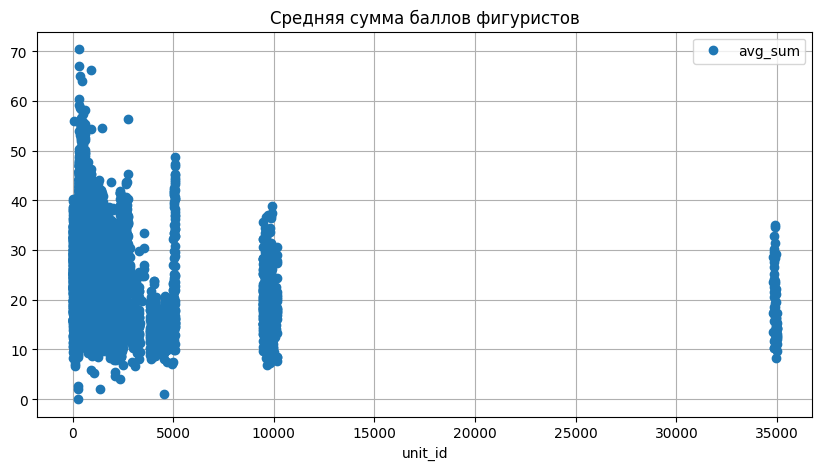

In [122]:
short_new.plot(
    x='unit_id',
    y='avg_sum',
    style='o',
    grid=True,
    figsize=(10, 5),
    title = 'Средняя сумма баллов фигуристов'
)
plt.show()

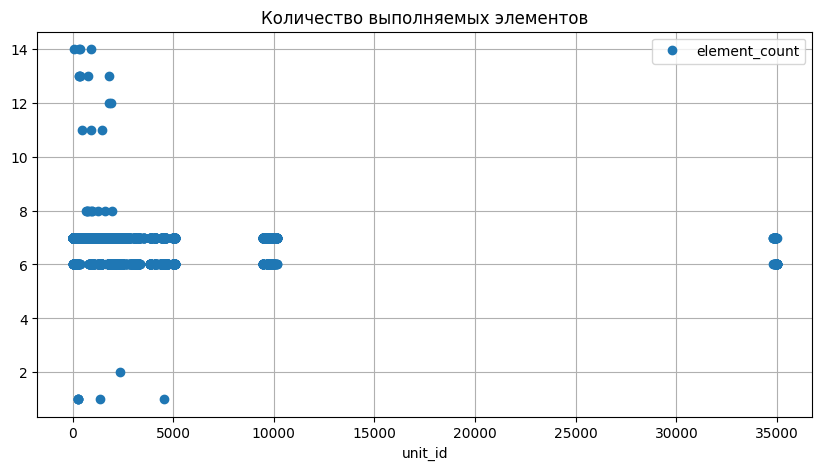

In [123]:
short_new.plot(
    x='unit_id',
    y='element_count',
    style='o',
    grid=True,
    figsize=(10, 5),
    title = 'Количество выполняемых элементов'
)
plt.show()

**В среднем фигуристы получают около 40 баллов за Короткую программу. Но есть и уникальные значения больше 60. Возможно это ошибки и выбросы, возможно, уникальные фигуристы. Также в среднем фигуристы выполняют по 6-7 элементов.**

**Посчитаем, сколько элементов выполняет фигурист за *Произвольную программу* и какое среднее суммарное значение получает. Индексами будут два значения - сам фигурист (*unit_id*) и дата начала турнира (*date_start*)**

In [124]:
free_new = df_free.pivot_table(index=['date_start', 'unit_id'], values='avg_score', aggfunc=['sum', 'count'])
free_new = free_new.reset_index().droplevel(1, axis=1)
free_new.columns = ['date_start', 'unit_id', 'avg_sum', 'element_count']
free_new.sort_values(by='date_start').reset_index(drop=True).head(10)

date_start  unit_id  avg_sum  element_count
0 2089-09-20      306    75.93             11
1 2089-09-20      903    44.62             11
2 2089-09-20      905    55.70             11
3 2089-09-20      906    44.60             11
4 2089-09-20      923    33.58             11
5 2089-09-20      924    49.04             11
6 2089-09-20     1441    54.94             11
7 2089-09-20     1623    35.37             11
8 2089-09-20     1873    50.35             12
9 2089-09-20     2323    52.42             11

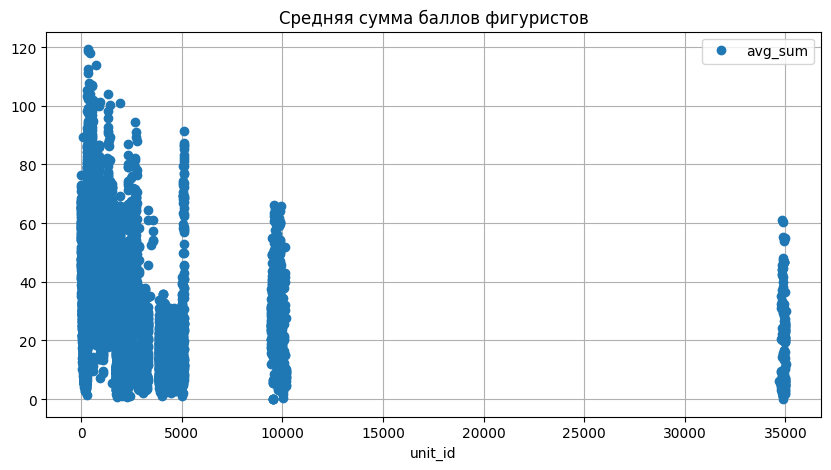

In [125]:
free_new.plot(
    x='unit_id',
    y='avg_sum',
    style='o',
    grid=True,
    figsize=(10, 5),
    title = 'Средняя сумма баллов фигуристов'
)
plt.show()

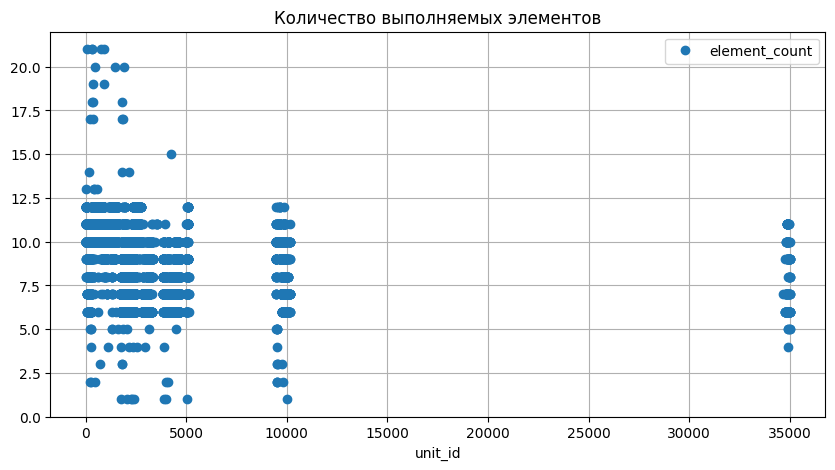

In [126]:
free_new.plot(
    x='unit_id',
    y='element_count',
    style='o',
    grid=True,
    figsize=(10, 5),
    title = 'Количество выполняемых элементов'
)
plt.show()

**В среднем фигуристы получают около 60 баллов за Произвольную программу. Но есть и уникальные значения больше 100. Возможно это ошибки и выбросы, возможно, уникальные фигуристы. Также в среднем фигуристы выполняют по 11-12 элементов.**

## Задача классификации

**Рассмотрим задачу классификации для двух программ - Произвольной и Короткой. Целевой признак - столбец *error_point* - был ли выполнен элемент с ошибкой или нет.**

Далее проведем более подробный корреляционный анализ, в том числе категориальных признаков с помощью `phik`. Это позволит уменьшить количество признаков для обучения за счет удаления признаков с мультиколлинеарностью.

Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата.

В машинном обучении мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает.

### Короткая программа

In [127]:
df_short_phik = (df_short.phik_matrix()).round(2)

interval columns not set, guessing: ['unit_id', 'title_base_score', 'base_score_element_1', 'base_score_element_2', 'base_score_element_3', 'base_score_element_4', 'goe', 'avg_score', 'error_point']


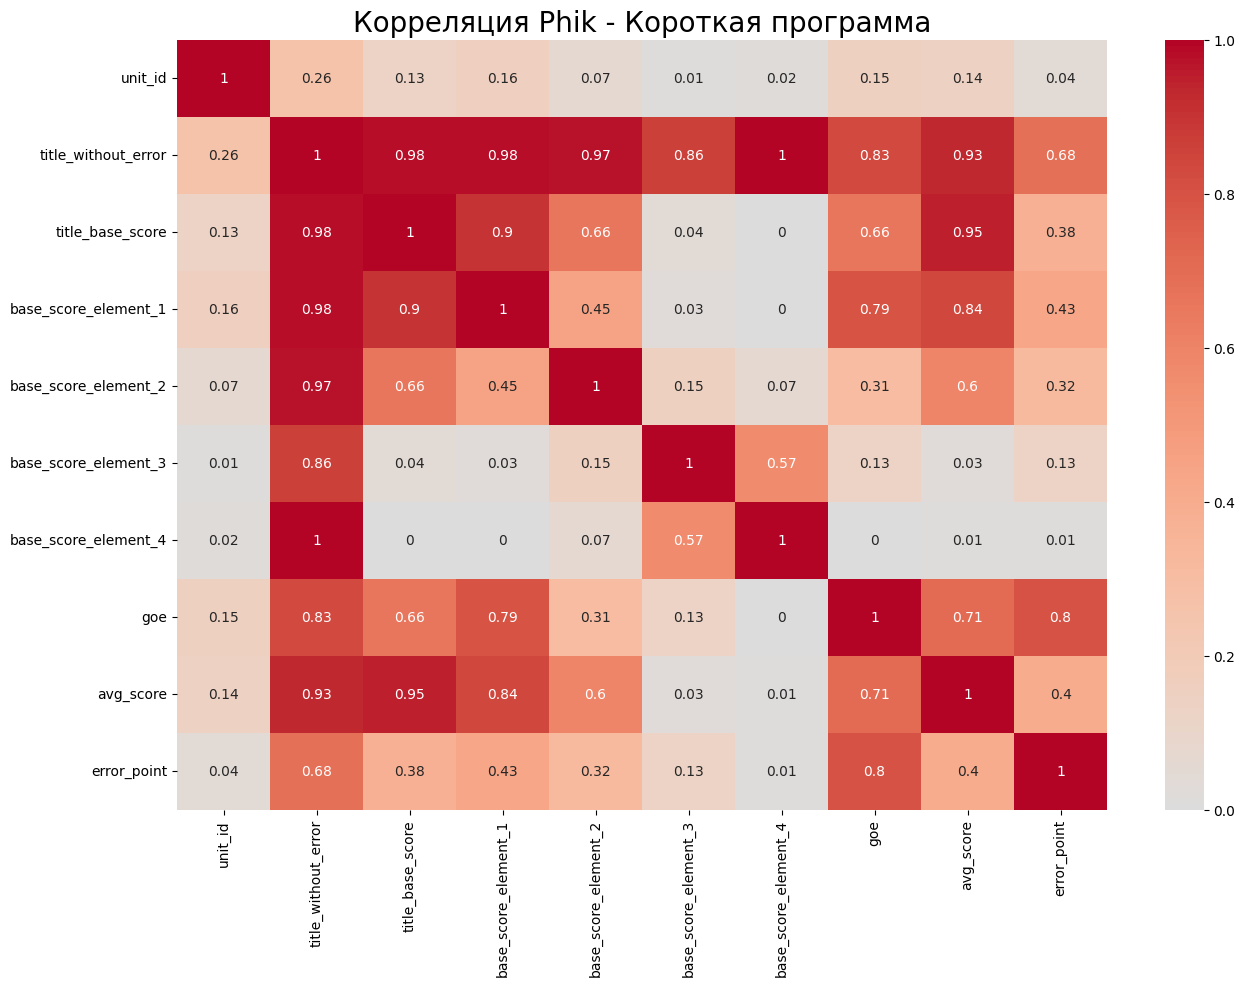

In [128]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_short_phik, cmap='coolwarm', center=0, annot=True)
plt.title("Корреляция Phik - Короткая программа", fontsize=20)
plt.show()

Если признаки коррелируют между собой более, чем на 0.7, то один из признаков убираем, чтобы не было мультиколлинеарности. Также удалим признаки, которые никак не коррелируют с целевым признаком.

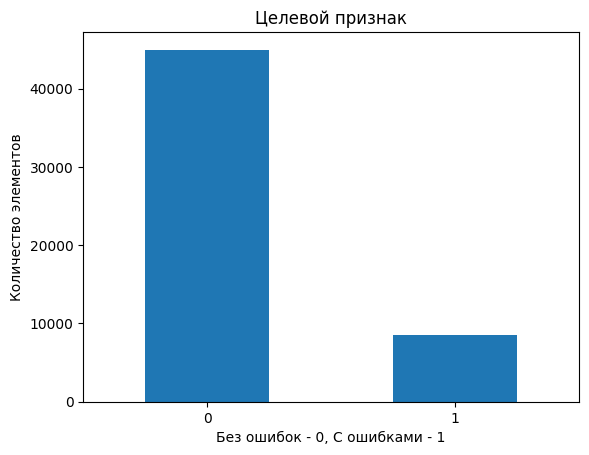

In [129]:
df_short['error_point'].value_counts().plot.bar()
plt.title("Целевой признак")
plt.ylabel('Количество элементов')
plt.xlabel('Без ошибок - 0, С ошибками - 1')
plt.xticks(rotation=0)
plt.show()

#### Деление данных на выборки

Делим на тренировочную и тестовую выборки. Поставим shuffle=False, чтобы не перемешивать наши данные

In [130]:
train, test = train_test_split(df_short, shuffle=False, test_size=0.2, random_state=RANDOM_STATE)


print('Размер тренировочной выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер тренировочной выборки: (42806, 11)
Размер тестовой выборки: (10702, 11)


In [131]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2089-09-20 00:00:00 2092-02-10 00:00:00
2092-02-10 00:00:00 2092-04-29 00:00:00


In [132]:
features_train_short = train.drop(['error_point', 'segment_name'], axis=1)
target_train_short = train['error_point']

features_test_short = test.drop(['error_point', 'segment_name'], axis=1)
target_test_short = test['error_point']

print('Размер тренировочной выборки (признаки):', features_train_short.shape)
print('Размер тестовой выборки (признаки):', features_test_short.shape)
print('Размер тренировочной выборки (целевой признак):', target_train_short.shape)
print('Размер тестовой выборки (целевой признак):', target_test_short.shape)

Размер тренировочной выборки (признаки): (42806, 9)
Размер тестовой выборки (признаки): (10702, 9)
Размер тренировочной выборки (целевой признак): (42806,)
Размер тестовой выборки (целевой признак): (10702,)


In [133]:
features_train_short.head()

unit_id title_without_error  title_base_score  \
date_start                                                  
2089-09-20      304                  3A              8.00   
2089-09-20      304                  3F              5.30   
2089-09-20      304              3Lz+3T             11.11   
2089-09-20      304               CCSp4              3.20   
2089-09-20      304              CCoSp4              3.50   

            base_score_element_1  base_score_element_2  base_score_element_3  \
date_start                                                                     
2089-09-20                   0.0                   0.0                   0.0   
2089-09-20                   5.3                   0.0                   0.0   
2089-09-20                   5.9                   4.2                   0.0   
2089-09-20                   3.2                   0.0                   0.0   
2089-09-20                   3.5                   0.0                   0.0   

            base_score_element_4   goe  avg_score  
date_start                                         
2089-09-20                   0.0  1.60       9.60  
2089-09-20                   0.0  1.77       7.07  
2089-09-20                   0.0  1.77      12.88  
2089-09-20                   0.0  0.11       3.31  
2089-09-20                   0.0  0.93       4.43

**Закодируем признаки**

Закодируем признаки отдельно для логистической регрессии (`LogisticRegression`) и случайного леса (`RandomForestClassifier`):

- для регрессии будем использовать как кодирование категориальных признаков (OneHotEncoder), так и шкалирование (StandardScaler) для количественных признаков;
- для случайного леса шкалирование не требуется, применим только OrdinalEncoder.

Наименования категориальных признаков будем использовать для `CatBoostClassifier`, так как эта модель имеет свой кодировщик для категориальных значений - `cat_features`.

In [134]:
# категориальные признаки

oe_features = features_train_short.select_dtypes(include=['object']).columns.to_list()
oe_features

['title_without_error']

In [135]:
# численные признаки

num_features = features_train_short.select_dtypes(exclude=['object']).columns.to_list()
num_features

['unit_id',
 'title_base_score',
 'base_score_element_1',
 'base_score_element_2',
 'base_score_element_3',
 'base_score_element_4',
 'goe',
 'avg_score']

Создадим трансформеры для LogisticRegression и RandomForestClassifier

In [136]:
col_transformer_LR = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', drop='first'), oe_features),
    (StandardScaler(), num_features))

In [137]:
col_transformer_RFC = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), oe_features),
    remainder='passthrough')

#### Построение моделей и оценка их качества

Будут подобраны параметры и построены следующие модели:

- LogisticRegression;
- RandomForestClassifier;
- CatBoostClassifier.

В завершении будет выбрана модель с наилучшими показателями целевой метрики F1.

**Напишем функцию для подбора гиперпараметров**

Подбор лучших гиперпараметров осуществим с помощью RandomizedSearchCV. Воспользуемся кросс-валидацией для временных рядов TimeSeriesSplit()

In [138]:
tscv = TimeSeriesSplit(n_splits=3)

In [139]:
def best_hyper_model(model,
                     parameters_m,
                     transform,
                     features=features_train_short,
                     target=target_train_short):

    steps = [('transform', transform), ('model', model)]
    model = Pipeline(steps)

    # подбор лучших гиперпараметров модели с учетом метрики F1

    rand_m = RandomizedSearchCV(estimator=model,
                                param_distributions=parameters_m,
                                cv=tscv,
                                scoring='f1',
                                n_jobs=-2,
                                random_state=RANDOM_STATE)

    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)

    best_model = rand_m.best_estimator_

    best_score = rand_m.best_score_
    print('F1 модели', best_score)

    return  best_model, best_params, best_score

**Первая модель - Логистическая регрессия (LogisticRegression)**

In [140]:
parameters_LR_s  = {'model__class_weight': ['balanced', None], 'model__C' : [10, 100, 1000]}

In [141]:
%%time

model_LR_s, params_LR_s, best_score_LR_s = best_hyper_model(
    LogisticRegression(random_state=RANDOM_STATE),
    parameters_LR_s,
    col_transformer_LR
)

Гиперпараметры лучшей модели {'model__class_weight': None, 'model__C': 1000}
F1 модели 0.822885926862257
CPU times: user 4.4 s, sys: 66.4 ms, total: 4.46 s
Wall time: 4.47 s


In [142]:
results_LR = []
results_LR.append({'Модель': 'LogisticRegression',
                'Параметры': params_LR_s,
                'F1': round(best_score_LR_s, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_LR)

Модель                                        Параметры    F1
0  LogisticRegression  {'model__class_weight': None, 'model__C': 1000}  0.82

**Вторая модель - Случайный лес (RandomForestClassifier).**

In [143]:
parameters_RFC_s  = {'model__max_depth': [None] + [i for i in range(2, 7)],
                     'model__n_estimators': range(1, 101, 10),
                     'model__class_weight': ['balanced', None]}

In [144]:
%%time

model_RFC_s, params_RFC_s, best_score_RFC_s = best_hyper_model(
    RandomForestClassifier(random_state=RANDOM_STATE),
    parameters_RFC_s,
    col_transformer_RFC
)

Гиперпараметры лучшей модели {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}
F1 модели 0.863484460386258
CPU times: user 26.9 s, sys: 129 ms, total: 27 s
Wall time: 27.3 s


In [145]:
results_RFC = []
results_RFC.append({'Модель': 'RandomForestClassifier',
                'Параметры': params_RFC_s,
                'F1': round(best_score_RFC_s, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_RFC)

Модель  \
0  RandomForestClassifier   

                                                                            Параметры  \
0  {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}   

     F1  
0  0.86

**Третья модель - CatBoostClassifier.**

In [146]:
parameters_CBC_s  = {'model__iterations': range(1, 101, 10),
                     'model__depth' : range(1, 16, 1),
                     'model__learning_rate' : [0.001, 0.01,0.02,0.03,0.04],
                     'model__loss_function' : ['Logloss', 'MultiClass'],
                     'verbose': [True, False]}

In [147]:
%%time

model_CBC_s, params_CBC_s, best_score_CBC_s = best_hyper_model(
    CatBoostClassifier(random_state=RANDOM_STATE,
                       auto_class_weights='Balanced',
                       cat_features=oe_features),
    parameters_CBC_s,
    transform=None
)

[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.0s
0:	learn: 0.6853499	total: 156ms	remaining: 3.11s
1:	learn: 0.6780615	total: 235ms	remaining: 2.23s
2:	learn: 0.6704712	total: 250ms	remaining: 1.5s
3:	learn: 0.6632884	total: 309ms	remaining: 1.31s
4:	learn: 0.6560337	total: 771ms	remaining: 2.47s
5:	learn: 0.6488035	total: 806ms	remaining: 2.02s
6:	learn: 0.6418452	total: 817ms	remaining: 1.63s
7:	learn: 0.6350203	total: 1.15s	remaining: 1.87s
8:	learn: 0.6284076	total: 1.49s	remaining: 1.98s
9:	learn: 0.6219531	total: 1.83s	remaining: 2.01s
10:	learn: 0.6155170	total: 2.15s	remaining: 1.95s
11:	learn: 0.6090166	total: 2.48s	remaining: 1.86s
12:	learn: 0.6027506	total: 2.5s	remaining: 1.54s
13:	learn: 0.5969887	total: 2.83s	remaining: 1.42s
14:	learn: 0.5908359	total: 3.15s	remaining: 1.26s
15:	learn: 0.5850613	total: 3.16s	remaining: 989ms
16:	learn: 0.5794737	total: 3.48s	remaining: 818ms
17:	learn: 0.5736882	total: 3.8s	remaining: 633ms
18:	learn: 0.5680645	tot

In [148]:
results_CBC = []
results_CBC.append({'Модель': 'CatBoostClassifier',
                'Параметры': params_CBC_s,
                'F1': round(best_score_CBC_s, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_CBC)

Модель  \
0  CatBoostClassifier   

                                                                                                                         Параметры  \
0  {'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.04, 'model__iterations': 81, 'model__depth': 11}   

     F1  
0  0.85

In [149]:
pd.DataFrame(
    {'Параметры': [params_LR_s, params_RFC_s, params_CBC_s],
     'F1': [round(best_score_LR_s, 2), round(best_score_RFC_s, 2), round(best_score_CBC_s, 2)]},
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
)

Параметры  \
LogisticRegression                                                                                      {'model__class_weight': None, 'model__C': 1000}   
RandomForestClassifier                                               {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}   
CatBoostClassifier      {'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.04, 'model__iterations': 81, 'model__depth': 11}   

                          F1  
LogisticRegression      0.82  
RandomForestClassifier  0.86  
CatBoostClassifier      0.85

Лучшей получилась модель *RandomForestClassifier*, проверим на ней наши тестовые данные.

**Проверим модель на тестовой выборке**

In [151]:
prediction_test_s = model_RFC_s.predict(features_test_short)

probabilities_test = model_RFC_s.predict_proba(features_test_short)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_test_s = roc_auc_score(target_test_short, probabilities_one_test)
accuracy_test_s = accuracy_score(target_test_short, prediction_test_s)
recall_test_s = recall_score(target_test_short, prediction_test_s)
f1_test_s = f1_score(target_test_short, prediction_test_s)

print("Результат тестовой метрики ROC-AUC для модели RandomForestClassifier:", round(roc_auc_test_s, 4))
print("Результат тестовой метрики Accuracy для модели RandomForestClassifier:", round(accuracy_test_s, 4))
print("Результат тестовой метрики Recall для модели RandomForestClassifier:", round(recall_test_s, 4))
print("Результат тестовой метрики F1 для модели RandomForestClassifier:", round(f1_test_s, 4))

Результат тестовой метрики ROC-AUC для модели RandomForestClassifier: 0.985
Результат тестовой метрики Accuracy для модели RandomForestClassifier: 0.9548
Результат тестовой метрики Recall для модели RandomForestClassifier: 0.8781
Результат тестовой метрики F1 для модели RandomForestClassifier: 0.8574


Метрики получены, проверим значение метрик для Произвольной программы и сделаем общий вывод.

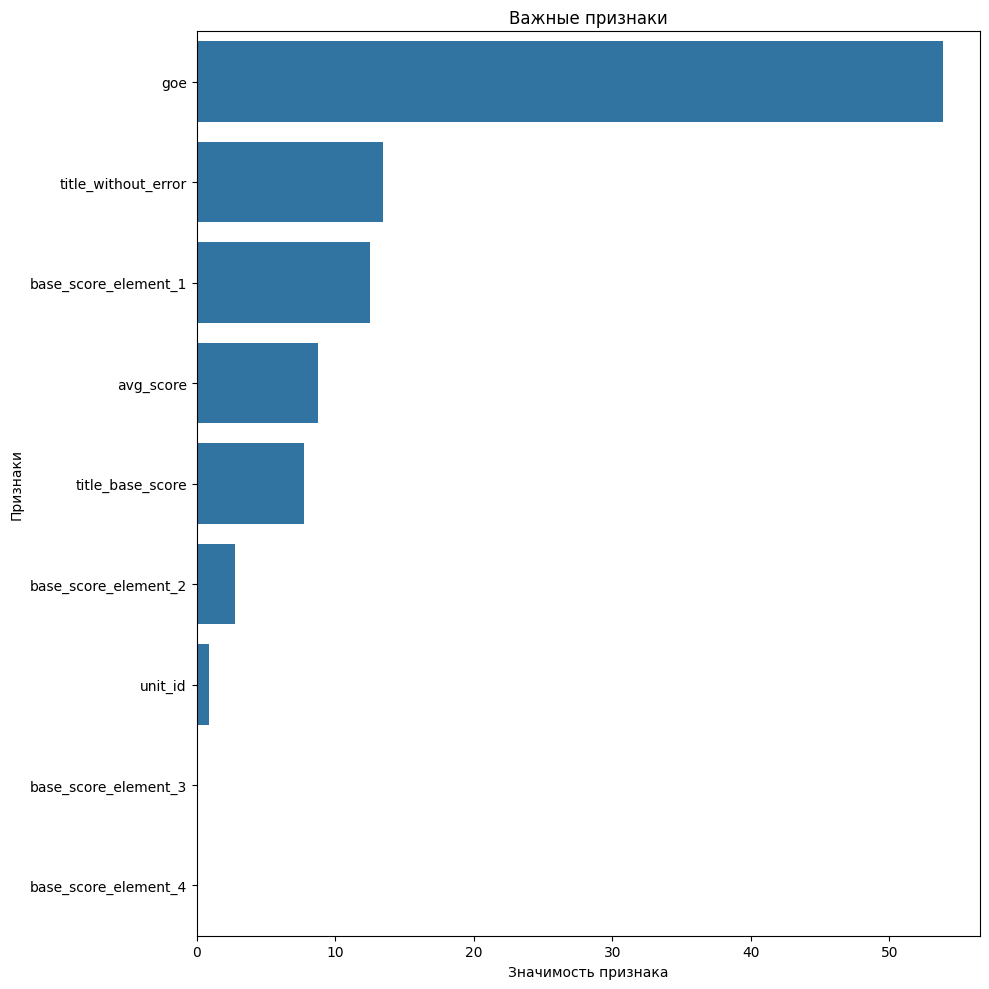

In [152]:
feature_imp = pd.DataFrame(
    sorted(zip(model_CBC_s._final_estimator.feature_importances_, features_train_short.columns)),
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Значимость признака",
            y="Признаки",
            data=feature_imp.sort_values(by="Значимость признака", ascending=False))
plt.title('Важные признаки')
plt.tight_layout()
plt.show()

Важным признаком при обучении оказалось *goe*, это логично, ведь знак "минус" в этом столбце обычно означает какую-то ошибку в элементе. Базовые score элементов 3 и 4 практически никак не участвуют в обучении модели, так как скорее всего их слишком мало (элементы в среднем состоят из 1-2 базовых элемента).

#### Построим матрицу ошибок

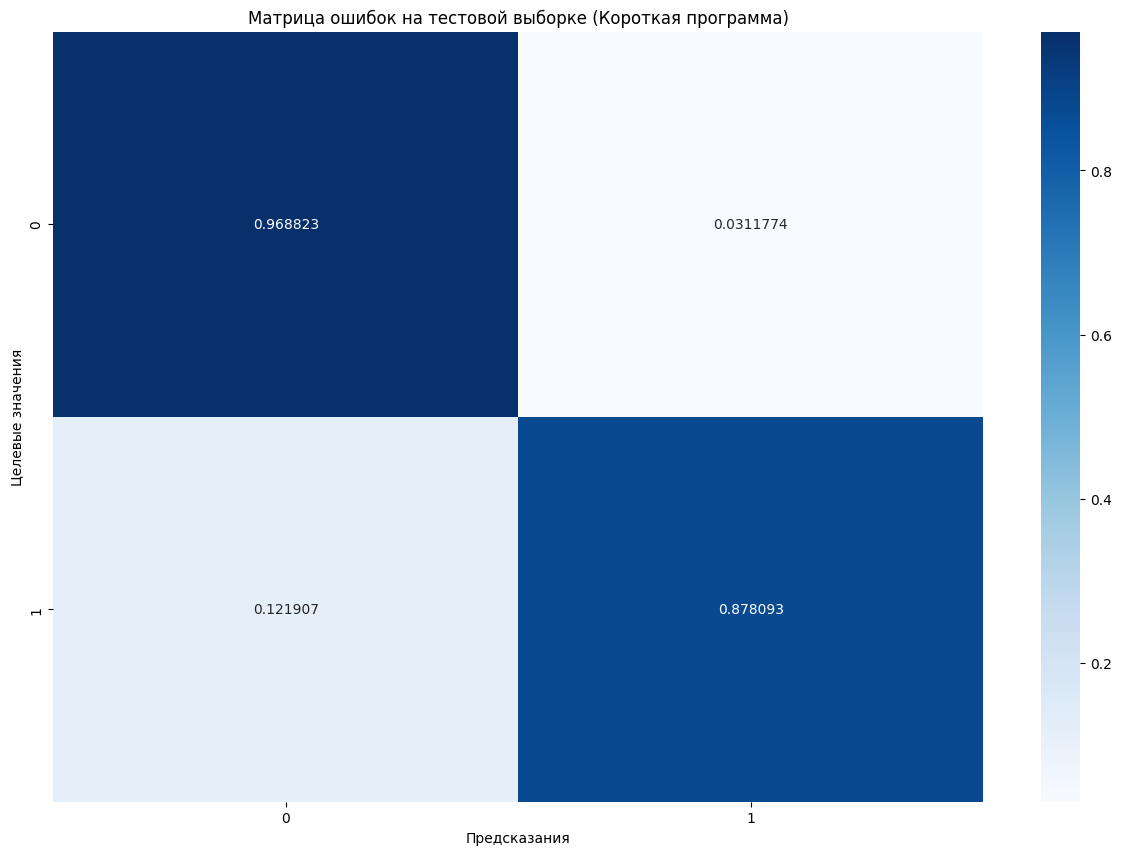

In [153]:
cm = confusion_matrix(target_test_short, prediction_test_s, normalize='true')
plt.subplots( figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок на тестовой выборке (Короткая программа)', fontsize=12 )
plt.xlabel('Предсказания')
plt.ylabel('Целевые значения')
plt.show()

По Матрице ошибок видна следующая картина:

- `True Positive` (истинно-положительное решение): элемент выполнен без ошибки и прогноз модели это предсказал *(Предсказания 0 : Целевые значения 0)* - 97%
- `False Positive` (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала что  элемент выполнен без ошибки, а на самом деле он с ошибкой *(Предсказания 1 : Целевые значения 0)* - 3%
- `False Negative` (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала, что  элемент выполнен с ошибкой, но на самом деле он без ошибки *(Предсказания 0 : Целевые значения 1)* - 12%
- `True Negative` (истинно-отрицательное решение): элемент выполнен с ошибкой и прогноз модели это предсказал *(Предсказания 1 : Целевые значения 1)* - 88%

### Произвольная программа

Сделаем все то же самое для Произвольной программы

In [154]:
df_free_phik = (df_free.phik_matrix()).round(2)

interval columns not set, guessing: ['unit_id', 'title_base_score', 'base_score_element_1', 'base_score_element_2', 'base_score_element_3', 'base_score_element_4', 'goe', 'avg_score', 'error_point']


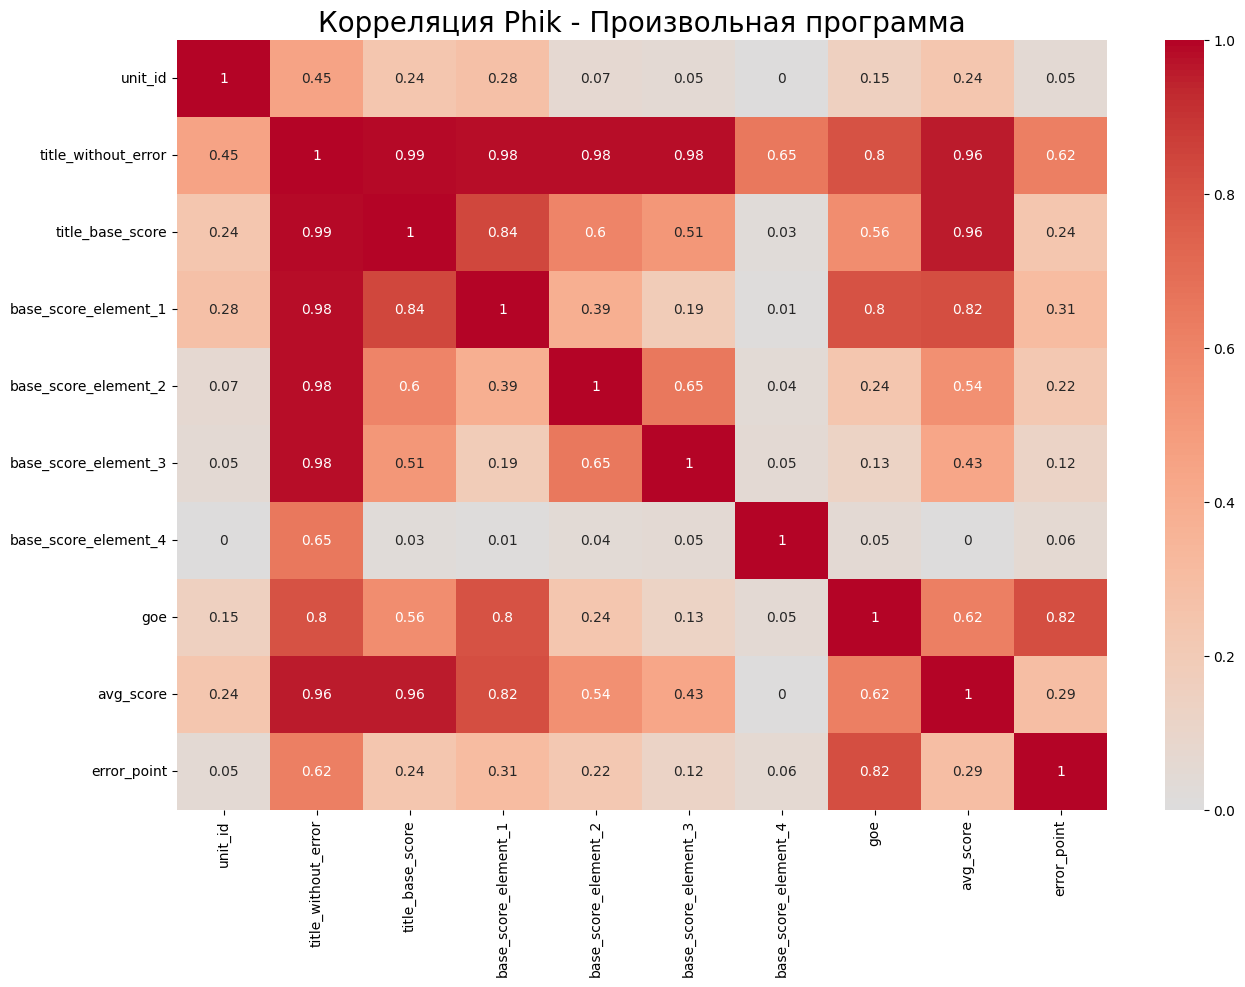

In [155]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_free_phik, cmap='coolwarm', center=0, annot=True)
plt.title("Корреляция Phik - Произвольная программа", fontsize=20)
plt.show()

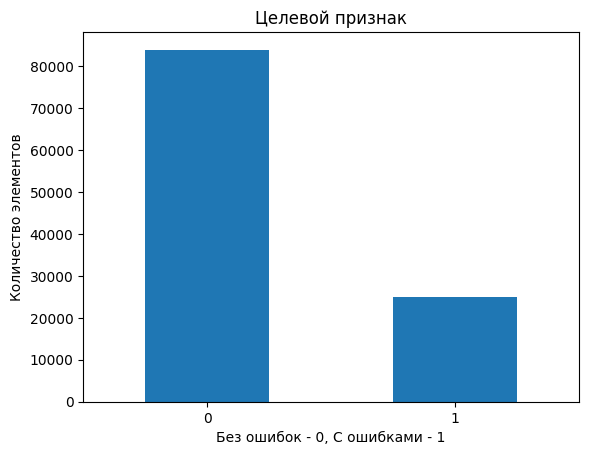

In [156]:
df_free['error_point'].value_counts().plot.bar()
plt.title("Целевой признак")
plt.ylabel('Количество элементов')
plt.xlabel('Без ошибок - 0, С ошибками - 1')
plt.xticks(rotation=0)
plt.show()

#### Деление данных на выборки

In [157]:
train, test = train_test_split(df_free, shuffle=False, test_size=0.2, random_state=RANDOM_STATE)


print('Размер тренировочной выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер тренировочной выборки: (87149, 11)
Размер тестовой выборки: (21788, 11)


In [158]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2089-09-20 00:00:00 2092-03-12 00:00:00
2092-03-12 00:00:00 2092-04-29 00:00:00


In [159]:
features_train_free = train.drop(['error_point', 'segment_name'], axis=1)
target_train_free = train['error_point']

features_test_free = test.drop(['error_point', 'segment_name'], axis=1)
target_test_free = test['error_point']

print('Размер тренировочной выборки (признаки):', features_train_free.shape)
print('Размер тестовой выборки (признаки):', features_test_free.shape)
print('Размер тренировочной выборки (целевой признак):', target_train_free.shape)
print('Размер тестовой выборки (целевой признак):', target_test_free.shape)

Размер тренировочной выборки (признаки): (87149, 9)
Размер тестовой выборки (признаки): (21788, 9)
Размер тренировочной выборки (целевой признак): (87149,)
Размер тестовой выборки (целевой признак): (21788,)


In [160]:
features_train_free.head()

unit_id title_without_error  title_base_score  \
date_start                                                  
2089-09-20      306                  3A              8.00   
2089-09-20      306               3A+3T             12.20   
2089-09-20      306                  3F              5.83   
2089-09-20      306                 3Lo              4.90   
2089-09-20      306          3Lz+1Eu+3S             11.77   

            base_score_element_1  base_score_element_2  base_score_element_3  \
date_start                                                                     
2089-09-20                   0.0                   0.0                   0.0   
2089-09-20                   0.0                   4.2                   0.0   
2089-09-20                   5.3                   0.0                   0.0   
2089-09-20                   4.9                   0.0                   0.0   
2089-09-20                   5.9                   0.5                   4.3   

            base_score_element_4   goe  avg_score  
date_start                                         
2089-09-20                   0.0  0.80       8.80  
2089-09-20                   0.0  0.80      13.00  
2089-09-20                   0.0 -1.06       4.77  
2089-09-20                   0.0  0.98       5.88  
2089-09-20                   0.0  0.20      11.97

**Закодируем признаки**

Закодируем признаки отдельно для логистической регрессии (`LogisticRegression`) и случайного леса (`RandomForestClassifier`):

- для регрессии будем использовать как кодирование категориальных признаков (OneHotEncoder), так и шкалирование (StandardScaler) для количественных признаков;
- для случайного леса шкалирование не требуется, применим только OrdinalEncoder.

Наименования категориальных признаков будем использовать для `CatBoostClassifier`, так как эта модель имеет свой кодировщик для категориальных значений - `cat_features`.

In [161]:
# категориальные признаки

oe_features = features_train_free.select_dtypes(include=['object']).columns.to_list()
oe_features

['title_without_error']

In [162]:
# численные признаки

num_features = features_train_free.select_dtypes(exclude=['object']).columns.to_list()
num_features

['unit_id',
 'title_base_score',
 'base_score_element_1',
 'base_score_element_2',
 'base_score_element_3',
 'base_score_element_4',
 'goe',
 'avg_score']

Создадим трансформеры для LogisticRegression и RandomForestClassifier

In [163]:
col_transformer_LR = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', drop='first'), oe_features),
    (StandardScaler(), num_features))

In [164]:
col_transformer_RFC = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), oe_features),
    remainder='passthrough')

#### Построение моделей и оценка их качества

Будут подобраны параметры и построены следующие модели:

- LogisticRegression;
- RandomForestClassifier;
- CatBoostClassifier.

В завершении будет выбрана модель с наилучшими показателями целевой метрики F1.

**Напишем функцию для подбора гиперпараметров**

In [165]:
def best_hyper_model(model,
                     parameters_m,
                     transform,
                     features=features_train_free,
                     target=target_train_free):

    steps = [('transform', transform), ('model', model)]
    model = Pipeline(steps)

    # подбор лучших гиперпараметров модели с учетом метрики F1

    rand_m = RandomizedSearchCV(estimator=model,
                                param_distributions=parameters_m,
                                cv=tscv,
                                scoring='f1',
                                n_jobs=-2,
                                random_state=RANDOM_STATE)

    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)

    best_model = rand_m.best_estimator_

    best_score = rand_m.best_score_
    print('F1 модели', best_score)

    return  best_model, best_params, best_score

**Первая модель - Логистическая регрессия (LogisticRegression)**

In [166]:
parameters_LR_f  = {'model__class_weight': ['balanced', None], 'model__C' : [10, 100, 1000]}

In [167]:
%%time

model_LR_f, params_LR_f, best_score_LR_f = best_hyper_model(
    LogisticRegression(random_state=RANDOM_STATE),
    parameters_LR_f,
    col_transformer_LR
)

Гиперпараметры лучшей модели {'model__class_weight': 'balanced', 'model__C': 100}
F1 модели 0.8067197594542027
CPU times: user 9.79 s, sys: 77.1 ms, total: 9.87 s
Wall time: 14 s


In [168]:
results_LR = []
results_LR.append({'Модель': 'LogisticRegression',
                'Параметры': params_LR_f,
                'F1': round(best_score_LR_f, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_LR)

Модель                                             Параметры  \
0  LogisticRegression  {'model__class_weight': 'balanced', 'model__C': 100}   

     F1  
0  0.81

**Вторая модель - Случайный лес (RandomForestClassifier).**

In [169]:
parameters_RFC_f  = {'model__max_depth': [None] + [i for i in range(2, 7)],
                     'model__n_estimators': range(1, 101, 10),
                     'model__class_weight': ['balanced', None]}

In [170]:
%%time

model_RFC_f, params_RFC_f, best_score_RFC_f = best_hyper_model(
    RandomForestClassifier(random_state=RANDOM_STATE),
    parameters_RFC_f,
    col_transformer_RFC
)

Гиперпараметры лучшей модели {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}
F1 модели 0.8584394455131849
CPU times: user 1min 7s, sys: 185 ms, total: 1min 7s
Wall time: 1min 8s


In [171]:
results_RFC = []
results_RFC.append({'Модель': 'RandomForestClassifier',
                'Параметры': params_RFC_f,
                'F1': round(best_score_RFC_f, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_RFC)

Модель  \
0  RandomForestClassifier   

                                                                            Параметры  \
0  {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}   

     F1  
0  0.86

**Третья модель - CatBoostClassifier.**

In [172]:
parameters_CBC_f  = {'model__iterations': range(1, 101, 10),
                     'model__depth' : range(1, 16, 1),
                     'model__learning_rate' : [0.001, 0.01,0.02,0.03,0.04],
                     'model__loss_function' : ['Logloss', 'MultiClass'],
                     'verbose': [True, False]}

In [173]:
%%time

model_CBC_f, params_CBC_f, best_score_CBC_f = best_hyper_model(
    CatBoostClassifier(random_state=RANDOM_STATE,
                       auto_class_weights='Balanced',
                       cat_features=oe_features),
    parameters_CBC_f,
    transform=None
)

[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.0s
0:	learn: 0.6860166	total: 486ms	remaining: 9.72s
1:	learn: 0.6790044	total: 881ms	remaining: 8.37s
2:	learn: 0.6722622	total: 1.3s	remaining: 7.82s
3:	learn: 0.6655529	total: 1.69s	remaining: 7.19s
4:	learn: 0.6590558	total: 2.11s	remaining: 6.77s
5:	learn: 0.6526623	total: 2.48s	remaining: 6.21s
6:	learn: 0.6463398	total: 2.9s	remaining: 5.81s
7:	learn: 0.6400912	total: 2.92s	remaining: 4.75s
8:	learn: 0.6339981	total: 2.96s	remaining: 3.94s
9:	learn: 0.6279719	total: 3.04s	remaining: 3.34s
10:	learn: 0.6220680	total: 3.44s	remaining: 3.13s
11:	learn: 0.6163796	total: 3.83s	remaining: 2.87s
12:	learn: 0.6106060	total: 4.24s	remaining: 2.61s
13:	learn: 0.6049529	total: 4.31s	remaining: 2.16s
14:	learn: 0.5993623	total: 4.73s	remaining: 1.89s
15:	learn: 0.5940594	total: 5.15s	remaining: 1.61s
16:	learn: 0.5887687	total: 5.3s	remaining: 1.25s
17:	learn: 0.5836588	total: 5.71s	remaining: 951ms
18:	learn: 0.5785864	tot

In [174]:
results_CBC = []
results_CBC.append({'Модель': 'CatBoostClassifier',
                'Параметры': params_CBC_f,
                'F1': round(best_score_CBC_f, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_CBC)

Модель  \
0  CatBoostClassifier   

                                                                                                                         Параметры  \
0  {'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.04, 'model__iterations': 81, 'model__depth': 11}   

     F1  
0  0.85

In [175]:
pd.DataFrame(
    {'Параметры': [params_LR_f, params_RFC_f, params_CBC_f],
     'F1': [round(best_score_LR_f, 2), round(best_score_RFC_f, 2), round(best_score_CBC_f, 2)]},
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
)

Параметры  \
LogisticRegression                                                                                 {'model__class_weight': 'balanced', 'model__C': 100}   
RandomForestClassifier                                               {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}   
CatBoostClassifier      {'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.04, 'model__iterations': 81, 'model__depth': 11}   

                          F1  
LogisticRegression      0.81  
RandomForestClassifier  0.86  
CatBoostClassifier      0.85

В Произвольной программе также лучшей моделью стал *RandomForestClassifier*.

**Проверим модель на тестовой выборке**

In [176]:
prediction_test_f = model_RFC_f.predict(features_test_free)

probabilities_test = model_RFC_f.predict_proba(features_test_free)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_test = roc_auc_score(target_test_free, probabilities_one_test)
accuracy_test = accuracy_score(target_test_free, prediction_test_f)
recall_test = recall_score(target_test_free, prediction_test_f)
f1_test = f1_score(target_test_free, prediction_test_f)

print("Результат тестовой метрики ROC-AUC для модели RandomForestClassifier:", round(roc_auc_test, 4))
print("Результат тестовой метрики Accuracy для модели RandomForestClassifier:", round(accuracy_test, 4))
print("Результат тестовой метрики Recall для модели RandomForestClassifier:", round(recall_test, 4))
print("Результат тестовой метрики F1 для модели RandomForestClassifier:", round(f1_test, 4))

Результат тестовой метрики ROC-AUC для модели RandomForestClassifier: 0.9831
Результат тестовой метрики Accuracy для модели RandomForestClassifier: 0.943
Результат тестовой метрики Recall для модели RandomForestClassifier: 0.8901
Результат тестовой метрики F1 для модели RandomForestClassifier: 0.8807


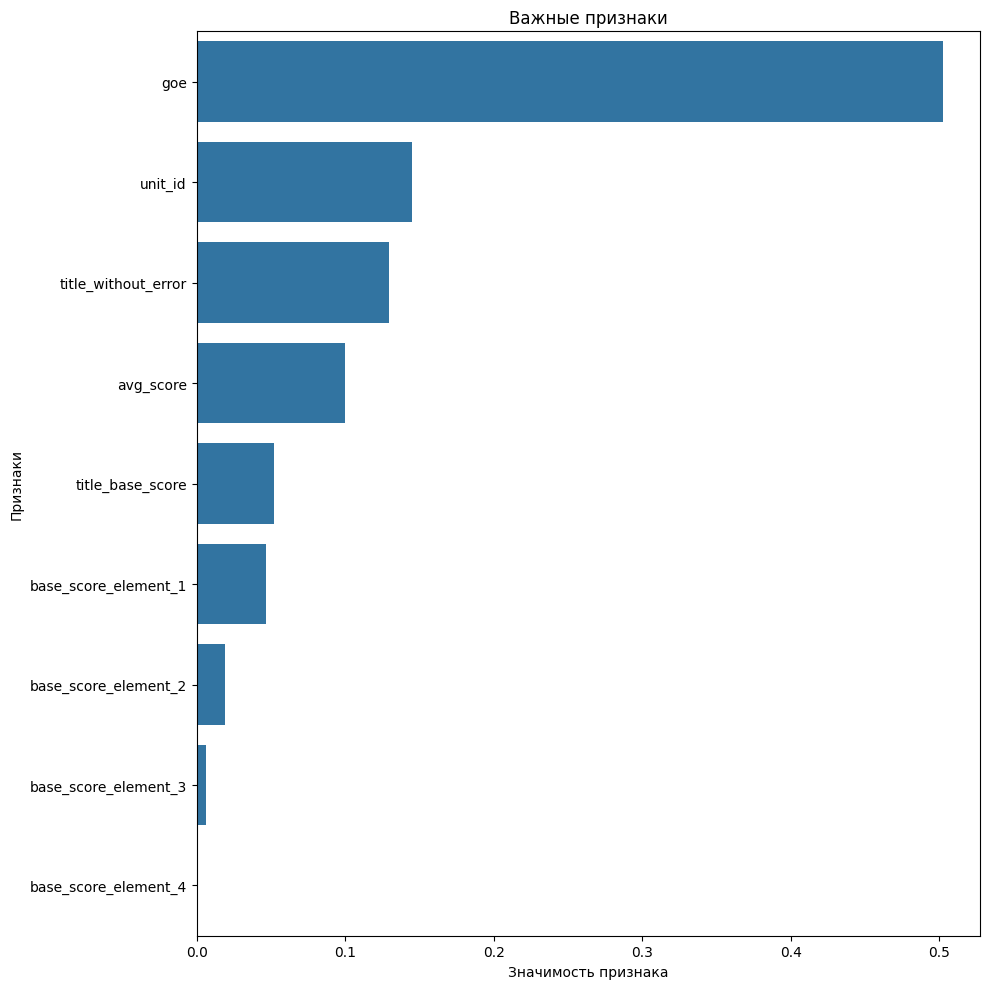

In [177]:
feature_imp = pd.DataFrame(
    sorted(zip(model_RFC_f._final_estimator.feature_importances_, features_train_free.columns)),
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Значимость признака",
            y="Признаки",
            data=feature_imp.sort_values(by="Значимость признака", ascending=False))
plt.title('Важные признаки')
plt.tight_layout()
plt.show()

#### Построим матрицу ошибок

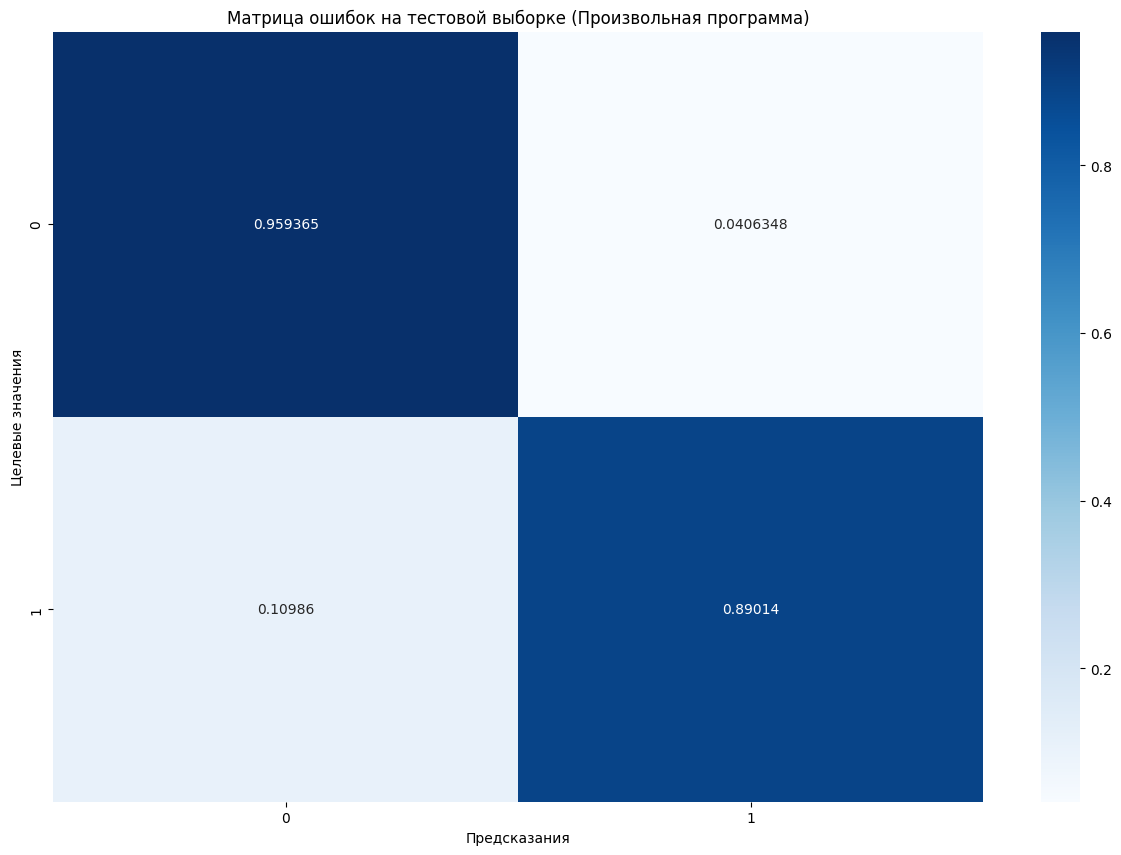

In [178]:
cm = confusion_matrix(target_test_free, prediction_test_f, normalize='true')
plt.subplots( figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок на тестовой выборке (Произвольная программа)', fontsize=12 )
plt.xlabel('Предсказания')
plt.ylabel('Целевые значения')
plt.show()

По Матрице ошибок видна следующая картина:

- `True Positive` (истинно-положительное решение): элемент выполнен без ошибки и прогноз модели это предсказал *(Предсказания 0 : Целевые значения 0)* - 96%
- `False Positive` (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала что  элемент выполнен без ошибки, а на самом деле он с ошибкой *(Предсказания 1 : Целевые значения 0)* - 4%
- `False Negative` (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала, что  элемент выполнен с ошибкой, но на самом деле он без ошибки *(Предсказания 0 : Целевые значения 1)* - 11%
- `True Negative` (истинно-отрицательное решение): элемент выполнен с ошибкой и прогноз модели это предсказал *(Предсказания 1 : Целевые значения 1)* - 89%

**Выводы по задаче классификации по Короткой и Произвольной программе:**

При несбалансированных данных оценка **F1** обеспечит лучшую оценку эффективности модели. Оценка F1 (F-мера) – среднее значение Точности измерений (Accuracy) и Полноты (Recall) с Весами (Weight) при наличии. F1 обычно более полезна, чем точность измерений, особенно если распределение классов неравномерно. Оценка F1 вычисляется по формуле: F1 = (2 * Accuracy * Recall) / (Accuracy + Recall).

**ROC-AUC** можно интерпретировать как показатель модели чьи прогнозы предсказания верны на 98%. Причем AUC не зависит от масштаба - он измеряет, насколько хорошо ранжируются прогнозы, а не их абсолютные значения и также не зависит от порога классификации - он измеряет качество прогнозов модели независимо от выбранного порога классификации.

**Accuracy** — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству. Стоит учесть, что метрика **Accuracy** может быть обманчивой. Один из таких случаев — это несбалансированные данные. Поскольку при дисбалансе большинство семплов принадлежит к одному классу, **Accuracy** для этого класса будет выше, чем для другого.

Полнота **Recall** выявляет, какую долю положительных среди всех ответов выделила модель. Полнота — это доля TP-ответов среди всех, у которых истинная метка 1. Хорошо, когда значение **Recall** близко к единице: модель хорошо ищет положительные объекты.

Наша модель предсказывает сможет ли выполнить фигурист какой-то определенный элемент с ошибкой (1) или без (0). Наилучшие показатель в обоих случаях показала модель *RandomForestClassifier* на метрике F1.

In [179]:
pd.DataFrame(
    {'Параметры': [params_RFC_s, params_RFC_f],
     'F1': [round(best_score_RFC_s, 2), round(best_score_RFC_f, 2)]},
    index=['RandomForestClassifier (Короткая программа)', 'RandomForestClassifier (Произвольная программа)']
)

Параметры  \
RandomForestClassifier (Короткая программа)      {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}   
RandomForestClassifier (Произвольная программа)  {'model__n_estimators': 71, 'model__max_depth': None, 'model__class_weight': None}   

                                                   F1  
RandomForestClassifier (Короткая программа)      0.86  
RandomForestClassifier (Произвольная программа)  0.86

Как видим параметры и метрики RandomForestClassifier одинаковые, модель одинаково учиться и в первом и втором случае.

## Задача регрессии

**Для задачи регрессии создадим другой датасет.**

Каждый элемент без ошибки преобразуем в столбец. Если значение 0 - значит элемент не выполнялся, если 1 - выполнялся.

In [180]:
df_title_2 = pd.pivot_table(
    df_total,
    index=[
        'date_start',
        'unit_id',
        'segment_name'],
    columns='title_without_error',
    aggfunc='count',
    values='total_score_tournament',
    fill_value=0
).reset_index()

In [181]:
df_title_2.head(3)

title_without_error date_start  unit_id            segment_name  1A  1A+1A  \
0                   2089-09-20      304      Короткая программа   0      0   
1                   2089-09-20      306      Короткая программа   0      0   
2                   2089-09-20      306  Произвольная программа   0      0   

title_without_error  1A+1Eu+1S  1A+1Eu+2F  1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  \
0                            0          0          0          0       0   
1                            0          0          0          0       0   
2                            0          0          0          0       0   

title_without_error  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  1A+2Lo  1A+2T  1A+3S  \
0                             0           0      0       0      0      0   
1                             0           0      0       0      0      0   
2                             0           0      0       0      0      0   

title_without_error  1A+3T  1A+Lo  1F  1F+1A  1F+1A+2A  1F+1Eu+2S  1F+1Eu+3S  \
0                        0      0   0      0         0          0          0   
1                        0      0   0      0         0          0          0   
2                        0      0   0      0         0          0          0   

title_without_error  1F+1Lo  1F+1T  1F+2A  1F+2A+2A  1F+2Lo  1F+2T  1F+3T  \
0                         0      0      0         0       0      0      0   
1                         0      0      0         0       0      0      0   
2                         0      0      0         0       0      0      0   

title_without_error  1Lo  1Lo+1A  1Lo+1Eu+2S  1Lo+1Eu+3S  1Lo+1Lo  1Lo+1T  \
0                      0       0           0           0        0       0   
1                      0       0           0           0        0       0   
2                      0       0           0           0        0       0   

title_without_error  1Lo+1T+1Lo  1Lo+2A  1Lo+2A+2Lo  1Lo+2Lo  1Lo+2T  1Lo+3T  \
0                             0       0           0        0       0       0   
1                             0       0           0        0       0       0   
2                             0       0           0        0       0       0   

title_without_error  1Lz  1Lz+1A  1Lz+1Eu+3S  1Lz+1Lo  1Lz+1T  1Lz+2A  \
0                      0       0           0        0       0       0   
1                      0       0           0        0       0       0   
2                      0       0           0        0       0       0   

title_without_error  1Lz+2A+2A  1Lz+2A+2T  1Lz+2Lo  1Lz+2Lo+2Lo  1Lz+2S  \
0                            0          0        0            0       0   
1                            0          0        0            0       0   
2                            0          0        0            0       0   

title_without_error  1Lz+2T  1Lz+3T  1S  1S+1A  1S+1Eu+2F  1S+1Lo  1S+1T  \
0                         0       0   0      0          0       0      0   
1                         0       0   0      0          0       0      0   
2                         0       0   0      0          0       0      0   

title_without_error  1S+2A  1S+2S+2T  1S+2T  1T  1T+1Lo  1T+1T  1W+1T  2A  \
0                        0         0      0   0       0      0      0   0   
1                        0         0      0   0       0      0      0   1   
2                        0         0      0   0       0      0      0   0   

title_without_error  2A+1A  2A+1A+1A  2A+1A+2Lo  2A+1A+2T  2A+1Eu+1F  \
0                        0         0          0         0          0   
1                        0         0          0         0          0   
2                        0         0          0         0          0   

title_without_error  2A+1Eu+1S  2A+1Eu+2F  2A+1Eu+2S  2A+1Eu+2T  2A+1Eu+3F  \
0                            0          0          0          0          0   
1                            0          0          0          0          0   
2                            0          0          0          0          0   

title_witho

**Объединим полученную таблицу с *df_total***

In [182]:
df_total_2 = df_total.merge(df_title_2, how='left', left_on=['date_start', 'unit_id', 'segment_name'], right_on=['date_start', 'unit_id', 'segment_name'])
df_total_2.head()

date_start  unit_id        segment_name  \
0 2089-09-20      304  Короткая программа   
1 2089-09-20      304  Короткая программа   
2 2089-09-20      304  Короткая программа   
3 2089-09-20      304  Короткая программа   
4 2089-09-20      304  Короткая программа   

                               title_sum  title_count   title  \
0  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7      3F   
1  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7      3A   
2  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7   CCSp4   
3  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7  CCoSp4   
4  3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4             7  3Lz+3T   

   title_base_score   goe  avg_score element_1 element_2 element_3 element_4  \
0              5.30  1.77       7.07        3F        No        No        No   
1              8.00  1.60       9.60        3A        No        No        No   
2              3.20  0.11       3.31     CCSp4        No        No        No   
3              3.50  0.93       4.43    CCoSp4        No        No        No   
4             11.11  1.77      12.88       3Lz        3T        No        No   

   error_point  base_score_element_1  base_score_element_2  \
0            0                   5.3                   0.0   
1            0                   0.0                   0.0   
2            0                   3.2                   0.0   
3            0                   3.5                   0.0   
4            0                   5.9                   4.2   

   base_score_element_3  base_score_element_4  total_base_score  \
0                   0.0                   0.0               5.3   
1                   0.0                   0.0               0.0   
2                   0.0                   0.0               3.2   
3                   0.0                   0.0               3.5   
4                   0.0                   0.0              10.1   

   base_score_tournament  components_score_tournament  total_score_tournament  \
0                  37.41                        38.67                   83.95   
1                  37.41                        38.67                   83.95   
2                  37.41                        38.67                   83.95   
3                  37.41                        38.67                   83.95   
4                  37.41                        38.67                   83.95   

   elements_score_tournament  decreasings_score_tournament  starting_place  \
0                      45.28                           0.0              26   
1                      45.28                           0.0              26   
2                      45.28                           0.0              26   
3                      45.28                           0.0              26   
4                      45.28                           0.0              26   

   place                                                     info  \
0      1  x Надбавка за прыжки во второй половине программы (10%)   
1      1  x Надбавка за прыжки во второй половине программы (10%)   
2      1  x Надбавка за прыжки во второй половине программы (10%)   
3      1  x Надбавка за прыжки во второй половине программы (10%)   
4      1  x Надбавка за прыжки во второй половине программы (10%)   

   overall_place  overall_total_score overall_place_str  increase_x  \
0              0                  0.0                WD         1.1   
1              0                  0.0                WD         1.1   
2              0                  0.0                WD         1.1   
3              0                  0.0                WD         1.1   
4              0                  0.0                WD         1.1   

    date_end  origin_id  amount_of_days title_without_error  \
0 2089-09-23        1.0               3                  3F   
1 2089-09-23        1.0               3                  3A   
2 2089-09-23        1.0               3               CCSp4   
3 2089-09-23        1.0          

**Удалим столбцы, которые нам не пригодятся. Это столбцы, где значения score расписаны поэлементно. Мы же будем рассматривать общие значения за сегменты программы на определенном турнире.**

In [183]:
df_total_2 = df_total_2.drop([
    'title',
    'title_base_score',
    'goe',
    'avg_score',
    'element_1',
    'element_2',
    'element_3',
    'element_4',
    'error_point',
    'base_score_element_1',
    'base_score_element_2',
    'base_score_element_3',
    'base_score_element_4',
    'total_base_score',
    'overall_place',
    'overall_total_score',
    'overall_place_str',
    'increase_x',
    'date_end',
    'title_without_error',
    'title_without_error_'],
    axis=1
)

In [184]:
df_total_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171689 entries, 0 to 171688
Columns: 577 entries, date_start to USpB
dtypes: datetime64[ns](1), float64(6), int64(567), object(3)
memory usage: 755.8+ MB


In [185]:
df_total_2 = df_total_2.set_index(['date_start'])

In [186]:
print('Количество дубликатов:', df_total_2.duplicated().sum())

Количество дубликатов: 150459


In [187]:
# Удалим дубликаты
df_total_2 = df_total_2.drop_duplicates()
print('Количество дубликатов:', df_total.duplicated().sum())

Количество дубликатов: 0


In [188]:
df_total_2.head()

unit_id            segment_name  \
date_start                                    
2089-09-20      304      Короткая программа   
2089-09-20      306      Короткая программа   
2089-09-20      306  Произвольная программа   
2089-09-20      310      Короткая программа   
2089-09-20      310  Произвольная программа   

                                                                title_sum  \
date_start                                                                  
2089-09-20                          3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4    
2089-09-20                          3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4    
2089-09-20  4T 3A+3T 3Lo 3A FCSp3 CSSp4 3Lz+2T 3F 3Lz+1Eu+3S StS2 CCoSp4    
2089-09-20                          2A 3Lz+3T CCSp4 3F FSSp3 StS3 CCoSp4    
2089-09-20     2A+3T 2A 3Lz+1Eu+2S 3Lo CCSp4 3Lz 3F 1F FSSp4 StS2 CCoSp4    

            title_count  base_score_tournament  components_score_tournament  \
date_start                                                                    
2089-09-20            7                  37.41                        38.67   
2089-09-20            7                  31.33                        35.75   
2089-09-20           11                  72.02                        72.48   
2089-09-20            7                  31.83                        34.07   
2089-09-20           11                  47.98                        66.50   

            total_score_tournament  elements_score_tournament  \
date_start                                                      
2089-09-20                   83.95                      45.28   
2089-09-20                   69.05                      34.30   
2089-09-20                  149.41                       0.00   
2089-09-20                   71.91                       0.00   
2089-09-20                  118.43                       0.00   

            decreasings_score_tournament  starting_place  place  \
date_start                                                        
2089-09-20                           0.0              26      1   
2089-09-20                          -1.0               1     10   
2089-09-20                           0.0              19      1   
2089-09-20                           0.0              21      7   
2089-09-20                          -1.0              22     10   

                                                                                                                                               info  \
date_start                                                                                                                                            
2089-09-20                                                                                  x Надбавка за прыжки во второй половине программы (10%)   
2089-09-20                                                                                  x Надбавка за прыжки во второй половине программы (10%)   
2089-09-20                                 x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   
2089-09-20                                 x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   
2089-09-20  ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   

            origin_id  amount_of_days  1A  1A+1A  1A+1Eu+1S  1A+1Eu+2F  \
date_start                                                               
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   

            1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  \
date_start

In [189]:
df_total_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21230 entries, 2089-09-20 to 2092-04-29
Columns: 576 entries, unit_id to USpB
dtypes: float64(6), int64(567), object(3)
memory usage: 93.5+ MB


#### Деление данных на выборки

In [190]:
train, test = train_test_split(df_total_2, shuffle=False, test_size=0.2, random_state=RANDOM_STATE)


print('Размер тренировочной выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер тренировочной выборки: (16984, 576)
Размер тестовой выборки: (4246, 576)


Проверим, что данные не перемешались и идут последовательно по датам

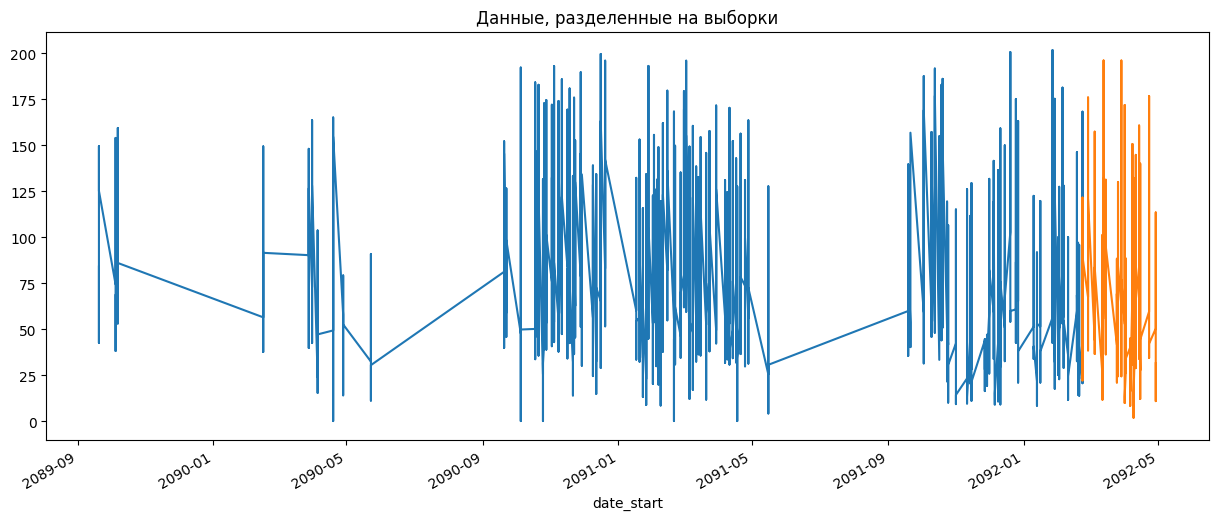

In [191]:
plt.figure(figsize=(15, 6))
plt.title('Данные, разделенные на выборки')

train['total_score_tournament'].plot()
test['total_score_tournament'].plot()

plt.show()

Наблюдаем определенную сезонность выступлений фигуристов - начиная с 09 месяца по 05 месяц следующего года, затем небольшой перерыв и заново.

In [192]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2089-09-20 00:00:00 2092-02-23 00:00:00
2092-02-23 00:00:00 2092-04-29 00:00:00


Подготовим признаки и целевой признак. Будем предсказывать сколько фигурист получить баллов за определенный сегмент программы (Короткую или Произвольную) - *total_score_tournament*.

In [193]:
features_train = train.drop(['total_score_tournament'], axis=1)
target_train = train['total_score_tournament']

features_test = test.drop(['total_score_tournament'], axis=1)
target_test = test['total_score_tournament']

print('Размер тренировочной выборки (признаки):', features_train.shape)
print('Размер тестовой выборки (признаки):', features_test.shape)
print('Размер тренировочной выборки (целевой признак):', target_train.shape)
print('Размер тестовой выборки (целевой признак):', target_test.shape)

Размер тренировочной выборки (признаки): (16984, 575)
Размер тестовой выборки (признаки): (4246, 575)
Размер тренировочной выборки (целевой признак): (16984,)
Размер тестовой выборки (целевой признак): (4246,)


In [194]:
features_train.head()

unit_id            segment_name  \
date_start                                    
2089-09-20      304      Короткая программа   
2089-09-20      306      Короткая программа   
2089-09-20      306  Произвольная программа   
2089-09-20      310      Короткая программа   
2089-09-20      310  Произвольная программа   

                                                                title_sum  \
date_start                                                                  
2089-09-20                          3F 3A CCSp4 CCoSp4 3Lz+3T StS3 FSSp4    
2089-09-20                          3Lz+3T 2A CCSp2 3F FSSp4 StS3 CCoSp4    
2089-09-20  4T 3A+3T 3Lo 3A FCSp3 CSSp4 3Lz+2T 3F 3Lz+1Eu+3S StS2 CCoSp4    
2089-09-20                          2A 3Lz+3T CCSp4 3F FSSp3 StS3 CCoSp4    
2089-09-20     2A+3T 2A 3Lz+1Eu+2S 3Lo CCSp4 3Lz 3F 1F FSSp4 StS2 CCoSp4    

            title_count  base_score_tournament  components_score_tournament  \
date_start                                                                    
2089-09-20            7                  37.41                        38.67   
2089-09-20            7                  31.33                        35.75   
2089-09-20           11                  72.02                        72.48   
2089-09-20            7                  31.83                        34.07   
2089-09-20           11                  47.98                        66.50   

            elements_score_tournament  decreasings_score_tournament  \
date_start                                                            
2089-09-20                      45.28                           0.0   
2089-09-20                      34.30                          -1.0   
2089-09-20                       0.00                           0.0   
2089-09-20                       0.00                           0.0   
2089-09-20                       0.00                          -1.0   

            starting_place  place  \
date_start                          
2089-09-20              26      1   
2089-09-20               1     10   
2089-09-20              19      1   
2089-09-20              21      7   
2089-09-20              22     10   

                                                                                                                                               info  \
date_start                                                                                                                                            
2089-09-20                                                                                  x Надбавка за прыжки во второй половине программы (10%)   
2089-09-20                                                                                  x Надбавка за прыжки во второй половине программы (10%)   
2089-09-20                                 x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   
2089-09-20                                 x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   
2089-09-20  ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   

            origin_id  amount_of_days  1A  1A+1A  1A+1Eu+1S  1A+1Eu+2F  \
date_start                                                               
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   

            1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  \
date_start                                                                
2089-09-20          0          0       0           0           0      0   
2089-09-20          0       

In [195]:
# категориальные признаки

cat_features = features_train.select_dtypes(include=['object']).columns.to_list()
cat_features

['segment_name', 'title_sum', 'info']

In [196]:
# численные признаки

num_features = features_train.select_dtypes(exclude=['object']).columns.to_list()
num_features

['unit_id',
 'title_count',
 'base_score_tournament',
 'components_score_tournament',
 'elements_score_tournament',
 'decreasings_score_tournament',
 'starting_place',
 'place',
 'origin_id',
 'amount_of_days',
 '1A',
 '1A+1A',
 '1A+1Eu+1S',
 '1A+1Eu+2F',
 '1A+1Eu+2S',
 '1A+1Eu+3S',
 '1A+1Lo',
 '1A+1Lo+1Lo',
 '1A+1Lo+2Lo',
 '1A+1T',
 '1A+2Lo',
 '1A+2T',
 '1A+3S',
 '1A+3T',
 '1A+Lo',
 '1F',
 '1F+1A',
 '1F+1A+2A',
 '1F+1Eu+2S',
 '1F+1Eu+3S',
 '1F+1Lo',
 '1F+1T',
 '1F+2A',
 '1F+2A+2A',
 '1F+2Lo',
 '1F+2T',
 '1F+3T',
 '1Lo',
 '1Lo+1A',
 '1Lo+1Eu+2S',
 '1Lo+1Eu+3S',
 '1Lo+1Lo',
 '1Lo+1T',
 '1Lo+1T+1Lo',
 '1Lo+2A',
 '1Lo+2A+2Lo',
 '1Lo+2Lo',
 '1Lo+2T',
 '1Lo+3T',
 '1Lz',
 '1Lz+1A',
 '1Lz+1Eu+3S',
 '1Lz+1Lo',
 '1Lz+1T',
 '1Lz+2A',
 '1Lz+2A+2A',
 '1Lz+2A+2T',
 '1Lz+2Lo',
 '1Lz+2Lo+2Lo',
 '1Lz+2S',
 '1Lz+2T',
 '1Lz+3T',
 '1S',
 '1S+1A',
 '1S+1Eu+2F',
 '1S+1Lo',
 '1S+1T',
 '1S+2A',
 '1S+2S+2T',
 '1S+2T',
 '1T',
 '1T+1Lo',
 '1T+1T',
 '1W+1T',
 '2A',
 '2A+1A',
 '2A+1A+1A',
 '2A+1A+2Lo',
 '2A+1A+2T

Преобразуем категориальные признаки в численные с помощью техники *MEstimateEncoder*. Она заключается в замене категориальных значений в переменной средним значением целевой переменной (целевого признака) для каждой категории.

In [197]:
enc = MEstimateEncoder(cols=cat_features, m=5.0)

enc.fit(features_train[cat_features], target_train)

features_train[cat_features] = enc.transform(features_train[cat_features])
features_test[cat_features] = enc.transform(features_test[cat_features])

features_train.head()

unit_id  segment_name  title_sum  title_count  \
date_start                                                  
2089-09-20      304     50.237654  66.321064            7   
2089-09-20      306     50.237654  63.837731            7   
2089-09-20      306     74.399166  77.231064           11   
2089-09-20      310     50.237654  64.314398            7   
2089-09-20      310     74.399166  72.067731           11   

            base_score_tournament  components_score_tournament  \
date_start                                                       
2089-09-20                  37.41                        38.67   
2089-09-20                  31.33                        35.75   
2089-09-20                  72.02                        72.48   
2089-09-20                  31.83                        34.07   
2089-09-20                  47.98                        66.50   

            elements_score_tournament  decreasings_score_tournament  \
date_start                                                            
2089-09-20                      45.28                           0.0   
2089-09-20                      34.30                          -1.0   
2089-09-20                       0.00                           0.0   
2089-09-20                       0.00                           0.0   
2089-09-20                       0.00                          -1.0   

            starting_place  place       info  origin_id  amount_of_days  1A  \
date_start                                                                    
2089-09-20              26      1  74.877382        1.0               3   0   
2089-09-20               1     10  74.877382        1.0               3   0   
2089-09-20              19      1  97.167310        1.0               3   0   
2089-09-20              21      7  97.167310        1.0               3   0   
2089-09-20              22     10  96.616885        1.0               3   0   

            1A+1A  1A+1Eu+1S  1A+1Eu+2F  1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  \
date_start                                                              
2089-09-20      0          0          0          0          0       0   
2089-09-20      0          0          0          0          0       0   
2089-09-20      0          0          0          0          0       0   
2089-09-20      0          0          0          0          0       0   
2089-09-20      0          0          0          0          0       0   

            1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  1A+2Lo  1A+2T  1A+3S  1A+3T  1A+Lo  \
date_start                                                                      
2089-09-20           0           0      0       0      0      0      0      0   
2089-09-20           0           0      0       0      0      0      0      0   
2089-09-20           0           0      0       0      0      0      0      0   
2089-09-20           0           0      0       0      0      0      0      0   
2089-09-20           0           0      0       0      0      0      0      0   

            1F  1F+1A  1F+1A+2A  1F+1Eu+2S  1F+1Eu+3S  1F+1Lo  1F+1T  1F+2A  \
date_start                                                                    
2089-09-20   0      0         0          0          0       0      0      0   
2089-09-20   0      0         0          0          0       0      0      0   
2089-09-20   0      0         0          0          0       0      0      0   
2089-09-20   0      0         0          0          0       0      0      0   
2089-09-20   1      0         0          0          0       0      0      0   

            1F+2A+2A  1F+2Lo  1F+2T  1F+3T  1Lo  1Lo+1A  1Lo+1Eu+2S  \
date_start                                                            
2089-09-20         0       0      0      0    0       0           0   
2089-09-20         0       0      0      0    0       0           0   
2089-09-20         0       0      0      0    0       0           0   
2089-09-20         0       0      0      0    0       0           0   
2089-09-2

#### Построение моделей и оценка их качества

In [198]:
def best_hyper_model(model,
                     parameters_m,
                     features=features_train,
                     target=target_train):

    # подбор лучших гиперпараметров модели с учетом метрики

    rand_m = RandomizedSearchCV(estimator=model,
                                param_distributions=parameters_m,
                                cv=tscv,
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1,
                                random_state=RANDOM_STATE)

    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)

    best_model = rand_m.best_estimator_

    best_score = rand_m.best_score_
    print('MAE модели', best_score)

    return  best_model, best_params, best_score

#### CatBoostRegressor

In [199]:
parameters_cbr = {'learning_rate': [0.001,0.01,0.02,0.03,0.04],
                  'depth': range(1, 16, 1),
                  'iterations': range(1, 301, 50)}

In [200]:
%%time

model_cbr, params_cbr, best_score_cbr = best_hyper_model(
    CatBoostRegressor(random_state=RANDOM_STATE,
                      loss_function='MAE'),
    parameters_cbr
)

0:	learn: 24.9606646	total: 52.4ms	remaining: 13.1s
1:	learn: 24.2896737	total: 103ms	remaining: 12.8s
2:	learn: 23.7248818	total: 153ms	remaining: 12.7s
3:	learn: 23.1074505	total: 217ms	remaining: 13.4s
4:	learn: 22.5236045	total: 269ms	remaining: 13.2s
5:	learn: 21.9803387	total: 319ms	remaining: 13s
6:	learn: 21.3556946	total: 368ms	remaining: 12.8s
7:	learn: 20.7847565	total: 419ms	remaining: 12.7s
8:	learn: 20.2352701	total: 470ms	remaining: 12.6s
9:	learn: 19.7038821	total: 526ms	remaining: 12.7s
10:	learn: 19.1834709	total: 581ms	remaining: 12.7s
11:	learn: 18.6811687	total: 630ms	remaining: 12.6s
12:	learn: 18.2366609	total: 683ms	remaining: 12.5s
13:	learn: 17.7625162	total: 732ms	remaining: 12.4s
14:	learn: 17.2667580	total: 783ms	remaining: 12.3s
15:	learn: 16.8239864	total: 832ms	remaining: 12.2s
16:	learn: 16.4493218	total: 882ms	remaining: 12.1s
17:	learn: 16.0305318	total: 946ms	remaining: 12.2s
18:	learn: 15.5912308	total: 995ms	remaining: 12.1s
19:	learn: 15.2056145	t

In [201]:
results_cbr = []
results_cbr.append({'Модель': 'CatBoostRegressor',
                    'Параметры': params_cbr,
                    'MAE': round(best_score_cbr*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_cbr)

Модель                                                Параметры  \
0  CatBoostRegressor  {'learning_rate': 0.03, 'iterations': 251, 'depth': 10}   

    MAE  
0  1.89

#### LGBMRegressor

In [202]:
parameters_lgbm = {'max_depth' : range(1, 30, 5),
                   'n_estimators' : range(101, 301, 50),
                   'num_leaves' : range(1, 51, 10),
                   'force_col_wise' : [True, False]}

In [203]:
%%time

model_lgbm, params_lgbm, best_score_lgbm = best_hyper_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    parameters_lgbm
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 16984, number of used features: 229
[LightGBM] [Info] Start training from score 62.795277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Гиперпараметры лучшей модели {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}
MAE модели -1.1829856243294616
CPU times: user 1.48 s, sys: 147 ms, total: 1.63 s
Wall time: 19.4 s


In [204]:
results_lgbm = []
results_lgbm.append({'Модель': 'LGBMRegressor',
                    'Параметры': params_lgbm,
                    'MAE': round(best_score_lgbm*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_lgbm)

Модель  \
0  LGBMRegressor   

                                                                           Параметры  \
0  {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}   

    MAE  
0  1.18

In [205]:
#занесем результаты в отдельный датафрейм
model_type = ['CatBoostRegressor', 'LGBMRegressor']
MAE = [best_score_cbr*-1, best_score_lgbm*-1]

result = pd.DataFrame({'Model Type': model_type,
                       'MAE': MAE})

result

Model Type       MAE
0  CatBoostRegressor  1.893190
1      LGBMRegressor  1.182986

### Тестирование лучшей модели

In [ ]:
best_model_test = model_lgbm.predict(features_test)

RMSE_test = mean_squared_error(target_test, best_model_test, squared=False)
MAPE_test = mean_absolute_percentage_error(target_test, best_model_test)
MAE_test = mean_absolute_error(target_test, best_model_test)

print("Результат тестовой метрики MAE для модели LGBMRegressor:", MAE_test)
print("Результат тестовой метрики RMSE для модели LGBMRegressor:", RMSE_test)
print("Результат тестовой метрики MAPE для модели LGBMRegressor:", MAPE_test)

Результат тестовой метрики MAE для модели LGBMRegressor: 14.090718903551192
Результат тестовой метрики RMSE для модели LGBMRegressor: 17.951117245985614
Результат тестовой метрики MAPE для модели LGBMRegressor: 0.48475592284267016


**Mean Absolute Error (MAE)** = 14 - средняя сумма абсолютной разницы между фактическим значением и прогнозируемым значением.

**Root Mean Squared Error (RMSE)** = 18 - метрика, которая сообщает нам квадратный корень из средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже *RMSE*, тем лучше модель соответствует набору данных.

**Mean Absolute Percentage Error (MAPE)** = 0.48 – средняя абсолютная ошибка =D. Не самый хороший результат, но что есть)

### Проверка значений для Dummy-модели

In [207]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(features_train, target_train)
dummy_pred = model_dummy.predict(features_test)

rmse_dummy = mean_squared_error(target_test, dummy_pred, squared=False)
mae_dummy = mean_absolute_error(target_test, dummy_pred)
mape_dummy = mean_absolute_percentage_error(target_test, dummy_pred)

print("MAE на dummy модели:", mae_dummy)
print("RMSE на dummy модели:", rmse_dummy)
print("MAPE на dummy модели:", mape_dummy)

MAE на dummy модели: 25.27129298162977
RMSE на dummy модели: 32.05292142907544
MAPE на dummy модели: 0.8037375131419904


Значения, полученные для модели `LGBMRegressor`, примерно в 2 раза лучше значений константной модели.

### Важность признаков

In [208]:
explainer = shap.Explainer(model_lgbm, feature_names=features_train.columns)
shap_values = explainer(features_train)

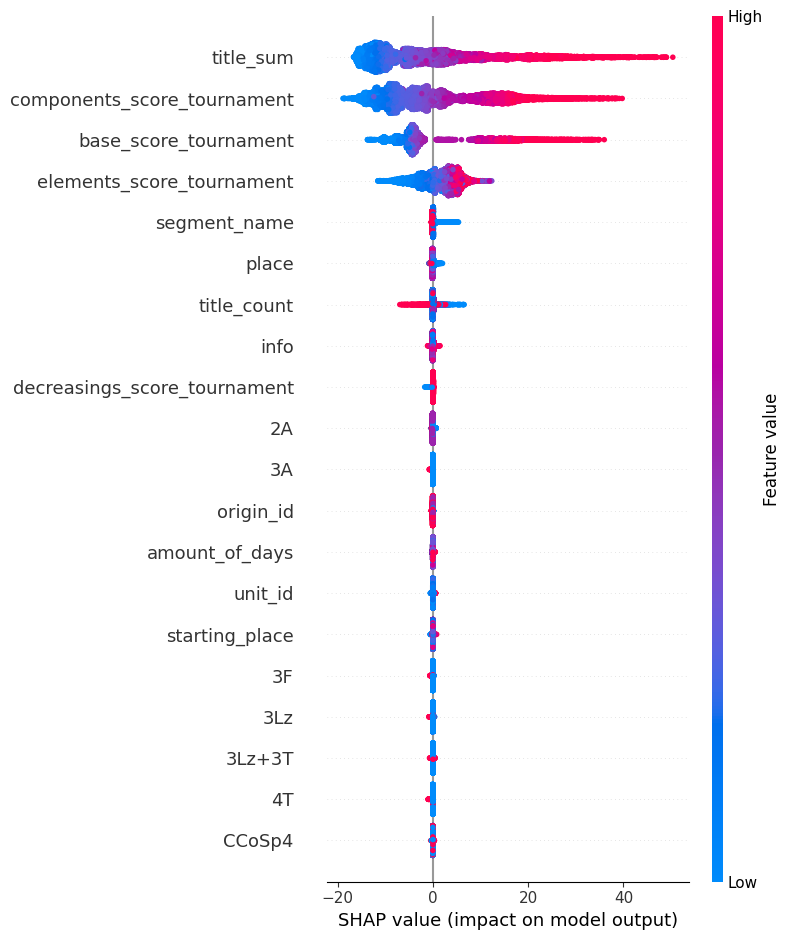

In [209]:
shap.summary_plot(shap_values, features_train)

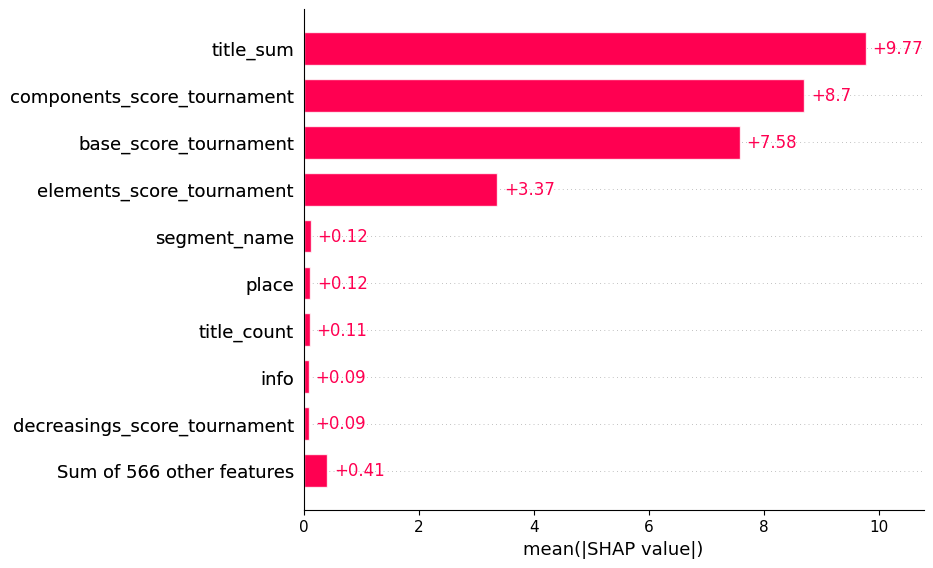

In [210]:
shap.plots.bar(shap_values)

Самый коррелирюущий признак неожиданно - *title_sum* - категориальный столбец, где собрана вся программа фигуриста по элементам. Проведем небольшой эксперимент и удалим этот столбец из нашего датасета и проверим, как изменятся финальные метрики.

### Удаление самого коррелирующего признака

**Удалим признак *title_sum***

In [211]:
features_train_1 = train.drop(['total_score_tournament', 'title_sum'], axis=1)
target_train_1 = train['total_score_tournament']

features_test_1 = test.drop(['total_score_tournament', 'title_sum'], axis=1)
target_test_1 = test['total_score_tournament']

print('Размер тренировочной выборки (признаки):', features_train_1.shape)
print('Размер тестовой выборки (признаки):', features_test_1.shape)
print('Размер тренировочной выборки (целевой признак):', target_train_1.shape)
print('Размер тестовой выборки (целевой признак):', target_test_1.shape)

Размер тренировочной выборки (признаки): (16984, 574)
Размер тестовой выборки (признаки): (4246, 574)
Размер тренировочной выборки (целевой признак): (16984,)
Размер тестовой выборки (целевой признак): (4246,)


In [212]:
features_train_1.head()

unit_id            segment_name  title_count  \
date_start                                                 
2089-09-20      304      Короткая программа            7   
2089-09-20      306      Короткая программа            7   
2089-09-20      306  Произвольная программа           11   
2089-09-20      310      Короткая программа            7   
2089-09-20      310  Произвольная программа           11   

            base_score_tournament  components_score_tournament  \
date_start                                                       
2089-09-20                  37.41                        38.67   
2089-09-20                  31.33                        35.75   
2089-09-20                  72.02                        72.48   
2089-09-20                  31.83                        34.07   
2089-09-20                  47.98                        66.50   

            elements_score_tournament  decreasings_score_tournament  \
date_start                                                            
2089-09-20                      45.28                           0.0   
2089-09-20                      34.30                          -1.0   
2089-09-20                       0.00                           0.0   
2089-09-20                       0.00                           0.0   
2089-09-20                       0.00                          -1.0   

            starting_place  place  \
date_start                          
2089-09-20              26      1   
2089-09-20               1     10   
2089-09-20              19      1   
2089-09-20              21      7   
2089-09-20              22     10   

                                                                                                                                               info  \
date_start                                                                                                                                            
2089-09-20                                                                                  x Надбавка за прыжки во второй половине программы (10%)   
2089-09-20                                                                                  x Надбавка за прыжки во второй половине программы (10%)   
2089-09-20                                 x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   
2089-09-20                                 x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   
2089-09-20  ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) B Элемент получил бонус@@@Бонусных баллов: +1,00   

            origin_id  amount_of_days  1A  1A+1A  1A+1Eu+1S  1A+1Eu+2F  \
date_start                                                               
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   

            1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  \
date_start                                                                
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   

            1A+2Lo  1A+2T  1A+3S  1A+3T  1A+Lo  1F  1F+1A  1F+1A+2A  \
date_start                                                            
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0    

In [213]:
# категориальные признаки

cat_features_1 = features_train_1.select_dtypes(include=['object']).columns.to_list()
cat_features_1

['segment_name', 'info']

In [214]:
# численные признаки

num_features_1 = features_train_1.select_dtypes(exclude=['object']).columns.to_list()
num_features_1

['unit_id',
 'title_count',
 'base_score_tournament',
 'components_score_tournament',
 'elements_score_tournament',
 'decreasings_score_tournament',
 'starting_place',
 'place',
 'origin_id',
 'amount_of_days',
 '1A',
 '1A+1A',
 '1A+1Eu+1S',
 '1A+1Eu+2F',
 '1A+1Eu+2S',
 '1A+1Eu+3S',
 '1A+1Lo',
 '1A+1Lo+1Lo',
 '1A+1Lo+2Lo',
 '1A+1T',
 '1A+2Lo',
 '1A+2T',
 '1A+3S',
 '1A+3T',
 '1A+Lo',
 '1F',
 '1F+1A',
 '1F+1A+2A',
 '1F+1Eu+2S',
 '1F+1Eu+3S',
 '1F+1Lo',
 '1F+1T',
 '1F+2A',
 '1F+2A+2A',
 '1F+2Lo',
 '1F+2T',
 '1F+3T',
 '1Lo',
 '1Lo+1A',
 '1Lo+1Eu+2S',
 '1Lo+1Eu+3S',
 '1Lo+1Lo',
 '1Lo+1T',
 '1Lo+1T+1Lo',
 '1Lo+2A',
 '1Lo+2A+2Lo',
 '1Lo+2Lo',
 '1Lo+2T',
 '1Lo+3T',
 '1Lz',
 '1Lz+1A',
 '1Lz+1Eu+3S',
 '1Lz+1Lo',
 '1Lz+1T',
 '1Lz+2A',
 '1Lz+2A+2A',
 '1Lz+2A+2T',
 '1Lz+2Lo',
 '1Lz+2Lo+2Lo',
 '1Lz+2S',
 '1Lz+2T',
 '1Lz+3T',
 '1S',
 '1S+1A',
 '1S+1Eu+2F',
 '1S+1Lo',
 '1S+1T',
 '1S+2A',
 '1S+2S+2T',
 '1S+2T',
 '1T',
 '1T+1Lo',
 '1T+1T',
 '1W+1T',
 '2A',
 '2A+1A',
 '2A+1A+1A',
 '2A+1A+2Lo',
 '2A+1A+2T

Преобразуем категориальные признаки в численные с помощью техники *MEstimateEncoder*. Она заключается в замене категориальных значений в переменной средним значением целевой переменной (целевого признака) для каждой категории.

In [215]:
enc = MEstimateEncoder(cols=cat_features_1, m=5.0)

enc.fit(features_train_1[cat_features_1], target_train_1)

features_train_1[cat_features_1] = enc.transform(features_train_1[cat_features_1])
features_test_1[cat_features_1] = enc.transform(features_test_1[cat_features_1])

features_train_1.head()

unit_id  segment_name  title_count  base_score_tournament  \
date_start                                                              
2089-09-20      304     50.237654            7                  37.41   
2089-09-20      306     50.237654            7                  31.33   
2089-09-20      306     74.399166           11                  72.02   
2089-09-20      310     50.237654            7                  31.83   
2089-09-20      310     74.399166           11                  47.98   

            components_score_tournament  elements_score_tournament  \
date_start                                                           
2089-09-20                        38.67                      45.28   
2089-09-20                        35.75                      34.30   
2089-09-20                        72.48                       0.00   
2089-09-20                        34.07                       0.00   
2089-09-20                        66.50                       0.00   

            decreasings_score_tournament  starting_place  place       info  \
date_start                                                                   
2089-09-20                           0.0              26      1  74.877382   
2089-09-20                          -1.0               1     10  74.877382   
2089-09-20                           0.0              19      1  97.167310   
2089-09-20                           0.0              21      7  97.167310   
2089-09-20                          -1.0              22     10  96.616885   

            origin_id  amount_of_days  1A  1A+1A  1A+1Eu+1S  1A+1Eu+2F  \
date_start                                                               
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   

            1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  \
date_start                                                                
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   

            1A+2Lo  1A+2T  1A+3S  1A+3T  1A+Lo  1F  1F+1A  1F+1A+2A  \
date_start                                                            
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   1      0         0   

            1F+1Eu+2S  1F+1Eu+3S  1F+1Lo  1F+1T  1F+2A  1F+2A+2A  1F+2Lo  \
date_start                                                                 
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   

            1F+2T  1F+3T  1Lo  1Lo+1A  1Lo+1Eu+2S  1Lo+1Eu+3S  1Lo+1Lo  \
date_start                                                               
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      

#### Построение моделей и оценка их качества

In [216]:
def best_hyper_model(model,
                     parameters_m,
                     features=features_train_1,
                     target=target_train_1):

    # подбор лучших гиперпараметров модели с учетом метрики

    rand_m = RandomizedSearchCV(estimator=model,
                                param_distributions=parameters_m,
                                cv=tscv,
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1,
                                random_state=RANDOM_STATE)

    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)

    best_model = rand_m.best_estimator_

    best_score = rand_m.best_score_
    print('MAE модели', best_score)

    return  best_model, best_params, best_score

#### CatBoostRegressor

In [217]:
parameters_cbr_1 = {'learning_rate': [0.001,0.01,0.02,0.03,0.04],
                    'depth': range(1, 16, 1),
                    'iterations': range(1, 301, 50)}

In [218]:
%%time

model_cbr_1, params_cbr_1, best_score_cbr_1 = best_hyper_model(
    CatBoostRegressor(random_state=RANDOM_STATE,
                      loss_function='MAE'),
    parameters_cbr_1
)

0:	learn: 24.9720796	total: 109ms	remaining: 27.2s
1:	learn: 24.2636572	total: 204ms	remaining: 25.4s
2:	learn: 23.5792683	total: 294ms	remaining: 24.3s
3:	learn: 22.9251447	total: 389ms	remaining: 24s
4:	learn: 22.3249329	total: 483ms	remaining: 23.8s
5:	learn: 21.7080241	total: 600ms	remaining: 24.5s
6:	learn: 21.0968887	total: 686ms	remaining: 23.9s
7:	learn: 20.5037618	total: 758ms	remaining: 23s
8:	learn: 19.9362930	total: 850ms	remaining: 22.9s
9:	learn: 19.3790134	total: 917ms	remaining: 22.1s
10:	learn: 18.8507279	total: 1.01s	remaining: 22.1s
11:	learn: 18.3435071	total: 1.09s	remaining: 21.8s
12:	learn: 17.8239499	total: 1.18s	remaining: 21.6s
13:	learn: 17.3446632	total: 1.27s	remaining: 21.6s
14:	learn: 16.8900120	total: 1.37s	remaining: 21.5s
15:	learn: 16.4762923	total: 1.45s	remaining: 21.4s
16:	learn: 16.0356742	total: 1.55s	remaining: 21.4s
17:	learn: 15.6152966	total: 1.66s	remaining: 21.5s
18:	learn: 15.2231057	total: 1.74s	remaining: 21.2s
19:	learn: 14.8219378	tota

In [219]:
results_cbr = []
results_cbr.append({'Модель': 'CatBoostRegressor',
                    'Параметры': params_cbr_1,
                    'MAE': round(best_score_cbr_1*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_cbr)

Модель                                                Параметры  \
0  CatBoostRegressor  {'learning_rate': 0.03, 'iterations': 251, 'depth': 10}   

    MAE  
0  1.78

#### LGBMRegressor

In [220]:
parameters_lgbm_1 = {'max_depth' : range(1, 30, 5),
                     'n_estimators' : range(101, 301, 50),
                     'num_leaves' : range(1, 51, 10),
                     'force_col_wise' : [True, False]}

In [221]:
%%time

model_lgbm_1, params_lgbm_1, best_score_lgbm_1 = best_hyper_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    parameters_lgbm_1
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 16984, number of used features: 228
[LightGBM] [Info] Start training from score 62.795277
Гиперпараметры лучшей модели {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}
MAE модели -0.9229545410859288
CPU times: user 1.64 s, sys: 172 ms, total: 1.82 s
Wall time: 16.6 s


In [222]:
results_lgbm = []
results_lgbm.append({'Модель': 'LGBMRegressor',
                    'Параметры': params_lgbm_1,
                    'MAE': round(best_score_lgbm_1*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_lgbm)

Модель  \
0  LGBMRegressor   

                                                                           Параметры  \
0  {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}   

    MAE  
0  0.92

In [223]:
#занесем результаты в отдельный датафрейм
model_type = ['CatBoostRegressor', 'LGBMRegressor']
MAE = [best_score_cbr_1*-1, best_score_lgbm_1*-1]

result = pd.DataFrame({'Model Type': model_type,
                       'MAE': MAE})

result

Model Type       MAE
0  CatBoostRegressor  1.780005
1      LGBMRegressor  0.922955

### Тестирование лучшей модели

In [224]:
best_model_test_1 = model_lgbm_1.predict(features_test_1)

RMSE_test_1 = mean_squared_error(target_test_1, best_model_test_1, squared=False)
MAPE_test_1 = mean_absolute_percentage_error(target_test_1, best_model_test_1)
MAE_test_1 = mean_absolute_error(target_test_1, best_model_test_1)

print("Результат тестовой метрики MAE для модели LGBMRegressor:", MAE_test_1)
print("Результат тестовой метрики RMSE для модели LGBMRegressor:", RMSE_test_1)
print("Результат тестовой метрики MAPE для модели LGBMRegressor:", MAPE_test_1)

Результат тестовой метрики MAE для модели LGBMRegressor: 0.6578018524948522
Результат тестовой метрики RMSE для модели LGBMRegressor: 1.6904279554468975
Результат тестовой метрики MAPE для модели LGBMRegressor: 0.027515618924017177


**Mean Absolute Error (MAE)** = была 14 - стала 0.66.

**Root Mean Squared Error (RMSE)** = была 18 - стала 1.69.

**Mean Absolute Percentage Error (MAPE)** = была 0.48 – стала 0.03.

Без признака *title_sum* получились неплохие метрики.

### Важность признаков

In [227]:
explainer = shap.Explainer(model_lgbm_1, feature_names=features_train_1.columns)
shap_values = explainer(features_train_1)

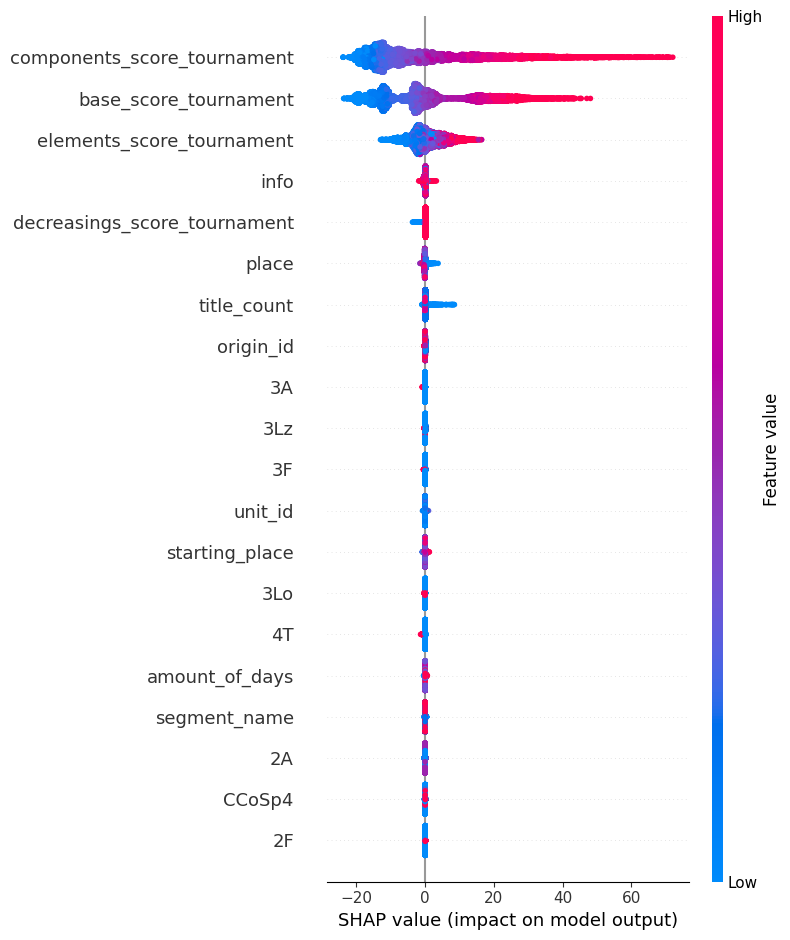

In [228]:
shap.summary_plot(shap_values, features_train_1)

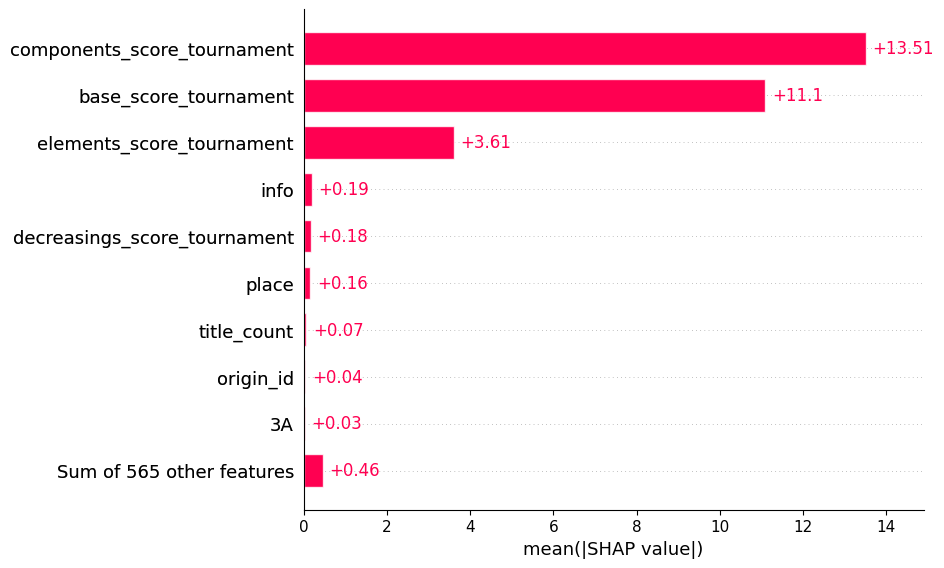

In [229]:
shap.plots.bar(shap_values)

Логично, что общий тотал зависит от тех элементов, которые его и составляют. В идеале, хотелось бы, чтобы модель получив на вход список из названия элементов программы, могла спрогнозировать общий total score для фигуриста. Попробуем еще такой вариант рассмотреть.

### Удаление всех неизвестных изначально признаков

**Удалим признаки**

In [230]:
features_train_2 = train.drop(['total_score_tournament',
                               'title_sum',
                               'base_score_tournament',
                               'components_score_tournament',
                               'elements_score_tournament',
                               'decreasings_score_tournament',
                               'place',
                               'info'], axis=1)
target_train_2 = train['total_score_tournament']

features_test_2 = test.drop(['total_score_tournament',
                               'title_sum',
                               'base_score_tournament',
                               'components_score_tournament',
                               'elements_score_tournament',
                               'decreasings_score_tournament',
                               'place',
                               'info'], axis=1)
target_test_2 = test['total_score_tournament']

print('Размер тренировочной выборки (признаки):', features_train_2.shape)
print('Размер тестовой выборки (признаки):', features_test_2.shape)
print('Размер тренировочной выборки (целевой признак):', target_train_2.shape)
print('Размер тестовой выборки (целевой признак):', target_test_2.shape)

Размер тренировочной выборки (признаки): (16984, 568)
Размер тестовой выборки (признаки): (4246, 568)
Размер тренировочной выборки (целевой признак): (16984,)
Размер тестовой выборки (целевой признак): (4246,)


In [232]:
features_train_2.head()

unit_id            segment_name  title_count  starting_place  \
date_start                                                                 
2089-09-20      304      Короткая программа            7              26   
2089-09-20      306      Короткая программа            7               1   
2089-09-20      306  Произвольная программа           11              19   
2089-09-20      310      Короткая программа            7              21   
2089-09-20      310  Произвольная программа           11              22   

            origin_id  amount_of_days  1A  1A+1A  1A+1Eu+1S  1A+1Eu+2F  \
date_start                                                               
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   
2089-09-20        1.0               3   0      0          0          0   

            1A+1Eu+2S  1A+1Eu+3S  1A+1Lo  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  \
date_start                                                                
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   
2089-09-20          0          0       0           0           0      0   

            1A+2Lo  1A+2T  1A+3S  1A+3T  1A+Lo  1F  1F+1A  1F+1A+2A  \
date_start                                                            
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   0      0         0   
2089-09-20       0      0      0      0      0   1      0         0   

            1F+1Eu+2S  1F+1Eu+3S  1F+1Lo  1F+1T  1F+2A  1F+2A+2A  1F+2Lo  \
date_start                                                                 
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   
2089-09-20          0          0       0      0      0         0       0   

            1F+2T  1F+3T  1Lo  1Lo+1A  1Lo+1Eu+2S  1Lo+1Eu+3S  1Lo+1Lo  \
date_start                                                               
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      0      0    0       0           0           0        0   
2089-09-20      0      0    0       0           0           0        0   

            1Lo+1T  1Lo+1T+1Lo  1Lo+2A  1Lo+2A+2Lo  1Lo+2Lo  1Lo+2T  1Lo+3T  \
date_start                                                                    
2089-09-20       0           0       0           0        0       0       0   
2089-09-20       0           0       0           0        0       0       0   
2089-09-20       0           0       0           0        0       0       0   
2089-09-20       0           0       0           0        0       0       0   
2089-09-20       0           0       0           0        0       0       0   

            1Lz  1Lz+1A  1Lz+1Eu+3S  1Lz+1Lo  1Lz+1T  1Lz+2A  1Lz+2A+2A  \
date_start                                                                
2089-09-20    0       0           0        0       0       0          0   
2089-09-20    0       0           0        0       0       0          0   
2089-09-20    0       0       

In [235]:
# категориальные признаки

cat_features_2 = features_train_2.select_dtypes(include=['object']).columns.to_list()
cat_features_2

['segment_name']

In [236]:
# численные признаки

num_features_2 = features_train_2.select_dtypes(exclude=['object']).columns.to_list()
num_features_2

['unit_id',
 'title_count',
 'starting_place',
 'origin_id',
 'amount_of_days',
 '1A',
 '1A+1A',
 '1A+1Eu+1S',
 '1A+1Eu+2F',
 '1A+1Eu+2S',
 '1A+1Eu+3S',
 '1A+1Lo',
 '1A+1Lo+1Lo',
 '1A+1Lo+2Lo',
 '1A+1T',
 '1A+2Lo',
 '1A+2T',
 '1A+3S',
 '1A+3T',
 '1A+Lo',
 '1F',
 '1F+1A',
 '1F+1A+2A',
 '1F+1Eu+2S',
 '1F+1Eu+3S',
 '1F+1Lo',
 '1F+1T',
 '1F+2A',
 '1F+2A+2A',
 '1F+2Lo',
 '1F+2T',
 '1F+3T',
 '1Lo',
 '1Lo+1A',
 '1Lo+1Eu+2S',
 '1Lo+1Eu+3S',
 '1Lo+1Lo',
 '1Lo+1T',
 '1Lo+1T+1Lo',
 '1Lo+2A',
 '1Lo+2A+2Lo',
 '1Lo+2Lo',
 '1Lo+2T',
 '1Lo+3T',
 '1Lz',
 '1Lz+1A',
 '1Lz+1Eu+3S',
 '1Lz+1Lo',
 '1Lz+1T',
 '1Lz+2A',
 '1Lz+2A+2A',
 '1Lz+2A+2T',
 '1Lz+2Lo',
 '1Lz+2Lo+2Lo',
 '1Lz+2S',
 '1Lz+2T',
 '1Lz+3T',
 '1S',
 '1S+1A',
 '1S+1Eu+2F',
 '1S+1Lo',
 '1S+1T',
 '1S+2A',
 '1S+2S+2T',
 '1S+2T',
 '1T',
 '1T+1Lo',
 '1T+1T',
 '1W+1T',
 '2A',
 '2A+1A',
 '2A+1A+1A',
 '2A+1A+2Lo',
 '2A+1A+2T',
 '2A+1Eu+1F',
 '2A+1Eu+1S',
 '2A+1Eu+2F',
 '2A+1Eu+2S',
 '2A+1Eu+2T',
 '2A+1Eu+3F',
 '2A+1Eu+3S',
 '2A+1Lo',
 '2A+1Lo+2Lo',
 '2A

Преобразуем категориальные признаки в численные с помощью техники *MEstimateEncoder*. Она заключается в замене категориальных значений в переменной средним значением целевой переменной (целевого признака) для каждой категории.

In [237]:
enc = MEstimateEncoder(cols=cat_features_2, m=5.0)

enc.fit(features_train_2[cat_features_2], target_train_2)

features_train_2[cat_features_2] = enc.transform(features_train_2[cat_features_2])
features_test_2[cat_features_2] = enc.transform(features_test_2[cat_features_2])

features_train_2.head()

unit_id  segment_name  title_count  starting_place  origin_id  \
date_start                                                                  
2089-09-20      304     50.237654            7              26        1.0   
2089-09-20      306     50.237654            7               1        1.0   
2089-09-20      306     74.399166           11              19        1.0   
2089-09-20      310     50.237654            7              21        1.0   
2089-09-20      310     74.399166           11              22        1.0   

            amount_of_days  1A  1A+1A  1A+1Eu+1S  1A+1Eu+2F  1A+1Eu+2S  \
date_start                                                               
2089-09-20               3   0      0          0          0          0   
2089-09-20               3   0      0          0          0          0   
2089-09-20               3   0      0          0          0          0   
2089-09-20               3   0      0          0          0          0   
2089-09-20               3   0      0          0          0          0   

            1A+1Eu+3S  1A+1Lo  1A+1Lo+1Lo  1A+1Lo+2Lo  1A+1T  1A+2Lo  1A+2T  \
date_start                                                                    
2089-09-20          0       0           0           0      0       0      0   
2089-09-20          0       0           0           0      0       0      0   
2089-09-20          0       0           0           0      0       0      0   
2089-09-20          0       0           0           0      0       0      0   
2089-09-20          0       0           0           0      0       0      0   

            1A+3S  1A+3T  1A+Lo  1F  1F+1A  1F+1A+2A  1F+1Eu+2S  1F+1Eu+3S  \
date_start                                                                   
2089-09-20      0      0      0   0      0         0          0          0   
2089-09-20      0      0      0   0      0         0          0          0   
2089-09-20      0      0      0   0      0         0          0          0   
2089-09-20      0      0      0   0      0         0          0          0   
2089-09-20      0      0      0   1      0         0          0          0   

            1F+1Lo  1F+1T  1F+2A  1F+2A+2A  1F+2Lo  1F+2T  1F+3T  1Lo  1Lo+1A  \
date_start                                                                      
2089-09-20       0      0      0         0       0      0      0    0       0   
2089-09-20       0      0      0         0       0      0      0    0       0   
2089-09-20       0      0      0         0       0      0      0    0       0   
2089-09-20       0      0      0         0       0      0      0    0       0   
2089-09-20       0      0      0         0       0      0      0    0       0   

            1Lo+1Eu+2S  1Lo+1Eu+3S  1Lo+1Lo  1Lo+1T  1Lo+1T+1Lo  1Lo+2A  \
date_start                                                                
2089-09-20           0           0        0       0           0       0   
2089-09-20           0           0        0       0           0       0   
2089-09-20           0           0        0       0           0       0   
2089-09-20           0           0        0       0           0       0   
2089-09-20           0           0        0       0           0       0   

            1Lo+2A+2Lo  1Lo+2Lo  1Lo+2T  1Lo+3T  1Lz  1Lz+1A  1Lz+1Eu+3S  \
date_start                                                                 
2089-09-20           0        0       0       0    0       0           0   
2089-09-20           0        0       0       0    0       0           0   
2089-09-20           0        0       0       0    0       0           0   
2089-09-20           0        0       0       0    0       0           0   
2089-09-20           0        0       0       0    0       0           0   

            1Lz+1Lo  1Lz+1T  1Lz+2A  1Lz+2A+2A  1Lz+2A+2T  1Lz+2Lo  \
date_start                                                           
2089-09-20        0       0       0          0          0        0   
2089-09-20     

#### Построение моделей и оценка их качества

In [238]:
def best_hyper_model(model,
                     parameters_m,
                     features=features_train_2,
                     target=target_train_2):

    # подбор лучших гиперпараметров модели с учетом метрики

    rand_m = RandomizedSearchCV(estimator=model,
                                param_distributions=parameters_m,
                                cv=tscv,
                                scoring='neg_mean_absolute_error',
                                n_jobs=-1,
                                random_state=RANDOM_STATE)

    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)

    best_model = rand_m.best_estimator_

    best_score = rand_m.best_score_
    print('MAE модели', best_score)

    return  best_model, best_params, best_score

#### CatBoostRegressor

In [239]:
parameters_cbr_2 = {'learning_rate': [0.001,0.01,0.02,0.03,0.04],
                    'depth': range(1, 16, 1),
                    'iterations': range(1, 301, 50)}

In [240]:
%%time

model_cbr_2, params_cbr_2, best_score_cbr_2 = best_hyper_model(
    CatBoostRegressor(random_state=RANDOM_STATE,
                      loss_function='MAE'),
    parameters_cbr_2
)

0:	learn: 25.0008025	total: 38.8ms	remaining: 9.69s
1:	learn: 24.3742062	total: 73.5ms	remaining: 9.15s
2:	learn: 23.7647896	total: 110ms	remaining: 9.11s
3:	learn: 23.1671479	total: 145ms	remaining: 8.96s
4:	learn: 22.6001494	total: 183ms	remaining: 8.99s
5:	learn: 22.0464343	total: 219ms	remaining: 8.96s
6:	learn: 21.5119238	total: 258ms	remaining: 8.99s
7:	learn: 21.0080902	total: 305ms	remaining: 9.27s
8:	learn: 20.4879899	total: 356ms	remaining: 9.57s
9:	learn: 19.9809080	total: 404ms	remaining: 9.74s
10:	learn: 19.5122836	total: 451ms	remaining: 9.84s
11:	learn: 19.0484969	total: 503ms	remaining: 10s
12:	learn: 18.6206966	total: 559ms	remaining: 10.2s
13:	learn: 18.1825391	total: 605ms	remaining: 10.3s
14:	learn: 17.7584834	total: 646ms	remaining: 10.2s
15:	learn: 17.3484809	total: 681ms	remaining: 10s
16:	learn: 16.9548126	total: 721ms	remaining: 9.92s
17:	learn: 16.5819526	total: 771ms	remaining: 9.98s
18:	learn: 16.2310096	total: 807ms	remaining: 9.86s
19:	learn: 15.8709604	to

In [241]:
results_cbr = []
results_cbr.append({'Модель': 'CatBoostRegressor',
                    'Параметры': params_cbr_2,
                    'MAE': round(best_score_cbr_2*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_cbr)

Модель                                                Параметры  \
0  CatBoostRegressor  {'learning_rate': 0.03, 'iterations': 251, 'depth': 10}   

    MAE  
0  7.33

#### LGBMRegressor

In [242]:
parameters_lgbm_2 = {'max_depth' : range(1, 30, 5),
                     'n_estimators' : range(101, 301, 50),
                     'num_leaves' : range(1, 51, 10),
                     'force_col_wise' : [True, False]}

In [243]:
%%time

model_lgbm_2, params_lgbm_2, best_score_lgbm_2 = best_hyper_model(
    LGBMRegressor(random_state=RANDOM_STATE),
    parameters_lgbm_2
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 16984, number of used features: 222
[LightGBM] [Info] Start training from score 62.795277
Гиперпараметры лучшей модели {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}
MAE модели -6.528863389999043
CPU times: user 1.63 s, sys: 134 ms, total: 1.77 s
Wall time: 12.9 s


In [244]:
results_lgbm = []
results_lgbm.append({'Модель': 'LGBMRegressor',
                    'Параметры': params_lgbm_2,
                    'MAE': round(best_score_lgbm_2*-1, 2)})

pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_lgbm)

Модель  \
0  LGBMRegressor   

                                                                           Параметры  \
0  {'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}   

    MAE  
0  6.53

In [245]:
#занесем результаты в отдельный датафрейм
model_type = ['CatBoostRegressor', 'LGBMRegressor']
MAE = [best_score_cbr_2*-1, best_score_lgbm_2*-1]

result = pd.DataFrame({'Model Type': model_type,
                       'MAE': MAE})

result

Model Type       MAE
0  CatBoostRegressor  7.326643
1      LGBMRegressor  6.528863

### Тестирование лучшей модели

In [246]:
best_model_test_2 = model_lgbm_2.predict(features_test_2)

RMSE_test_2 = mean_squared_error(target_test_2, best_model_test_2, squared=False)
MAPE_test_2 = mean_absolute_percentage_error(target_test_2, best_model_test_2)
MAE_test_2 = mean_absolute_error(target_test_2, best_model_test_2)

print("Результат тестовой метрики MAE для модели LGBMRegressor:", MAE_test_2)
print("Результат тестовой метрики RMSE для модели LGBMRegressor:", RMSE_test_2)
print("Результат тестовой метрики MAPE для модели LGBMRegressor:", MAPE_test_2)

Результат тестовой метрики MAE для модели LGBMRegressor: 4.821028688582968
Результат тестовой метрики RMSE для модели LGBMRegressor: 8.337682490436482
Результат тестовой метрики MAPE для модели LGBMRegressor: 0.14369281845297152


**Mean Absolute Error (MAE)** = 4.82.

**Root Mean Squared Error (RMSE)** = 8.33.

**Mean Absolute Percentage Error (MAPE)** = 0.14.

Получив на входе только начальные данные о выполняемых элементах и стартовом номере, можно неплохо предсказать конечный total. Это может быть удобно для тренера, чтобы подготовить программу для фигуриста на определенный уровень.

### Важность признаков

In [247]:
explainer = shap.Explainer(model_lgbm_2, feature_names=features_train_2.columns)
shap_values = explainer(features_train_2)

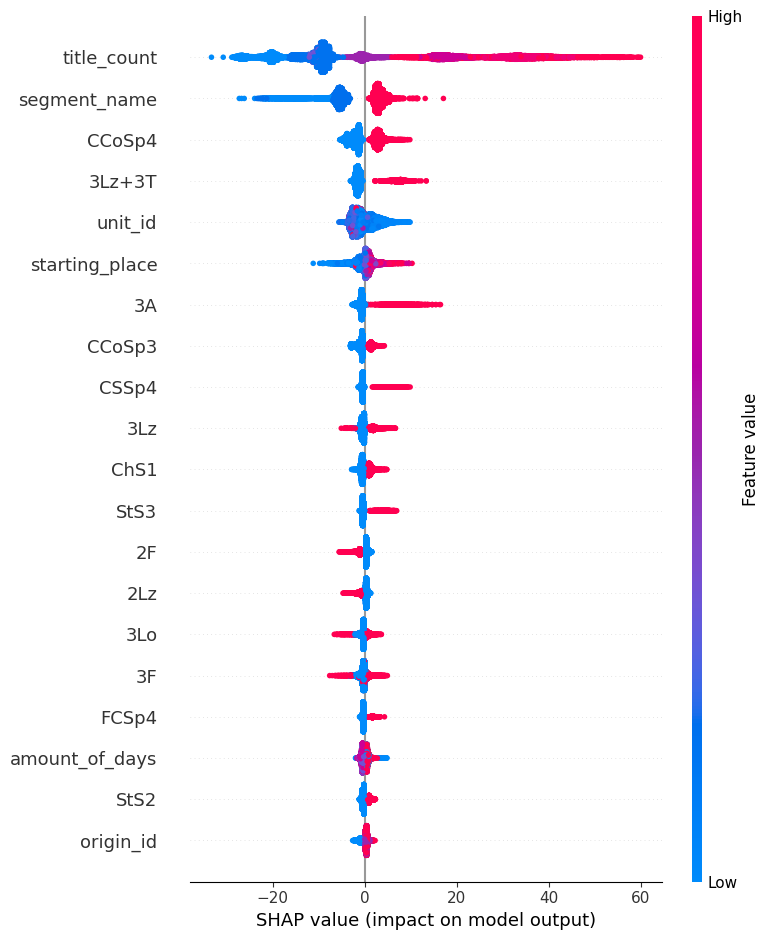

In [248]:
shap.summary_plot(shap_values, features_train_2)

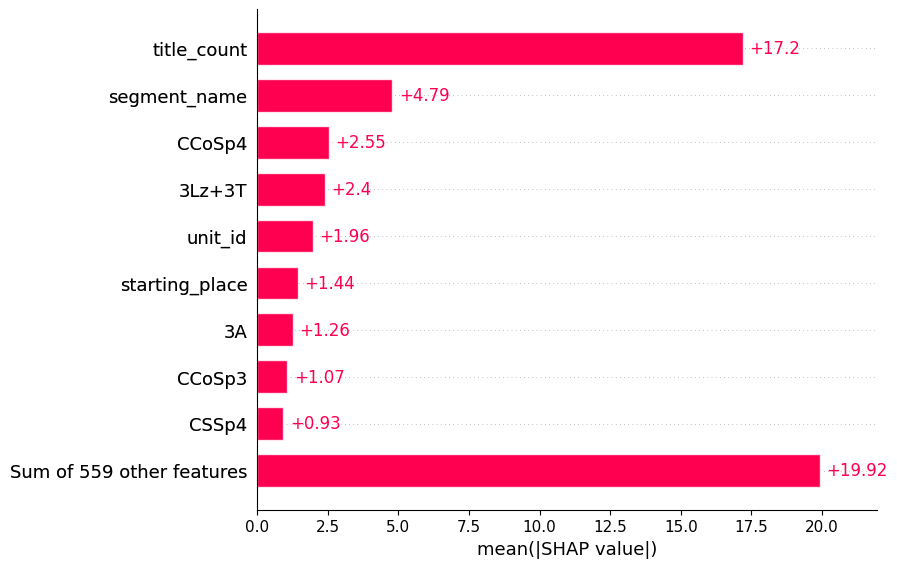

In [249]:
shap.plots.bar(shap_values)

От количества элементов зависит общий тотал, это логично, учитывая, что в Короткой программе обычно плюс минус 7 элементов, а в Произвольной - 11. Также есть небольшое коррелирование со стартовым местом выступления. Ну а дальше все зависит от элементов и чистоты их выполнения.

## Общий вывод

**Цель исследования:** Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании.  Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

Данные получим из таблиц `total_scores.csv`, `tournament_scores.csv`, `tournaments.csv`, `units.csv`.

При проведении первичного анализа были выявлены некоторые пропуски в значениях, некоторые из которых удалось восстановить, а некоторые заменить "заглушками".

Основная сложность при исследовании заключалась в формировании целевого признака для задач Классификации и Регрессии.

Для **задачи Классификации** был создан целевой признак `error_point`. который показывал, совершил ли фигурист в данном элементе ошибку (1) или нет (0). Для этого мы распарсили данные с названиями кодов элементов и выделили в отдельный столбец данные с кодами ошибок (<, <<, !, COMBO, REP, q, e и т.д.). Далее, если в элементе (или группе элементов) присутствовала ошибка - ставили метку 1, если нет ошибок - 0. Затем очистили названия элементов от кодов ошибок и использовали эти данные в качестве признаков.

**Задача Классификации** была решена отдельно для каждого сегмента программы (Короткой и Произвольной). Наилучшей моделью стала *RandomForestClassifier* с гиперпараметрами	**{'n_estimators': 71, 'max_depth': None, 'class_weight': None}** и метрикой *F1* на тестовой выборке 0.85 для обоих программ.

Для **задачи Регрессии** мы выбрали целевым признаком общую сумму баллов за сегмент программы (`total_score` в изначальных данных). Это даст тренеру возможность оценить, какую теоретическую сумму баллов может получить фигурист на основании его предыдущих выступлений. Для решения данной задачи мы выделили каждый исполняемый элемент (или каскад элементов) в отдельные столбцы и если фигурист выполнял данный элемент, то ему присваивали значение метки 1, если нет - 0. Также, для аналитической работы тренера, мы объединили все элементы в один столбец `title_sum`, где можно проследить как менялась программа от турнира к турниру и какие баллы были выставлены.

Наилучшие показатели для задачи Регрессии показала модель LGBMRegressor с гиперпараметрами **{'num_leaves': 41, 'n_estimators': 251, 'max_depth': 16, 'force_col_wise': False}**	и тестовыми метриками *Mean Absolute Error (MAE) = 4.82*, *Root Mean Squared Error (RMSE) = 8.33*, *Mean Absolute Percentage Error (MAPE) = 0.14*. За финальную модель в данном случае была выбрана модель, где входные признаки - это только сами элементы (3 вариант).

